## Simple Regression Model for Traffic Density

This Notebook aims to implement simple regression models (Polynomial, Decision Tree, Random Forest) to predict the traffic density based on Mcs data and INRIX data.<br>

Notice: Because this Notebook was copied and modified from  "flow_regression.ipynb", many comments in this Notebook remain unchanged and not correct.

## 0. Setting

### 0.1 Import Libraries

In [1]:
from google.colab import drive
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 0.2 Mount Google drive, Set working directory

In [2]:
drive.mount('/content/gdrive')
print(os.path.abspath('.'))
root_path = '/content/gdrive/My Drive/degree_project/' 
os.chdir(root_path + 'Data')
print(os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/degree_project/Data


## 1. Read the data from Mcs, Inrix from .csv

In [0]:
mcsNorth = pd.read_csv("OutData/mcsNorth.csv", delimiter = ';')
mcsSouth = pd.read_csv("OutData/mcsSouth.csv", delimiter= ';')
inrixNorth = pd.read_csv("OutData/inrixNorth.csv", delimiter= ';')
inrixSouth = pd.read_csv("OutData/inrixSouth.csv", delimiter= ';')

## 2. Discover the data to gain insight

### 2.1 Schema and dimension

In [4]:
mcsNorth.info()
print(" ")
mcsSouth.info()
print(" ")
inrixSouth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44275 entries, 0 to 44274
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fk_id          44275 non-null  int64  
 1   date           44275 non-null  object 
 2   speed          44275 non-null  float64
 3   speed_std_dev  44275 non-null  float64
 4   flow           44275 non-null  int64  
 5   used_lanes     44275 non-null  object 
 6   Epoch_mcs      44275 non-null  float64
 7   Density        44275 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 2.7+ MB
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44275 entries, 0 to 44274
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fk_id          44275 non-null  int64  
 1   date           44275 non-null  object 
 2   speed          44275 non-null  float64
 3   speed_std_dev  44275 non-null  float64
 4   flow       

### 2.2 Look at the data

In [5]:
mcsNorth.head(5)

fk_id                 date    speed  ...    used_lanes  Epoch_mcs   Density
0   1159  2018-10-01 00:00:00  26.6028  ...     {1,1,1,1}        0.0  0.103373
1   1159  2018-10-01 00:01:00  26.0600  ...  {1,1,1,NULL}       60.0  0.102328
2   1159  2018-10-01 00:02:00  25.0705  ...     {1,1,1,1}      120.0  0.069803
3   1159  2018-10-01 00:03:00  27.2009  ...  {1,1,1,NULL}      180.0  0.134799
4   1159  2018-10-01 00:04:00  24.9600  ...  {1,1,1,NULL}      240.0  0.120192

[5 rows x 8 columns]

In [6]:
mcsSouth.head(5)

fk_id                 date    speed  ...    used_lanes  Epoch_mcs   Density
0   1162  2018-10-01 00:00:00  23.1675  ...  {1,1,1,NULL}        0.0  0.158268
1   1162  2018-10-01 00:01:00  21.5449  ...  {1,1,1,NULL}       60.0  0.077358
2   1162  2018-10-01 00:02:00  24.2640  ...  {1,1,1,NULL}      120.0  0.137378
3   1162  2018-10-01 00:03:00  22.5872  ...  {1,1,1,NULL}      180.0  0.132819
4   1162  2018-10-01 00:04:00  22.7721  ...  {1,1,1,NULL}      240.0  0.204929

[5 rows x 8 columns]

In [7]:
inrixNorth.head(5)

segmentid         timestamputc  ...  Epoch_inrix  travel_time_secs
0  225285973  2018-10-01 00:00:14  ...          0.0             19.92
1  225285973  2018-10-01 00:01:12  ...         58.0             19.92
2  225285973  2018-10-01 00:02:10  ...        116.0             19.92
3  225285973  2018-10-01 00:03:11  ...        177.0             19.92
4  225285973  2018-10-01 00:04:11  ...        237.0             19.92

[5 rows x 6 columns]

### 2.3 statistical summary

In [8]:
mcsNorth.describe()

fk_id         speed  ...     Epoch_mcs       Density
count  44275.0  44275.000000  ...  4.427500e+04  44275.000000
mean    1159.0     21.968022  ...  1.338935e+06      0.751340
std        0.0      3.744714  ...  7.733852e+05      0.611224
min     1159.0      2.888890  ...  0.000000e+00      0.025532
25%     1159.0     21.013600  ...  6.688500e+05      0.194237
50%     1159.0     22.429800  ...  1.338300e+06      0.713815
75%     1159.0     24.122250  ...  2.007750e+06      1.083416
max     1159.0     44.166700  ...  2.681040e+06      4.812819

[8 rows x 6 columns]

In [9]:
mcsSouth.describe()

fk_id         speed  ...     Epoch_mcs       Density
count  44275.0  44275.000000  ...  4.427500e+04  44275.000000
mean    1162.0     20.342786  ...  1.339122e+06      0.783132
std        0.0      3.359307  ...  7.735014e+05      0.693567
min     1162.0      0.833333  ...  0.000000e+00      0.026471
25%     1162.0     19.962000  ...  6.691500e+05      0.205319
50%     1162.0     20.906600  ...  1.338300e+06      0.734430
75%     1162.0     21.944400  ...  2.007990e+06      1.084655
max     1162.0     37.777800  ...  2.681640e+06      5.552724

[8 rows x 6 columns]

In [10]:
inrixNorth.describe()

segmentid         speed       average   Epoch_inrix  travel_time_secs
count      44275.0  44275.000000  44275.000000  4.427500e+04      44275.000000
mean   225285973.0     19.738246     16.301920  1.329876e+06         27.678201
std            0.0      3.652692      1.254555  7.681668e+05         11.036287
min    225285973.0      1.666667     11.944444  0.000000e+00         13.440000
25%    225285973.0     18.333333     15.555556  6.648275e+05         23.760000
50%    225285973.0     20.000000     16.666667  1.329296e+06         25.740000
75%    225285973.0     21.388889     16.666667  1.993767e+06         28.080000
max    225285973.0     38.333333     18.888889  2.662678e+06        264.720000

## 2.4 make plots

In [0]:
# function to plot same attribute from 2 different senesors in a same diagram
def plotAttr(days, dataFrameNorth, dataFrameSouth, attribute, sensor):
  plt.style.use('default')
  plt.plot(dataFrameNorth['Epoch_'+sensor], dataFrameNorth[attribute], 'r', linewidth = 0.4, label = sensor + 'North')
  plt.plot(dataFrameSouth['Epoch_'+sensor], dataFrameSouth[attribute], 'b', linewidth = 0.4, label = sensor + 'South')
  plt.xlabel('Epochs(sec)')
  plt.ylabel(attribute)
  plt.title(attribute + ' vs. time (' + str(days) + ' days)')
  plt.legend()
  plt.show()

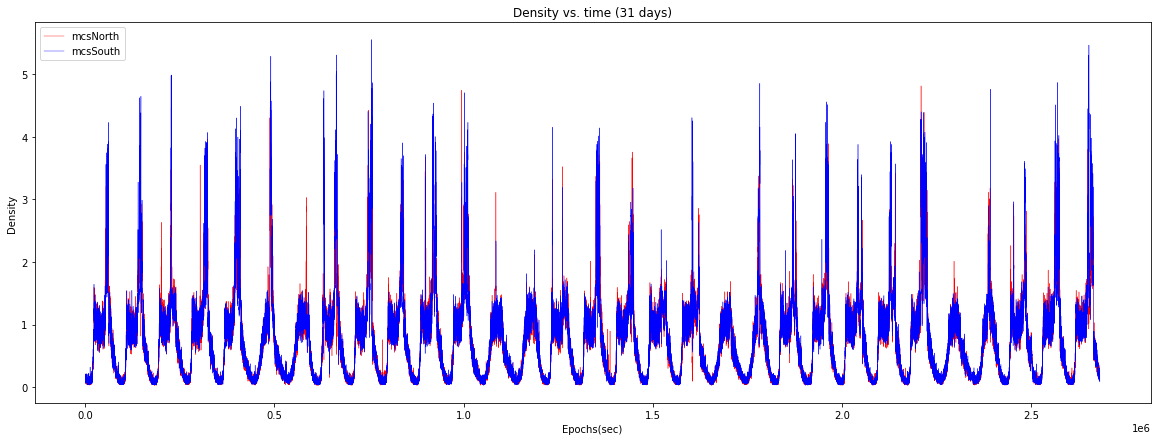

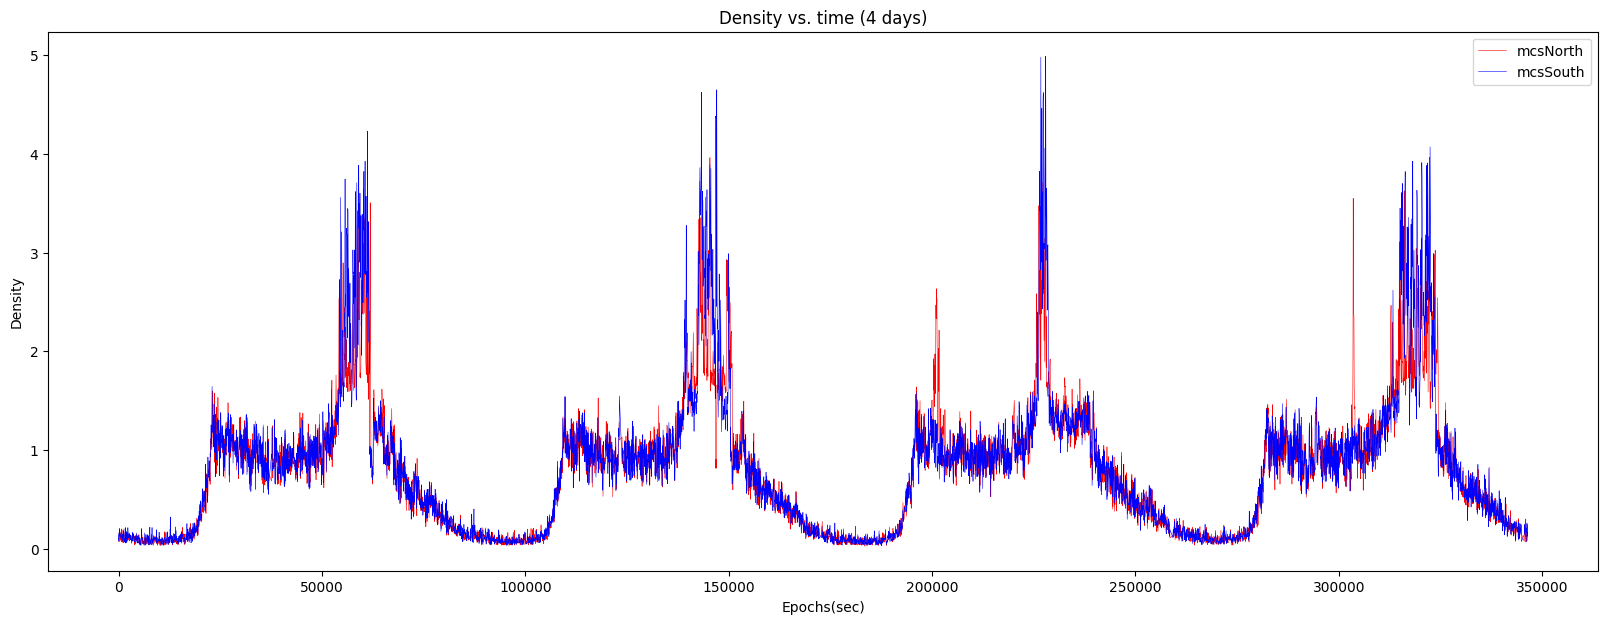

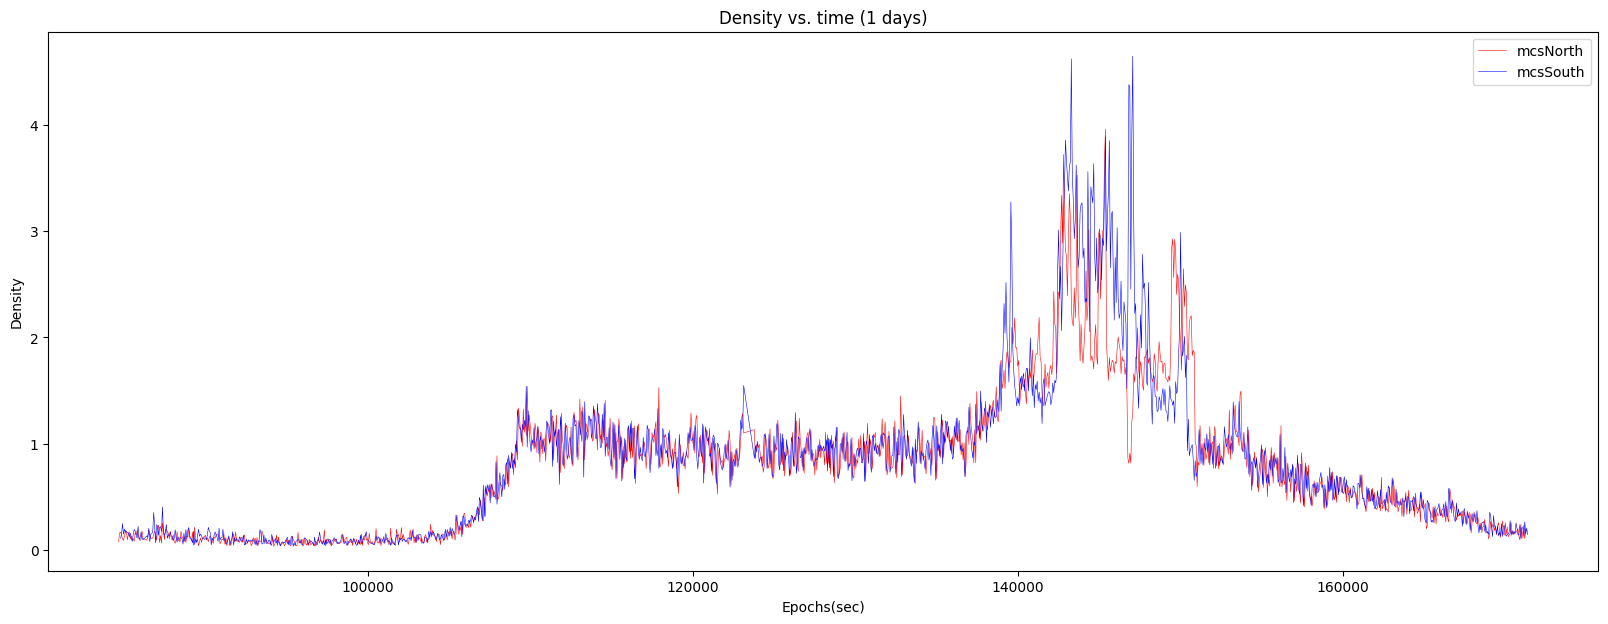

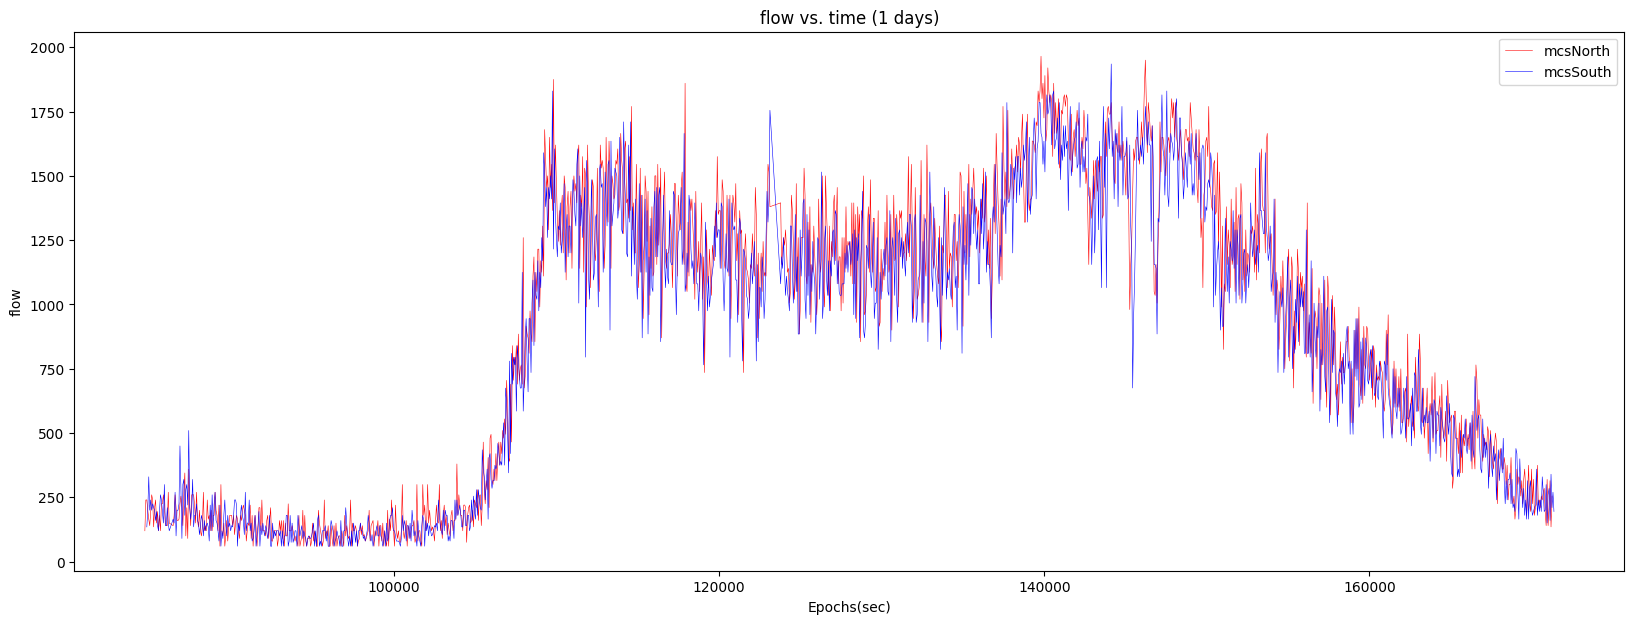

In [12]:
plt.figure(figsize = (20, 7))
plotAttr(31, mcsNorth, mcsSouth, 'Density', 'mcs')

plt.figure(figsize = (20, 7))
mcsNorth4days = mcsNorth[: round(4*len(mcsNorth)/31.0)][:]
mcsSouth4days = mcsSouth[: round(4*len(mcsSouth)/31.0)][:]
plotAttr(4, mcsNorth4days, mcsSouth4days, 'Density', 'mcs')

plt.figure(figsize = (20, 7))
mcsNorth1days = mcsNorth[1400 : 1400 + round(len(mcsNorth)/31.0)][:]
mcsSouth1days = mcsSouth[1400: 1400 + round(len(mcsSouth)/31.0)][:]
plotAttr(1, mcsNorth1days, mcsSouth1days, 'Density', 'mcs')

plt.figure(figsize = (20, 7))
mcsNorth1days = mcsNorth[1400 : 1400 + round(len(mcsNorth)/31.0)][:]
mcsSouth1days = mcsSouth[1400: 1400 + round(len(mcsSouth)/31.0)][:]
plotAttr(1, mcsNorth1days, mcsSouth1days, 'flow', 'mcs')

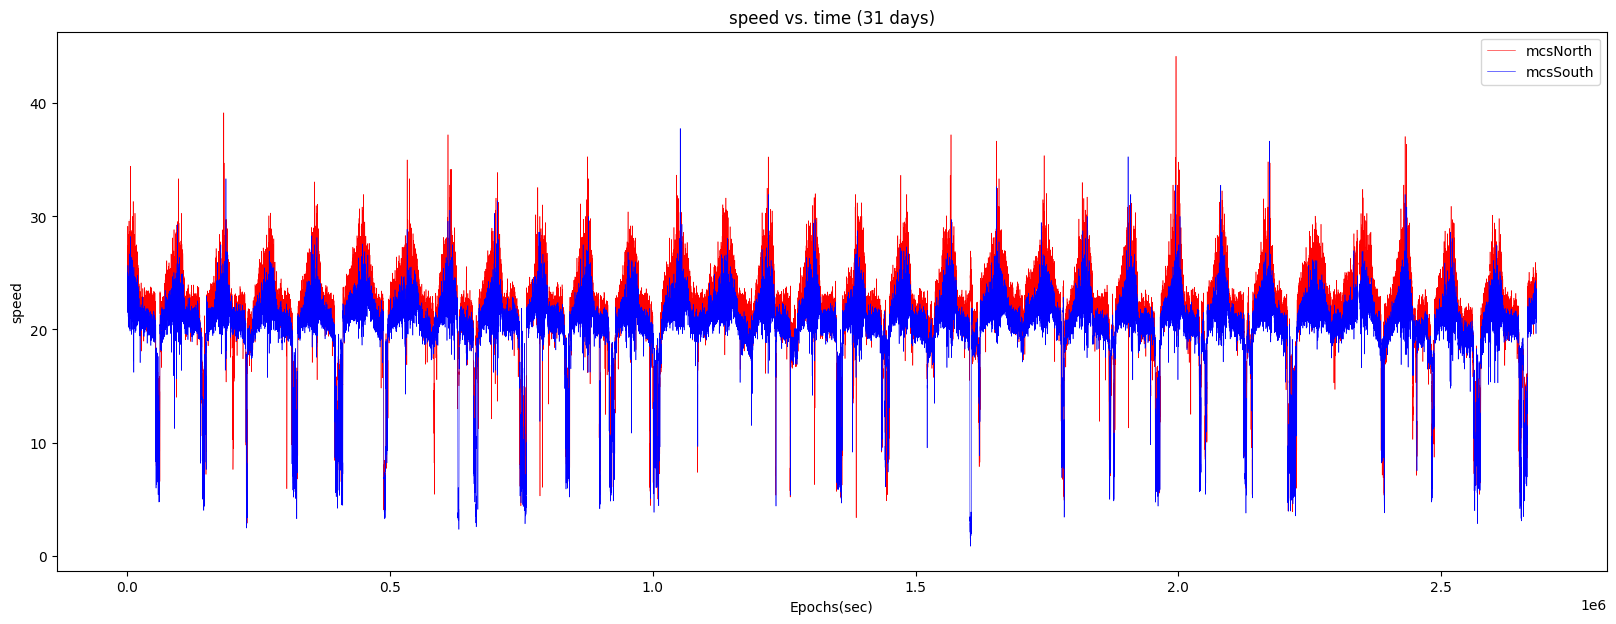

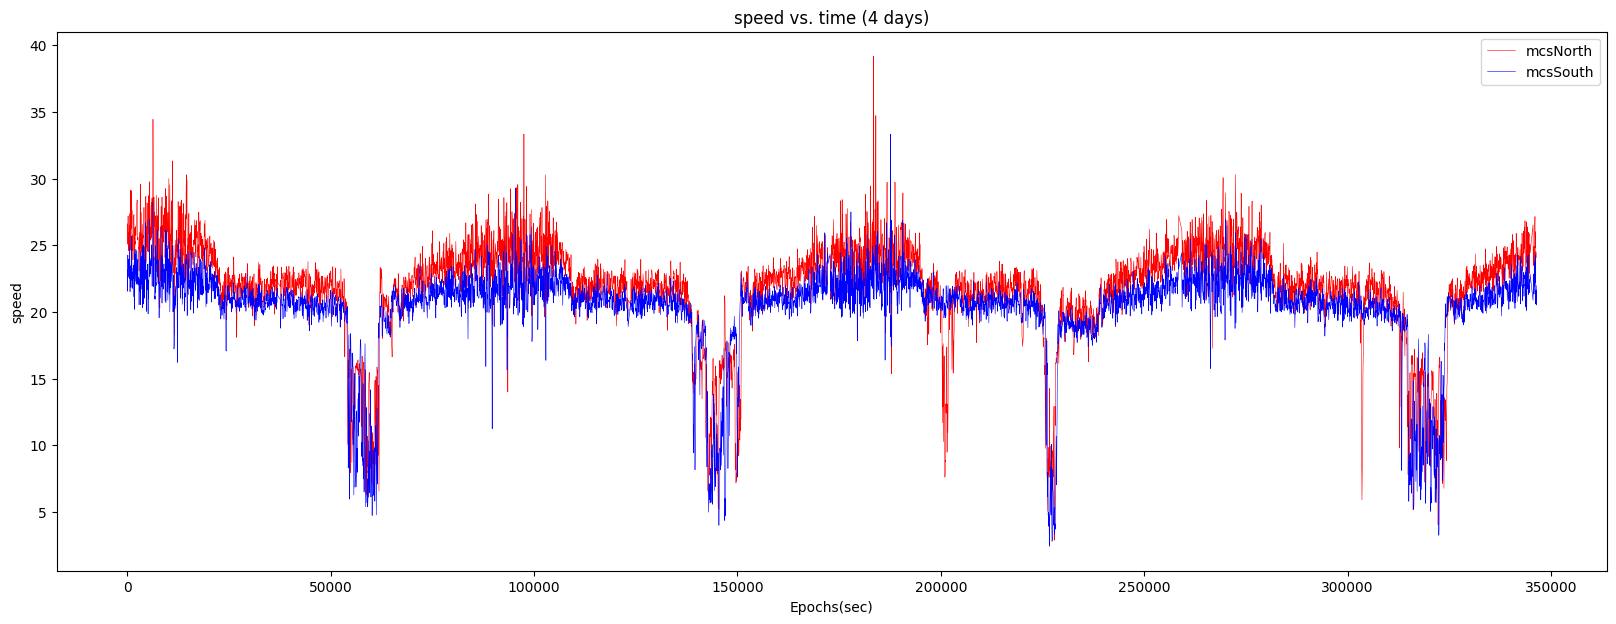

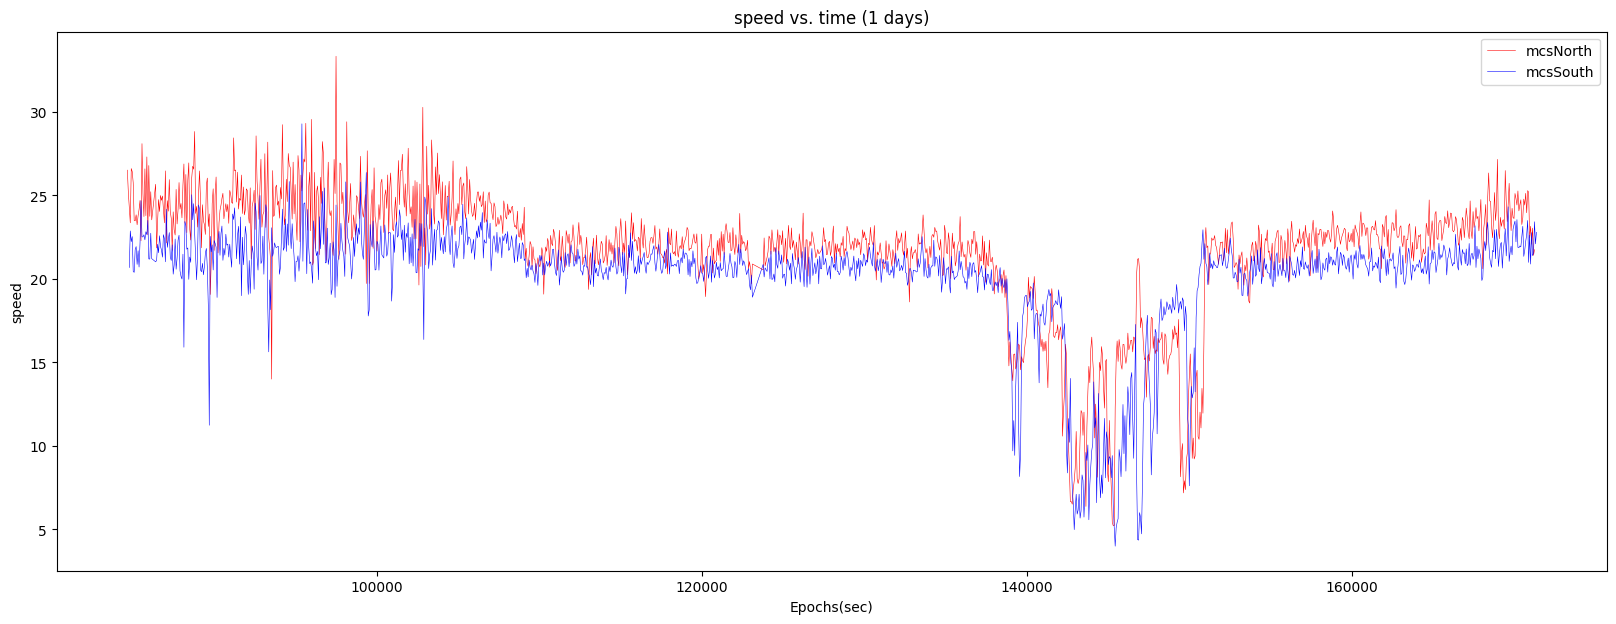

In [13]:
plt.figure(figsize = (20, 7))
plotAttr(31, mcsNorth, mcsSouth,'speed', 'mcs')
plt.figure(figsize = (20, 7))
plotAttr(4, mcsNorth4days, mcsSouth4days,'speed', 'mcs')
plt.figure(figsize = (20, 7))
plotAttr(1, mcsNorth1days, mcsSouth1days,'speed', 'mcs')


Note: The relation between flow and speed is non-linear. We cannot only use speed to predict flow, but need additional features to predict the flow together with speed.

In [0]:
# function to plot attributes in the same diagram from different sensors in different road segments
def plotAttr2(days, dataFrame1, dataFrame2, dataFrame3, attribute, sensor1, sensor2, sensor3, loc1, loc2, loc3):
  print(dataFrame1['Epoch_' + sensor1][-1:])
  print(dataFrame2['Epoch_' + sensor2][-1:])
  print(dataFrame3['Epoch_' + sensor3][-1:])
  plt.plot(dataFrame1['Epoch_' + sensor1], dataFrame1[attribute], linewidth=0.4, color= 'b', label = sensor1 + loc1)
  plt.plot(dataFrame2['Epoch_' + sensor2], dataFrame2[attribute], linewidth=0.4, color= 'k', label = sensor2 + loc2)
  plt.plot(dataFrame3['Epoch_' + sensor3], dataFrame3[attribute], linewidth=0.4, color= 'g', label = sensor3 + loc3)
  plt.xlabel('Epochs(sec)')
  plt.ylabel(attribute)
  plt.title(attribute + ' vs. time (' + str(days) + ' days)')
  plt.legend()
  plt.show()

1427    86580.0
Name: Epoch_mcs, dtype: float64
1427    85616.0
Name: Epoch_inrix, dtype: float64
1427    85616
Name: Epoch_inrix, dtype: int64


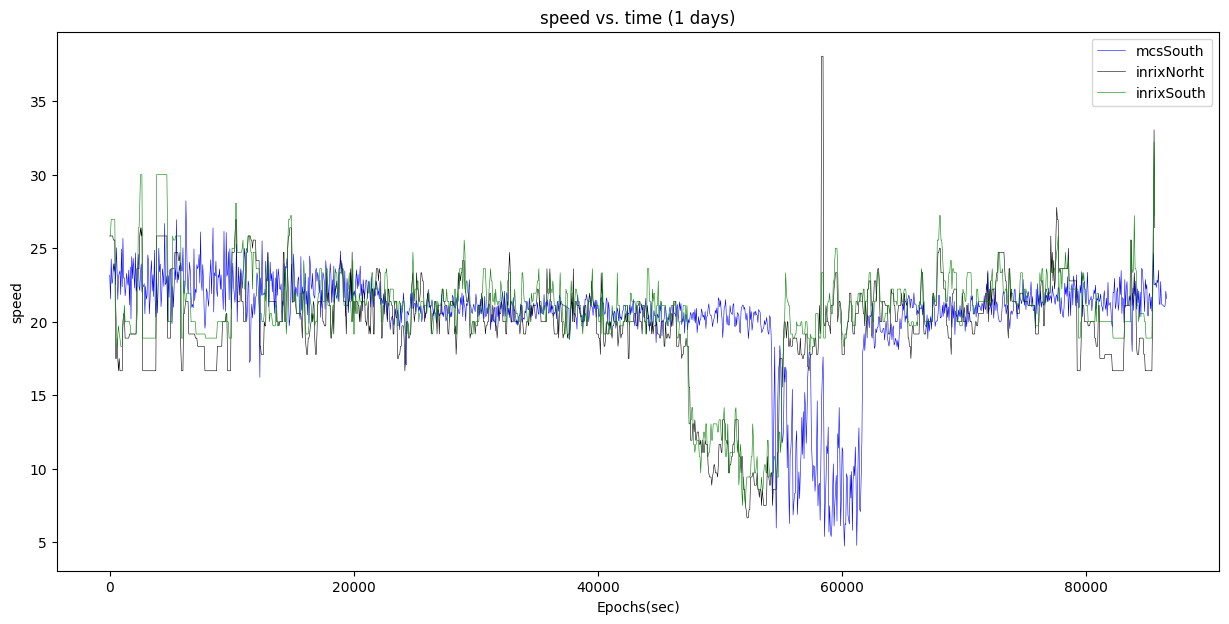

In [21]:
inrixNorth1days = inrixNorth[: round(len(inrixNorth)/31.0)][:]
inrixSouth1days = inrixSouth[: round(len(inrixSouth)/31.0)][:]
mcsSouth1days = mcsSouth[: round(len(mcsSouth)/31)][:]
plt.figure(figsize=( 15, 7))
plotAttr2(1, mcsSouth1days, inrixNorth1days, inrixSouth1days, 'speed', 'mcs', 'inrix', 'inrix', 'South', 'Norht', 'South')

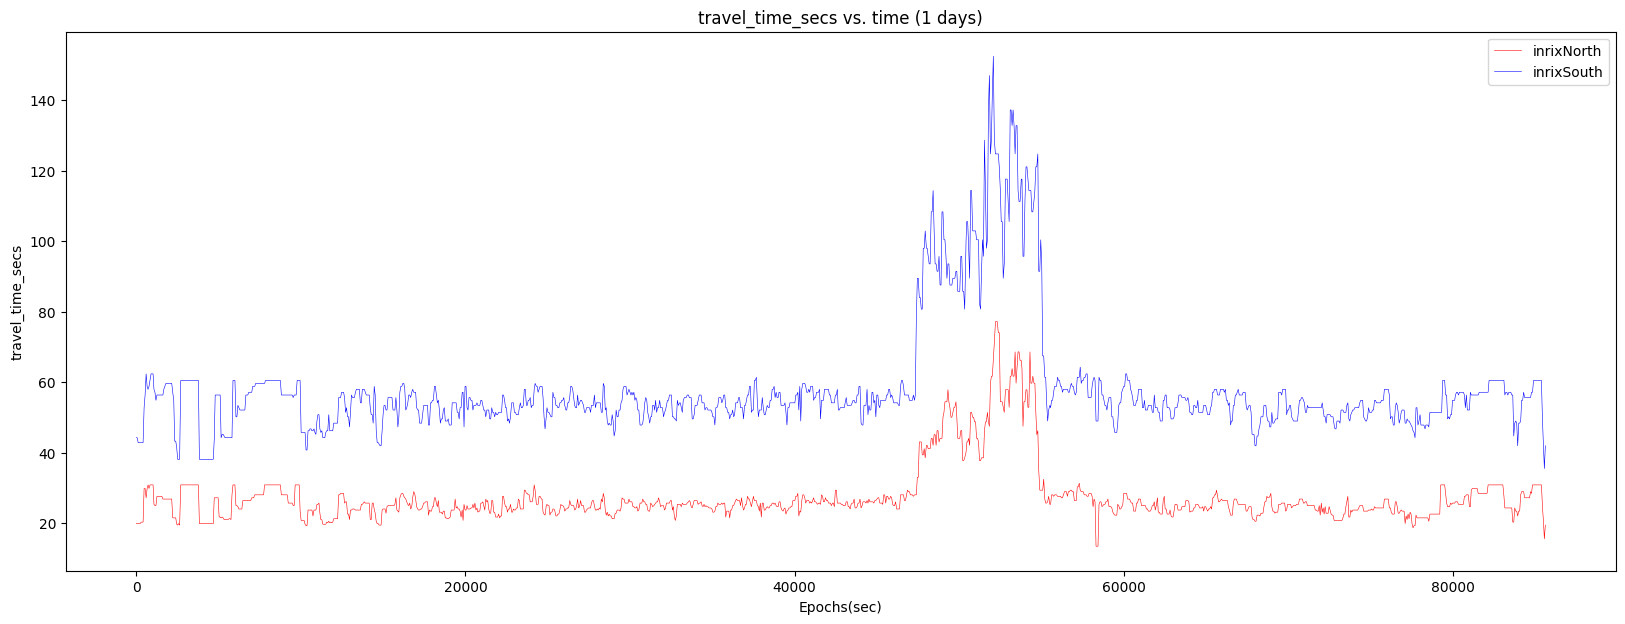

In [22]:
plt.figure(figsize=(20, 7))
plotAttr(1, inrixNorth1days, inrixSouth1days, 'travel_time_secs', 'inrix')

### 2.4.1 Contour plot of speeds in one day for 4 datasets (Inrix/Mcs/South/North)

In [0]:
def preContour(DF1, DF2, DF3, DF4, attribute1, attribute2):
  result = DF1[attribute1].append([DF2[attribute1], DF3[attribute2], DF4[attribute2]], ignore_index = True)
  return result.values

In [0]:
# Contour plot for speeds in InrixSouth, InrixNorth, McsSouth, McsNorth
contour_inrix_North = inrixNorth.iloc[:1440][['Epoch_inrix', 'speed']].copy()
contour_inrix_North['type'] = 1

contour_inrix_South = inrixSouth.iloc[:1440][['Epoch_inrix', 'speed']].copy()
contour_inrix_South['type'] = 2

contour_mcs_North = mcsNorth.iloc[:1426][['Epoch_mcs', 'speed']].copy()
contour_mcs_North['type'] = 3

contour_mcs_South = mcsSouth.iloc[:1424][['Epoch_mcs', 'speed']].copy()
contour_mcs_South['type'] = 4

# Prepare X, Y, Z for contour plot
X = preContour(contour_inrix_North, contour_inrix_South, contour_mcs_North, contour_mcs_South, 'Epoch_inrix', 'Epoch_mcs')
#print(X.shape)
#print(type(X))
#print(X)

Y = preContour(contour_inrix_North, contour_inrix_South, contour_mcs_North, contour_mcs_South, 'type', 'type')
#print(Y.shape)
#print(type(Y))
#print(Y)
                                            
Z = preContour(contour_inrix_North, contour_inrix_South, contour_mcs_North, contour_mcs_South, 'speed', 'speed')
#print(Z.shape)
#print(type(Z))
#print(Z)

[1. 2. 3. 4.]
<a list of 4 Text major ticklabel objects>


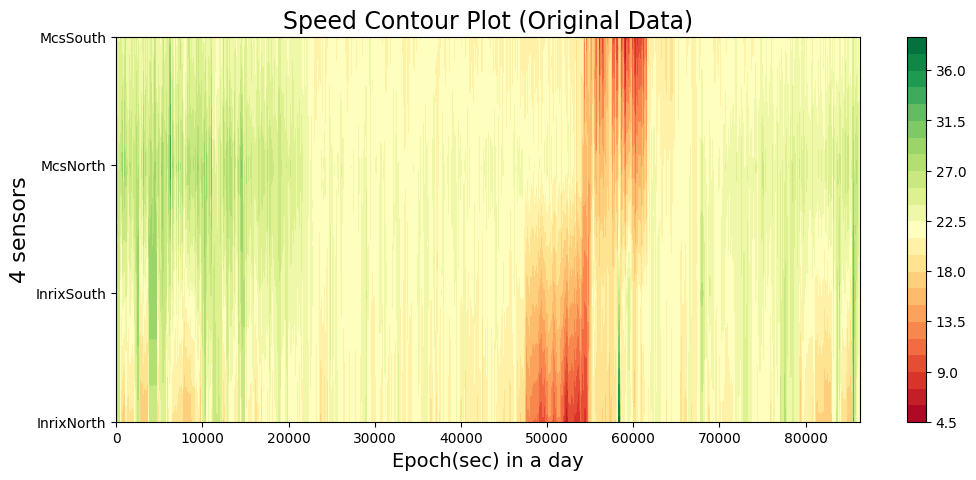

In [25]:
plt.figure(figsize=(12, 5))
plt.style.use('default')
plt.xlabel('Epoch(sec) in a day', fontsize = 14)
plt.ylabel('4 sensors', fontsize = 16)
plt.title('Speed Contour Plot (Original Data)', fontsize = 17)
# plt.ylim(bottom = 0.5, top = 4.5)
plt.tricontourf(X, Y, Z, 25, cmap = 'RdYlGn')
plt.colorbar()
plt.yticks(np.arange(1.0, 5.0, 1.0), ('InrixNorth', 'InrixSouth', 'McsNorth', 'McsSouth'))
loc, labels = plt.yticks()
print(loc)
print(labels)

### 2.4.2 Distribution of density

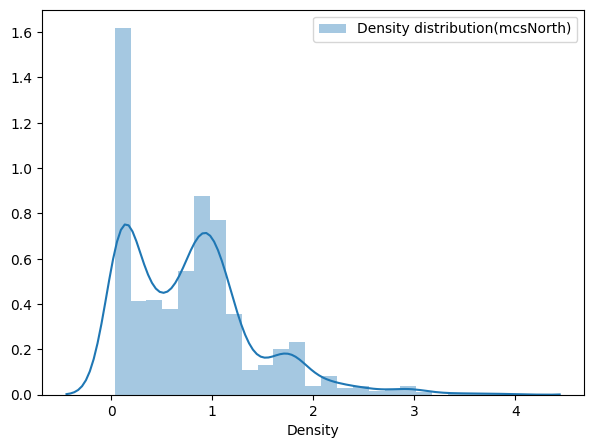

In [26]:
 plt.figure(figsize=(7, 5))
seaborn.distplot(mcsNorth1days['Density'], label='Density distribution(mcsNorth)')
plt.legend()

## 2.5 Correlation among attributes

### 2.5.1 Correlation of Speed and Density wihtin McsSouth and INRIX




In [0]:
def plotScatter(data1, data2, attribute1, attribute2, Label):
  plt.scatter(data1[attribute1], data2[attribute2], s=1.5, label=Label)
  plt.xlabel(attribute1, fontsize = 15)
  plt.xticks(fontsize = 14)
  plt.yticks(fontsize = 14)
  plt.ylabel(attribute2, fontsize = 15)
  plt.title(attribute2 + '  vs. ' + attribute1, fontsize = 20)
  plt.legend()
  plt.show()

            speed   Density
speed    1.000000 -0.895644
Density -0.895644  1.000000


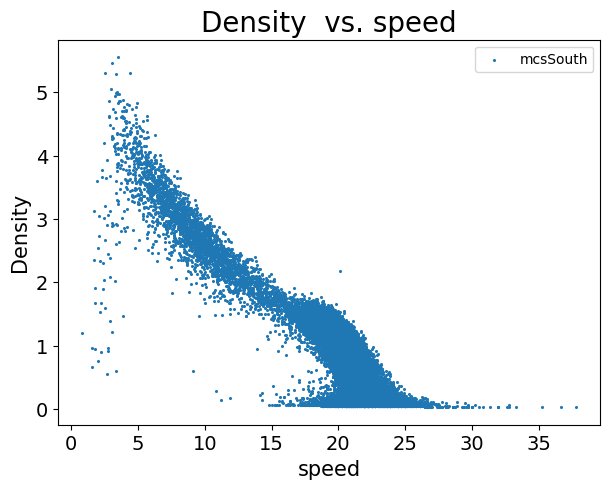

In [28]:
mcsSouthCorr = mcsSouth[['speed', 'Density']].copy()
print(mcsSouthCorr.corr())

plt.figure(figsize=(7,5))
plotScatter(mcsSouth, mcsSouth, 'speed', 'Density', 'mcsSouth')

### 2.5.2 Correlation among McsNorth and McsSouth

In [29]:
spMcsNorth = mcsNorth['speed']
spMcsSouth = mcsSouth['speed']
merge = {'NorthSpeed': spMcsNorth, 'SouthSpeed': spMcsSouth}
speedDf = pd.DataFrame(merge)

speedDf.corr()

NorthSpeed  SouthSpeed
NorthSpeed     1.00000     0.76783
SouthSpeed     0.76783     1.00000

In [30]:
flMcsNorth = mcsNorth['Density']
flMcsSouth = mcsSouth['Density']
merge = {'Northflow': flMcsNorth, 'Southflow': flMcsSouth}
flowDf = pd.DataFrame(merge)
flowDf.corr()

Northflow  Southflow
Northflow   1.000000   0.868759
Southflow   0.868759   1.000000

As correlation of density among north and south Mcs is high, it might be possible to use the regression model trained in mcs north to predict the speed/flow in mcs south. 

### 2.5.3 Correlation of Speed and travel distance in INRIX

In [31]:
spInrix = inrixSouth['speed']
travelTimeInrix = inrixSouth['travel_time_secs']
merge = {'inrixSpeed': spInrix, 'inrixTravelTime': travelTimeInrix}
inrixSouthCorr = pd.DataFrame(merge)
inrixSouthCorr.corr()

inrixSpeed  inrixTravelTime
inrixSpeed         1.000000        -0.893679
inrixTravelTime   -0.893679         1.000000

High negative correlation between speed and travel time, which means they contain similar information

## 3. Prepare the data for machine learning

Polynomial linear regression model for prediction of flow in 9 days based on Epoch.

In [0]:
# function for making polynomial feature columns 
# Input: numpy array with shape(sample number, 1)
def makePoly(deg, X, bias = True):
  poly = PolynomialFeatures(degree = deg,include_bias = bias)
  X_1 = X.reshape(-1, 1)
  X_poly = poly.fit_transform(X_1)
  return X_poly

### 3.1 Prepare label colum and feature columns




In [33]:
# prepare the feature and label columns from mcsSouth
mcsSouth9days = mcsSouth[:12856]
# X = mcsSouth9days['speed'].values
X = mcsSouth9days['Epoch_mcs'].values
Y = mcsSouth9days['Density'].values.reshape(-1, 1)
print(X.shape)
print(Y.shape)
print(X[-1:])
print(Y[:3])

# turn Epocs_mcs into polynomial features: 1, x, x^2, x^3, ...
X = makePoly(20, X)
print(X.shape)
dfRawFeatures = pd.DataFrame(X)
dfRawFeatures.describe()

(12856,)
(12856, 1)
[777480.]
[[0.15826769]
 [0.07735783]
 [0.13737773]]
(12856, 21)


0              1   ...             19             20
count  12856.0   12856.000000  ...   1.285600e+04   1.285600e+04
mean       1.0  389141.364343  ...  4.211148e+110  3.119005e+116
std        0.0  224369.282496  ...  1.279821e+111  9.729767e+116
min        1.0       0.000000  ...   0.000000e+00   0.000000e+00
25%        1.0  195165.000000  ...  3.293352e+100  6.427472e+105
50%        1.0  389490.000000  ...  1.657412e+106  6.455453e+111
75%        1.0  583155.000000  ...  3.547286e+109  2.068618e+115
max        1.0  777480.000000  ...  8.377131e+111  6.513052e+117

[8 rows x 21 columns]

### 3.2 Scaling the feature columns

In [0]:
# funtion for normalizing the feature columns
# Input: X: Numpy array
def normalize(X, Scaler=None):
  # remove the bias column
  X_1 = np.delete(X, 0, 1)

  # scale the remaining feature columns
  scaler = None
  X_2 = None

  if(Scaler==None):
    scaler = StandardScaler()
    X_2 = scaler.fit_transform(X_1)
  else:
    scaler = Scaler
    X_2 = scaler.transform(X_1)

  # add the bias column back to the features columns
  ones = np.ones((len(X_2), 1))
  X_scaled = np.append(ones, X_2, 1)
  
  return X_scaled, scaler

In [35]:
# Scale the feature columns
X, scaler1month = normalize(X)
dfScaled = pd.DataFrame(X)
dfScaled.describe()

0             1   ...            19            20
count  12856.0  1.285600e+04  ...  1.285600e+04  1.285600e+04
mean       1.0 -3.531884e-16  ... -2.942126e-15 -2.436895e-15
std        0.0  1.000039e+00  ...  1.000039e+00  1.000039e+00
min        1.0 -1.734446e+00  ... -3.290547e-01 -3.205756e-01
25%        1.0 -8.645743e-01  ... -3.290547e-01 -3.205756e-01
50%        1.0  1.553908e-03  ... -3.290417e-01 -3.205690e-01
75%        1.0  8.647404e-01  ... -3.013366e-01 -2.993141e-01
max        1.0  1.730869e+00  ...  6.216747e+00  6.373629e+00

[8 rows x 21 columns]

### 3.3 Split training and testing datasets

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(10284, 21)
(10284, 1)
(2572, 21)
(2572, 1)


## 4. Make the model

In [0]:
def model(X_train, Y_train):
  regressor = LinearRegression(fit_intercept=False)
  regressor.fit(X_train, Y_train)
  return regressor

### 4.1 Build and train theregression model

In [38]:
regressor = model(X_train, Y_train)
print('Coefficients: ', regressor.coef_)

Coefficients:  [[ 8.13962457e-01  8.10621549e+01 -9.42829011e+03  4.43341018e+05
  -1.08202047e+07  1.60340344e+08 -1.58545282e+09  1.11048448e+10
  -5.73172835e+10  2.23910003e+11 -6.73963090e+11  1.58064563e+12
  -2.90479117e+12  4.18479867e+12 -4.70265710e+12  4.07493031e+12
  -2.66783673e+12  1.27545735e+12 -4.19928554e+11  8.50732986e+10
  -7.99068056e+09]]


### 4.2 Evaluation of the model on training dataset 

In [39]:
Y_predict_train = regressor.predict(X_train)
print("Root Mean Square Error: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score: ", r2_score(Y_train, Y_predict_train))

Root Mean Square Error:  0.685539562083837
R2 Score:  0.2024218626408535


### 4.3 Evaluation of the model on test dataset

In [40]:
Y_predict_test = regressor.predict(X_test)
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score: ", r2_score(Y_test, Y_predict_test))

Root Mean Square Error:  0.7018266449486783
R2 Score:  0.18662314655671186


### 4.4 Plot the result of the predition

In [0]:
def plotResult(xTrain, yTrain, yPredTrain, xTest, yTest, yPredTest, timeRange, xlabel):
  if (xTest is not None):
    plt.scatter(xTrain, yTrain, s=2, color='black', label='real flow(train_set)')
    plt.scatter(xTrain, yPredTrain, s= 30, color='blue', marker = "s", label='predicted flow(train_set)')
    plt.scatter(xTest, yTest, color='red', s=2, label='real flow(test_set)')
    plt.scatter(xTest, yPredTest, color='green', s=30, marker = 's', label='predicted flow(test_set)')
  else:
    plt.plot(xTrain, yPredTrain, linewidth=0.5, color='blue', label='predicted flow', zorder= 0)
    # plt.scatter(xTrain, yPredTrain, s=1.0, color='blue', label='predicted flow', zorder= 10)
    plt.scatter(xTrain, yTrain, s=1.5, color='red', label='real flow', zorder= 10)
  plt.xlabel(xlabel, fontsize= 16) 
  plt.xticks(fontsize = 14)
  plt.ylabel('density', fontsize=16)
  plt.yticks(fontsize = 14)
  plt.title('Regression model for prediction of density in ' + timeRange, fontsize= 20)
  plt.legend(fontsize=15)
  plt.show()

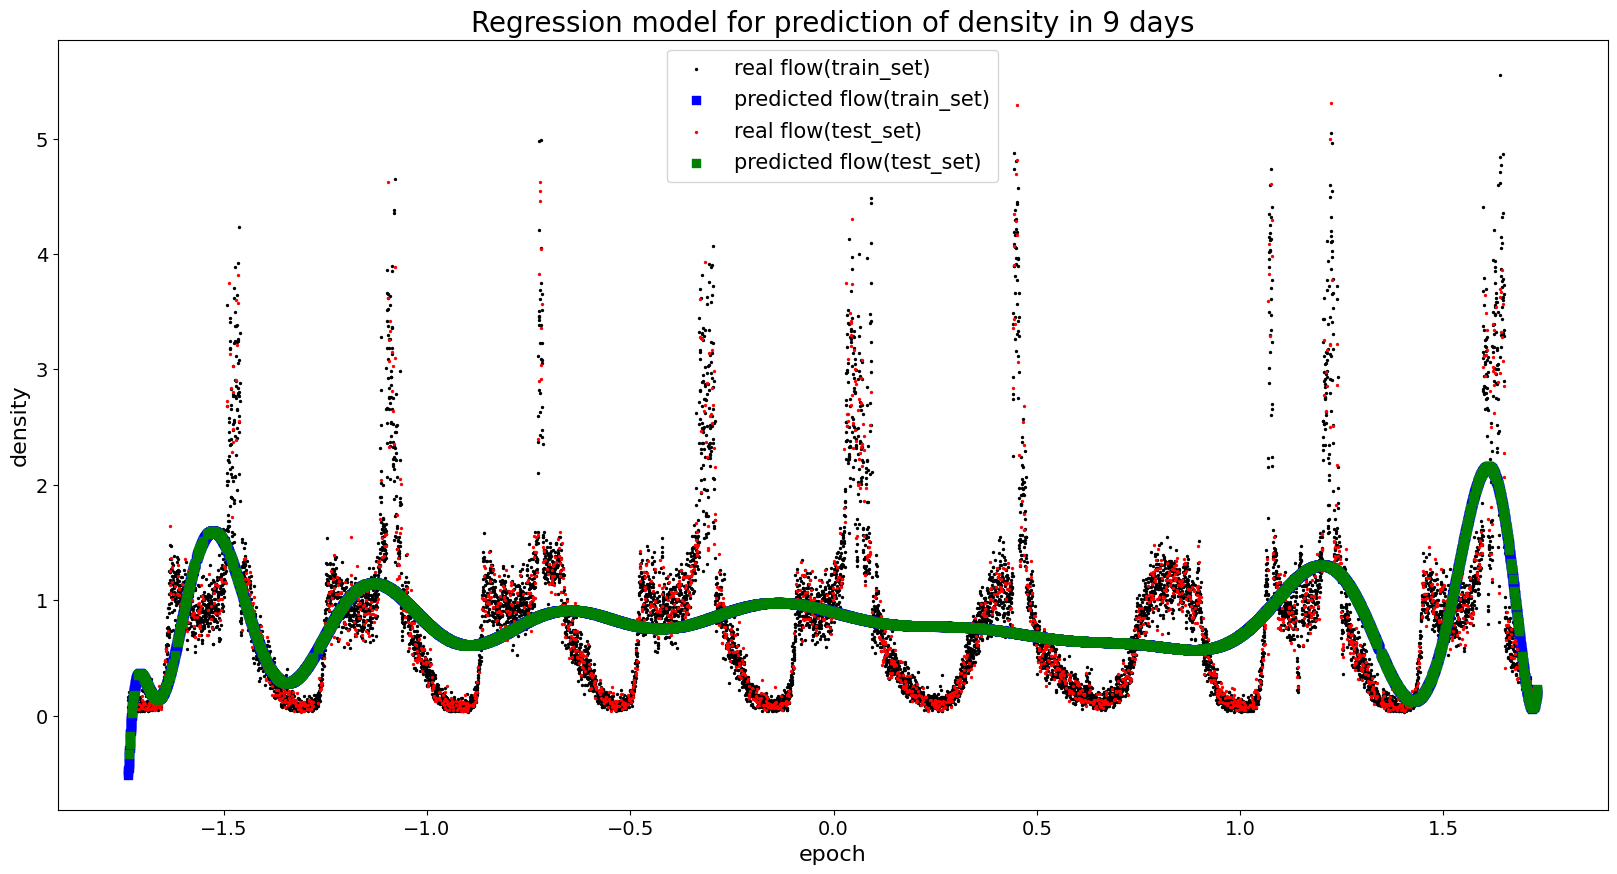

In [42]:
# Plot real and predicted flow from X_train
plt.figure(figsize=(20, 10))
plotResult(X_train[:, 1], Y_train[:, 0], Y_predict_train[:, 0], 
           X_test[:, 1], Y_test[:, 0], Y_predict_test[:, 0], '9 days', 'epoch')


Summary for the prediction of density based on the epoch(time) in a month range: 
1. The accuracy of density prediction over 9 days is very low (R2: 0.25, RMSE: 450) when using polynomial regression with time Epoch (x, x^2, x^3, ...) as features.
2. It is difficultto use linear regression to capture the behavior of density over a month as it is not a linear function of time.
3. We might be able to use polynomial regression to predict the flow in an one day range by using high degree polynomial order and get a good accuracy, but it would not be a useful model. Since the flow behavior is dynamic, model trained by one day probably will not work well on another day, i.e., it doesn't generalize well. (Proof to be continue)

## 5. Polynomial Regression for prediction in one day

### 5.1 Polynomial regression model trained on first day's Epoch data (1st. Oct) for prediction of density.

In [43]:
# prepare the feature and label columns from mcsSouth
mcsSouth24Hour = mcsSouth[:round(len(mcsSouth)/31)-4][:]
print(mcsSouth24Hour[:][-1:])
X = mcsSouth24Hour['Epoch_mcs'].values
Y = mcsSouth24Hour['Density'].values.reshape(-1, 1)

# turn Epocs_mcs into polynomial features: 1, x, x^2, x^3, ...
X = makePoly(14, X)
dfRawFeatures = pd.DataFrame(X)
dfRawFeatures.describe()

      fk_id                 date    speed  ...  used_lanes  Epoch_mcs   Density
1423   1162  2018-10-01 23:56:00  21.2137  ...   {1,1,1,1}    86160.0  0.094279

[1 rows x 8 columns]


0             1   ...            13            14
count  1424.0   1424.000000  ...  1.424000e+03  1.424000e+03
mean      1.0  43192.963483  ...  1.043770e+63  8.396504e+67
std       0.0  24956.824157  ...  2.599054e+63  2.172694e+68
min       1.0      0.000000  ...  0.000000e+00  0.000000e+00
25%       1.0  21525.000000  ...  2.129660e+56  4.584178e+60
50%       1.0  43470.000000  ...  1.979163e+60  8.603473e+64
75%       1.0  64815.000000  ...  3.562766e+62  2.309212e+67
max       1.0  86160.000000  ...  1.442029e+64  1.242452e+69

[8 rows x 15 columns]

In [44]:
# Scale the feature columns
X, scaler = normalize(X)
dfScaled = pd.DataFrame(X)
dfScaled.describe()

0             1   ...            13            14
count  1424.0  1.424000e+03  ...  1.424000e+03  1.424000e+03
mean      1.0  2.473053e-16  ...  1.528116e-16  2.569730e-16
std       0.0  1.000351e+00  ...  1.000351e+00  1.000351e+00
min       1.0 -1.731316e+00  ... -4.017371e-01 -3.865917e-01
25%       1.0 -8.685230e-01  ... -4.017370e-01 -3.865917e-01
50%       1.0  1.110453e-02  ... -4.009753e-01 -3.861956e-01
75%       1.0  8.666821e-01  ... -2.646096e-01 -2.802710e-01
max       1.0  1.722260e+00  ...  5.148496e+00  5.333905e+00

[8 rows x 15 columns]

In [45]:
# Split the training and test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Build model
regressor = model(X_train, Y_train)

# Evaluate Performance of training
Y_predict_train = regressor.predict(X_train)
print("Root Mean Square Error: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score: ", r2_score(Y_train, Y_predict_train))

Root Mean Square Error:  0.3119334942363904
R2 Score:  0.8051031006423803


In [46]:
# Evaluate Performance of testing
Y_predict_test = regressor.predict(X_test)
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score: ", r2_score(Y_test, Y_predict_test))

Root Mean Square Error:  0.2997271396736683
R2 Score:  0.8159996004247385


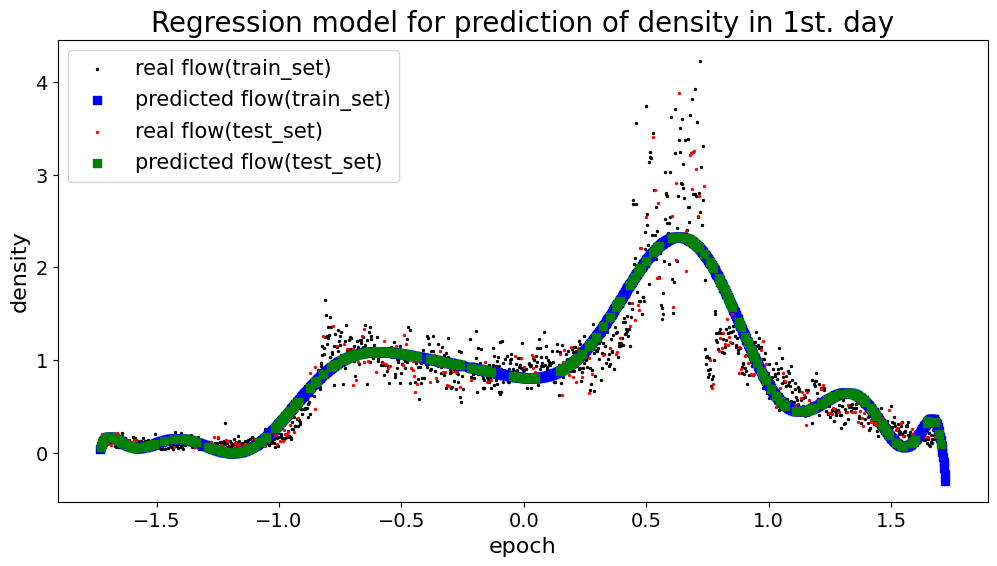

In [47]:
# Plot real and predicted flow from X_train
plt.figure(figsize=(12, 6))
plotResult(X_train[:, 1], Y_train[:, 0], Y_predict_train[:, 0], 
           X_test[:, 1], Y_test[:, 0], Y_predict_test[:, 0], '1st. day', 'epoch')

### 5.2 Test the prediction model on 7th of Oct.

In [48]:
mcsSouth3rdDay = mcsSouth[8562:9998][:]
mcsSouth3rdDay

fk_id                 date    speed  ...       used_lanes  Epoch_mcs   Density
8562   1162  2018-10-07 00:00:00  22.7097  ...        {1,1,1,1}   518400.0  0.198153
8563   1162  2018-10-07 00:01:00  22.8753  ...        {1,1,1,1}   518460.0  0.360651
8564   1162  2018-10-07 00:02:00  21.1978  ...        {1,1,1,1}   518520.0  0.224080
8565   1162  2018-10-07 00:03:00  23.9900  ...        {1,1,1,1}   518580.0  0.197999
8566   1162  2018-10-07 00:04:00  21.6546  ...        {1,1,1,1}   518640.0  0.219353
...     ...                  ...      ...  ...              ...        ...       ...
9993   1162  2018-10-07 23:52:00  21.8115  ...     {1,1,1,NULL}   604320.0  0.198672
9994   1162  2018-10-07 23:53:00  21.9678  ...  {1,1,NULL,NULL}   604380.0  0.159324
9995   1162  2018-10-07 23:54:00  21.3262  ...        {1,1,1,1}   604440.0  0.093781
9996   1162  2018-10-07 23:55:00  21.7185  ...        {1,1,1,1}   604500.0  0.195686
9997   1162  2018-10-07 23:56:00  23.6670  ...     {1,1,1,NULL}   604560.0  0.169012

[1436 rows x 8 columns]

In [49]:
X_3rd = mcsSouth3rdDay[:]['Epoch_mcs'].values
Y_3rd = mcsSouth3rdDay[:]['Density'].values.reshape(-1, 1)
X_3rd = X_3rd - 518400.0
X_3rd = makePoly(14, X_3rd)
X_3rd, scalerdummy = normalize(X_3rd, scaler)
dfX_3rd = pd.DataFrame(X_3rd)
dfX_3rd.describe()

0            1            2   ...           12           13           14
count  1436.0  1436.000000  1436.000000  ...  1436.000000  1436.000000  1436.000000
mean      1.0    -0.005427    -0.006704  ...    -0.004241    -0.004027    -0.003834
std       0.0     0.997768     0.997506  ...     0.996800     0.996775     0.996751
min       1.0    -1.731316    -1.120543  ...    -0.418810    -0.401737    -0.386592
25%       1.0    -0.868523    -0.911874  ...    -0.418810    -0.401737    -0.386592
50%       1.0    -0.005730    -0.285867  ...    -0.417509    -0.401066    -0.386246
75%       1.0     0.857062     0.757478  ...    -0.249975    -0.271066    -0.285652
max       1.0     1.722260     2.222815  ...     4.955884     5.148496     5.333905

[8 rows x 15 columns]

In [50]:
# Evaluate Performance of training
Y_predict_3rd = regressor.predict(X_3rd)
print("Root Mean Square Error: ", mean_squared_error(Y_3rd, Y_predict_3rd, squared=False))
print("R2 Score: ", r2_score(Y_3rd, Y_predict_3rd))

Root Mean Square Error:  0.5116691228683519
R2 Score:  -0.4184809002527765


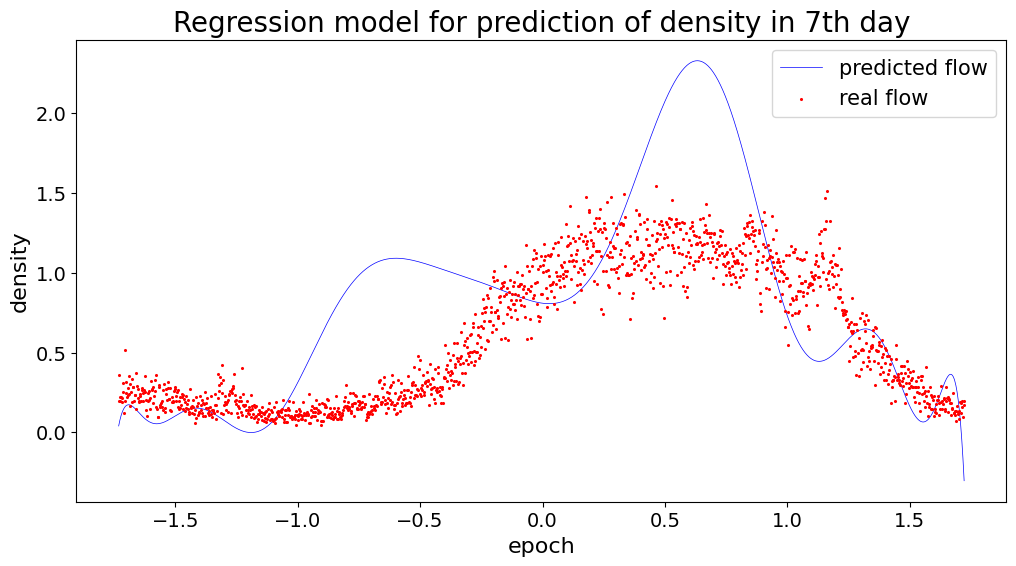

In [51]:
# Plot real and predicted flow from X_train
plt.figure(figsize=(12, 6))
plotResult(X_3rd[:, 1], Y_3rd[:, 0], Y_predict_3rd[:, 0], 
           None, None, None, '7th day', 'epoch')

The model trained by 1st.Oct's data performs badly when predicting flow on 7th Oct, which means that the model doesn't generalize well. The 2nd reason why it is difficult to use linear regression model to predict flow is because the traffic flow is very dynamic and its behavior changes every day.

## 6. Add a new feature "speed" into regression model

### 6.1 Include "Speed" as a new feature in feature columns

In [0]:
# prepare the feature and label columns from mcsSouth's 9days data
# print(mcsSouth9days[:][-1:])
X_epoch = mcsSouth9days['Epoch_mcs'].values
X_speed = mcsSouth9days['speed'].values
Y_label = mcsSouth9days['Density'].values.reshape(-1, 1)

# turn Epocs_mcs into polynomial features: 1, t, t^2, t^3, ...
X_epoch_poly = makePoly(20, X_epoch) # output: np Array
X_epoch_poly, scaler_epoch_9 = normalize(X_epoch_poly)
# dfRawFeatures = pd.DataFrame(X_epoch_poly)
# dfRawFeatures.describe()


In [0]:
# turn speed into polynomial features: 1, s, s^2, s^3, ...
X_speed_poly = makePoly(20, X_speed)
X_speed_poly, scaler_speed_9 = normalize(X_speed_poly)
# dfRawFeatures_speed = pd.DataFrame(X_speed_poly)
# dfRawFeatures_speed.describe()

In [54]:
# remove the bias column of speed feature and merge with the epoch feature columns
# X_speed_poly = np.delete(X_speed_poly, 0, 1)
print(X_speed_poly.shape)
# print(X_epoch_poly.shape)
# X_features = np.append(X_epoch_poly, X_speed_poly,axis=1)
X_features = X_speed_poly
dfRawFeatures = pd.DataFrame(X_features)
dfRawFeatures.describe()

(12856, 21)


0             1   ...            19            20
count  12856.0  1.285600e+04  ...  1.285600e+04  1.285600e+04
mean       1.0 -1.471036e-14  ... -1.389938e-17  8.227792e-17
std        0.0  1.000039e+00  ...  1.000039e+00  1.000039e+00
min        1.0 -4.830481e+00  ... -5.691069e-02 -4.470025e-02
25%        1.0 -3.886546e-02  ... -5.002701e-02 -4.049160e-02
50%        1.0  1.987598e-01  ... -4.134907e-02 -3.476862e-02
75%        1.0  4.618412e-01  ... -1.998945e-02 -2.004039e-02
max        1.0  3.530204e+00  ...  1.032267e+02  1.047053e+02

[8 rows x 21 columns]

In [0]:
# split training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=0)

In [56]:
# Build the regression model
regressor = model(X_train, Y_train)

# Evaluate Performance of training set
Y_predict_train = regressor.predict(X_train)
print("Root Mean Square Error: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score: ", r2_score(Y_train, Y_predict_train))

Root Mean Square Error:  0.2933139244713334
R2 Score:  0.853993040604669


In [57]:
# Evaluate Performance of testing set
Y_predict_test = regressor.predict(X_test)
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score: ", r2_score(Y_test, Y_predict_test))

Root Mean Square Error:  0.28790302848607907
R2 Score:  0.8631248615497948


Testset's R2 is larger than Trainset's R2: did not over fitting

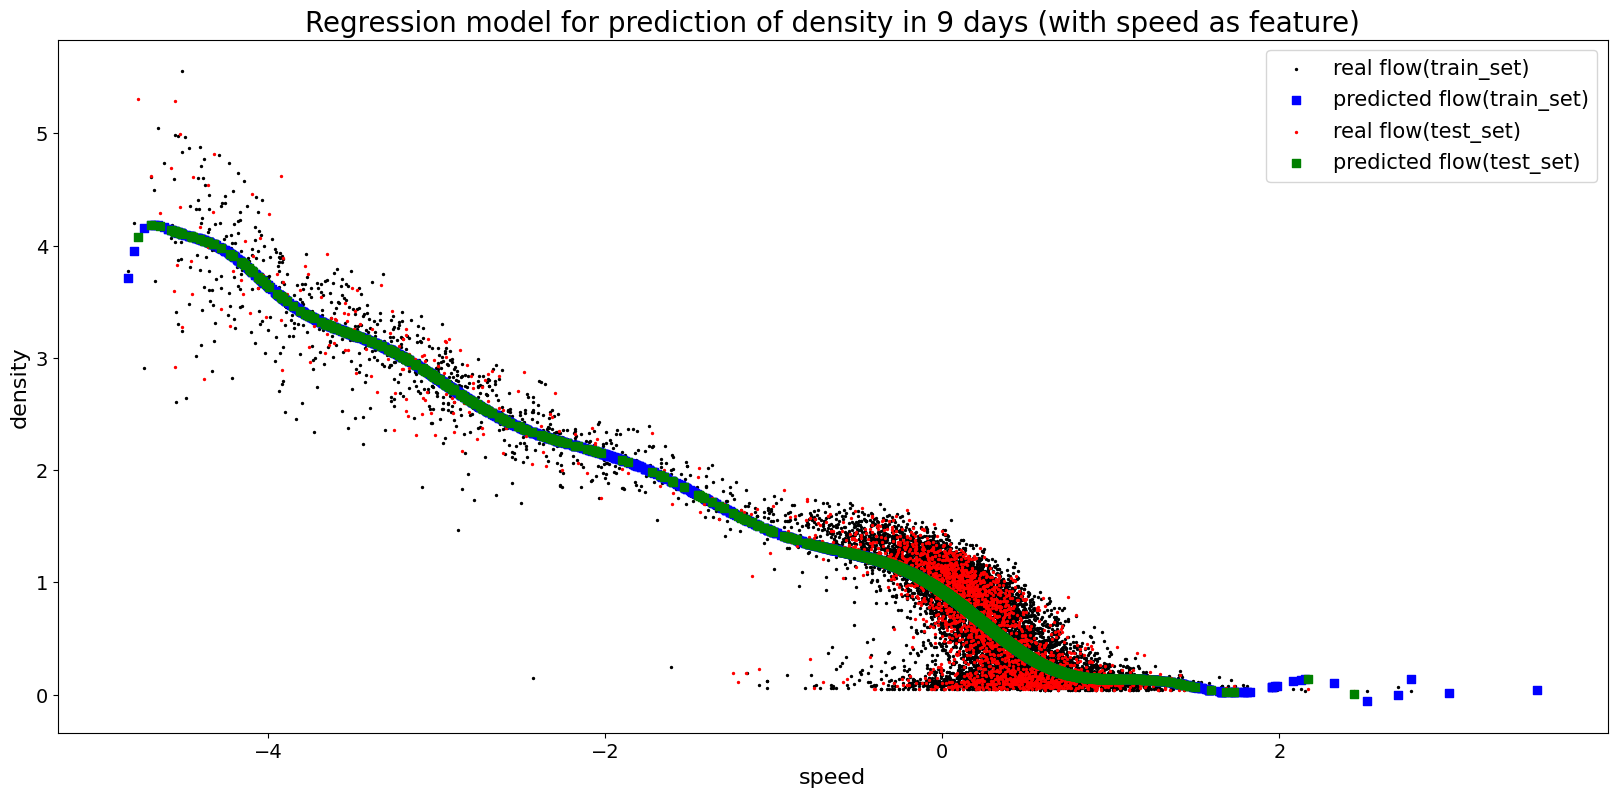

In [58]:
# Plot real and predicted flow from X_train, X_test
plt.figure(figsize=(20, 9))
plotResult(X_train[:, 1], Y_train[:, 0], Y_predict_train[:, 0], 
           X_test[:, 1], Y_test[:, 0], Y_predict_test[:, 0], '9 days (with speed as feature)', 'speed')

In [59]:
# Use all data to train and predict the flow
Y_predict = regressor.predict(X_features)
print("Root Mean Square Error: ", mean_squared_error(Y_label, Y_predict, squared=False))
print("R2 Score: ", r2_score(Y_label, Y_predict))

Root Mean Square Error:  0.2922394259218212
R2 Score:  0.8558608795838112


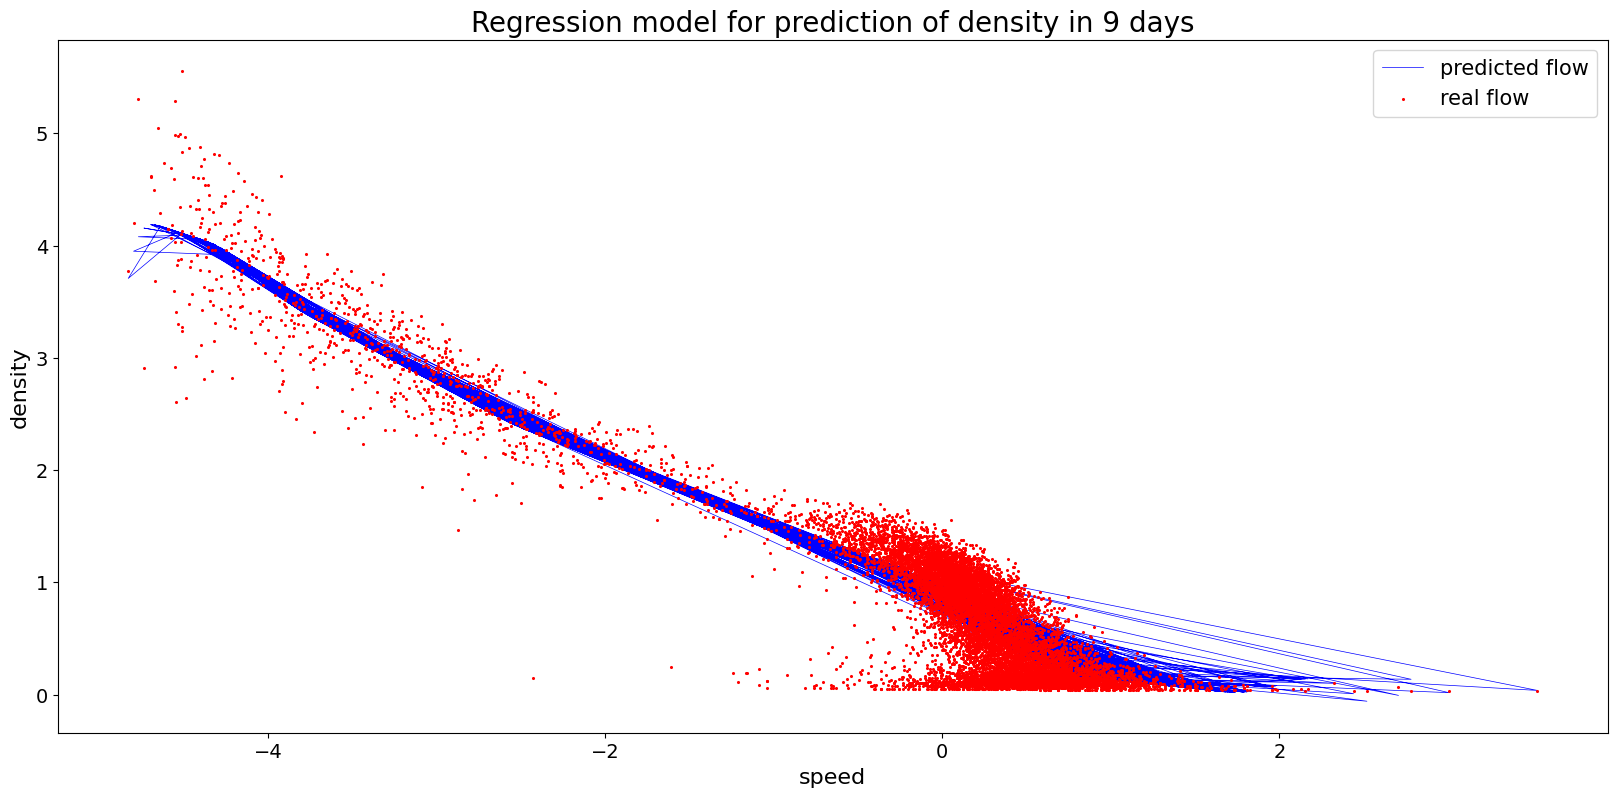

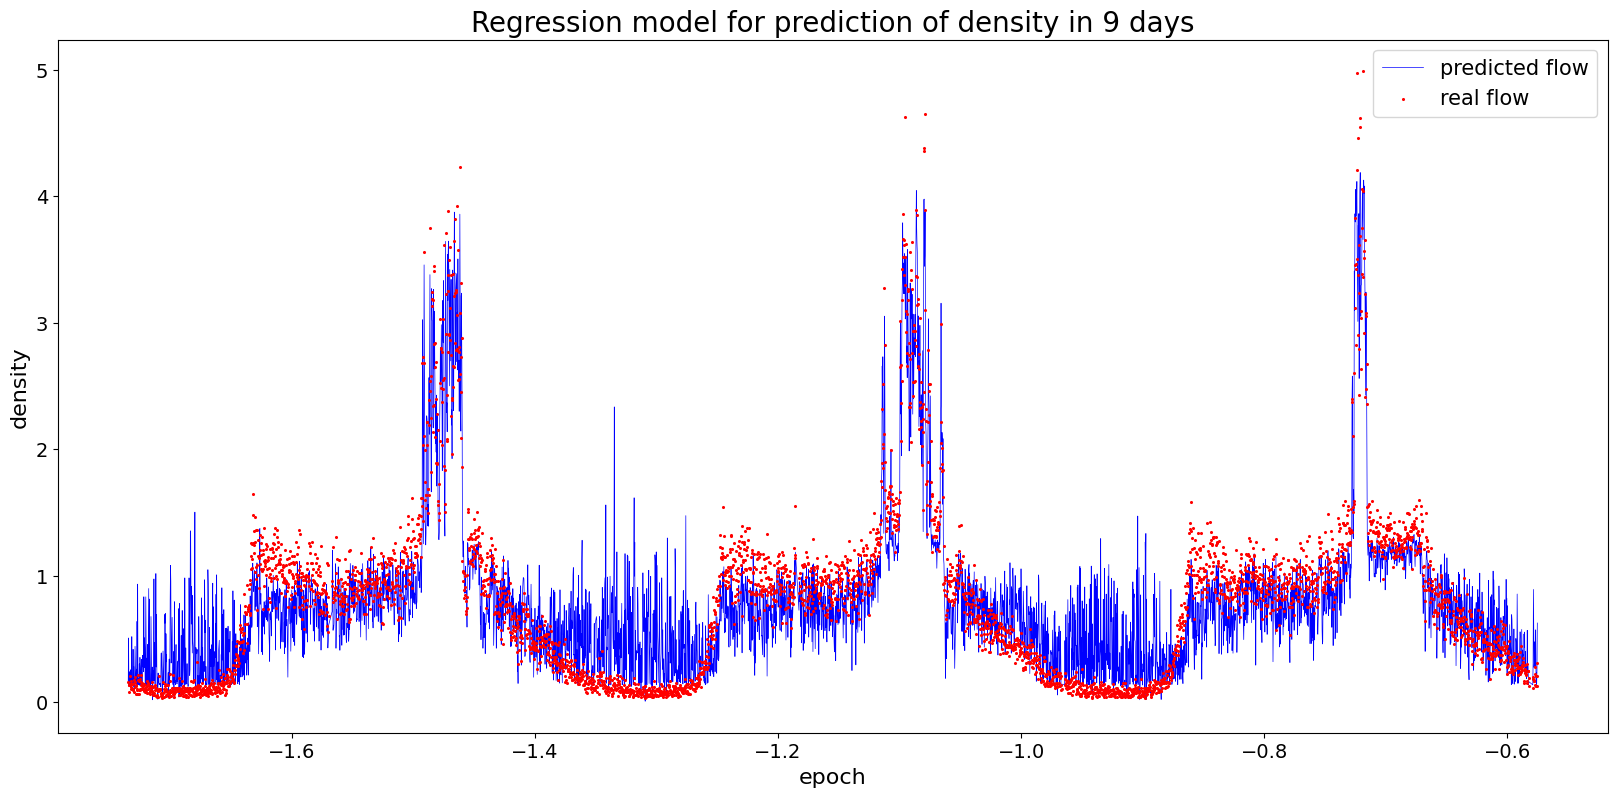

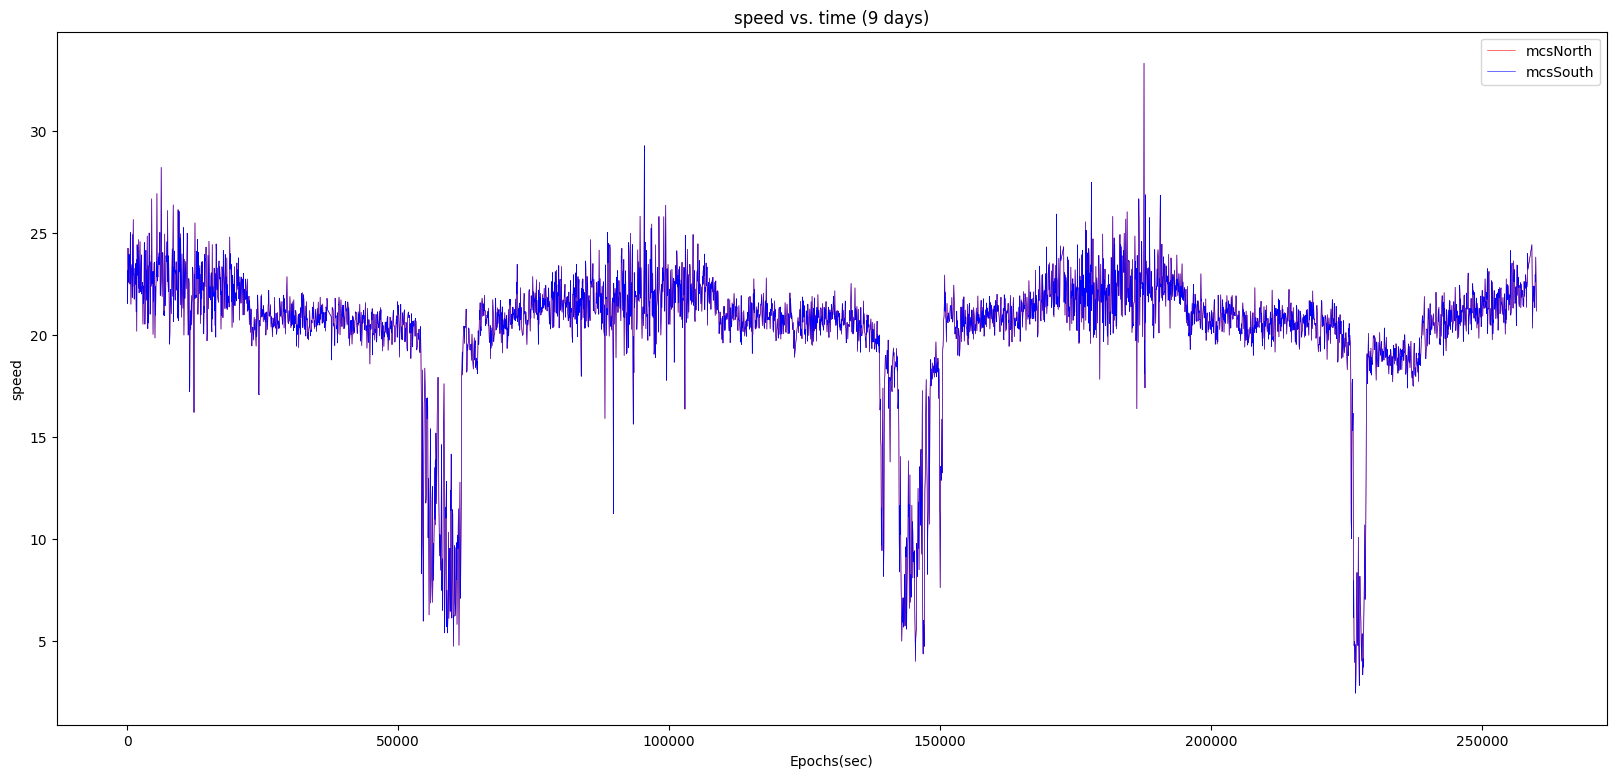

In [60]:
# Plot real and predicted flow from X_features
plt.figure(figsize=(20, 9))
plotResult(X_features[:, 1], Y_label[:, 0], Y_predict[:, 0], 
           None, None, None, '9 days', 'speed')

plt.figure(figsize=(20, 9))
plotResult(X_epoch_poly[:round(len(X_epoch_poly)/3), 1], Y_label[:round(len(X_epoch_poly)/3), 0], Y_predict[:round(len(X_epoch_poly)/3), 0], 
           None, None, None, '9 days', 'epoch')

plt.figure(figsize=(20, 9))
plotAttr(9, mcsSouth9days.iloc[:round(len(mcsSouth9days)/3)], mcsSouth9days.iloc[:round(len(mcsSouth9days)/3)],'speed', 'mcs')

Conclusion: By introducing “speed” as a feature, we can effectively increase accuracy of prediction, because the relation between flow and speed, i.e., f(speed) = flow, is closer to a linear function. However, speed itself still cannot provide all information about flow, e.g., in the morning rush hours flow can increase really fast while speed still keeps the similar value. That is to say, we need to find other features to provide more information about flow and make more accurate predictions.

## 7. Using microscopic data in Inrix to predict macroscopic data in Mcs

### 7.1 Data processing for missing timesteps
There are many timesteps missing in mcs and inrix bacause data with low confidence were filtered out, e.g., {Null, Null, Null, Null} was filtered out in mcs. We need to match the Inrix timesteps to mcs timesteps for further processing, such as using 'speed' and 'travel time' from Inrix as features to predict mcs flow.




In [0]:
# function to match inrix timesteps to mcs, and merge them
# Input: mcs dataframe, inrix dataframe
# output: return a new dataframe combines both dataframes after the time-step matching
def matchTimeStep (mcsDf, inrixDf):
  mcsMatched = pd.DataFrame(columns = mcsDf.columns)
  inrixMatched = pd.DataFrame(columns = inrixDf.columns)
  print(mcsMatched)
  print(inrixMatched)
  i = 0;
  j = 0;
  while ((j < len(inrixDf)) & (i < len(mcsDf))):
    mcsEpoch = mcsDf.iloc[i]['Epoch_mcs']
    inrixEpoch = inrixDf.iloc[j]['Epoch_inrix']
    # if the difference in epoch between mcs and inrix is smaller than 25 sec,
    # they are in the same time step (within same min interval)
    if (abs(inrixEpoch - mcsEpoch) < 26.0 ):
      mcsMatched = mcsMatched.append(mcsDf.iloc[i], ignore_index = True)
      inrixMatched = inrixMatched.append(inrixDf.iloc[j], ignore_index = True)
      i += 1;
      j += 1;
      if(i % 1000.0 == 0): print(mcsMatched)
    elif ((inrixEpoch - mcsEpoch) < 0.0):
      j += 1;
      print('missing mcs', j)
    elif ((inrixEpoch -mcsEpoch) > 0.0):
      i +=1;
      print('missing inrix', i)
  
  print('length of mcsMatched: ', len(mcsMatched))
  print('length of inrixMatched: ', len(inrixMatched))

  print(inrixMatched.columns)
  inrixMatched.rename(columns = {'speed': 'speed_inrix'}, inplace = True)
  print(inrixMatched.columns)
  
  combinedDf = pd.concat([mcsMatched, inrixMatched], axis=1)
  print('length of combined df:', len(combinedDf))
  
  return combinedDf
  

In [62]:
# Match the timesteps between mcsSouth and inrixSouth dataframe,
# and merge them into a datafram
combinedSouth = matchTimeStep(mcsSouth, inrixSouth)

Empty DataFrame
Columns: [fk_id, date, speed, speed_std_dev, flow, used_lanes, Epoch_mcs, Density]
Index: []
Empty DataFrame
Columns: [segmentid, timestamputc, speed, average, Epoch_inrix, travel_time_secs]
Index: []
missing mcs 109
missing mcs 135
missing mcs 197
missing mcs 618
missing mcs 619
missing mcs 620
missing mcs 621
missing mcs 622
missing mcs 623
missing mcs 624
missing mcs 625
missing mcs 626
missing mcs 627
    fk_id                 date     speed  ...    used_lanes Epoch_mcs   Density
0    1162  2018-10-01 00:00:00  23.16750  ...  {1,1,1,NULL}       0.0  0.158268
1    1162  2018-10-01 00:01:00  21.54490  ...  {1,1,1,NULL}      60.0  0.077358
2    1162  2018-10-01 00:02:00  24.26400  ...  {1,1,1,NULL}     120.0  0.137378
3    1162  2018-10-01 00:03:00  22.58720  ...  {1,1,1,NULL}     180.0  0.132819
4    1162  2018-10-01 00:04:00  22.77210  ...  {1,1,1,NULL}     240.0  0.204929
..    ...                  ...       ...  ...           ...       ...       ...
995  1162  2018

### 7.2 Analyse correlation between mcsSouth and inrixSouth after timestep matching

In [63]:
# Check the datatype after combining, cast the datatypes to the original types
print(combinedSouth.info())
print(mcsSouth.info())
print(inrixSouth.info())
combinedSouth = combinedSouth.astype({'fk_id':'int64', 'flow':'int64', 'segmentid':'int64', 'Epoch_inrix':'int64'})
combinedSouth.info()
# combinedSouth.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43901 entries, 0 to 43900
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fk_id             43901 non-null  object 
 1   date              43901 non-null  object 
 2   speed             43901 non-null  float64
 3   speed_std_dev     43901 non-null  float64
 4   flow              43901 non-null  object 
 5   used_lanes        43901 non-null  object 
 6   Epoch_mcs         43901 non-null  float64
 7   Density           43901 non-null  float64
 8   segmentid         43901 non-null  object 
 9   timestamputc      43901 non-null  object 
 10  speed_inrix       43901 non-null  float64
 11  average           43901 non-null  float64
 12  Epoch_inrix       43901 non-null  object 
 13  travel_time_secs  43901 non-null  float64
dtypes: float64(7), object(7)
memory usage: 4.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44275 entries, 0 to 44274
Data c

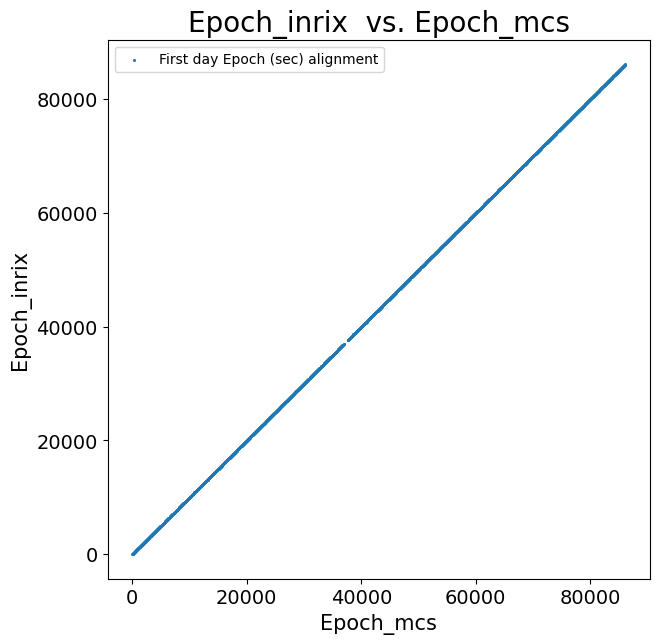

In [64]:
# draw plot of epoch_mcs vs. epoch_inrix after timestep matching
plt.figure(figsize = (7, 7))
combinedSouth1day = combinedSouth.iloc[:1424]
plotScatter(combinedSouth1day, combinedSouth1day, 'Epoch_mcs', 'Epoch_inrix','First day Epoch (sec) alignment')

In [65]:
combinedSouth.iloc[38517: 38520]

fk_id                 date  ...  Epoch_inrix  travel_time_secs
38517   1162  2018-10-27 23:48:00  ...      2332077             60.54
38518   1162  2018-10-27 23:49:00  ...      2332136             60.54
38519   1162  2018-10-28 00:00:00  ...      2332812             58.86

[3 rows x 14 columns]

             speed_inrix     speed
speed_inrix     1.000000  0.300486
speed           0.300486  1.000000


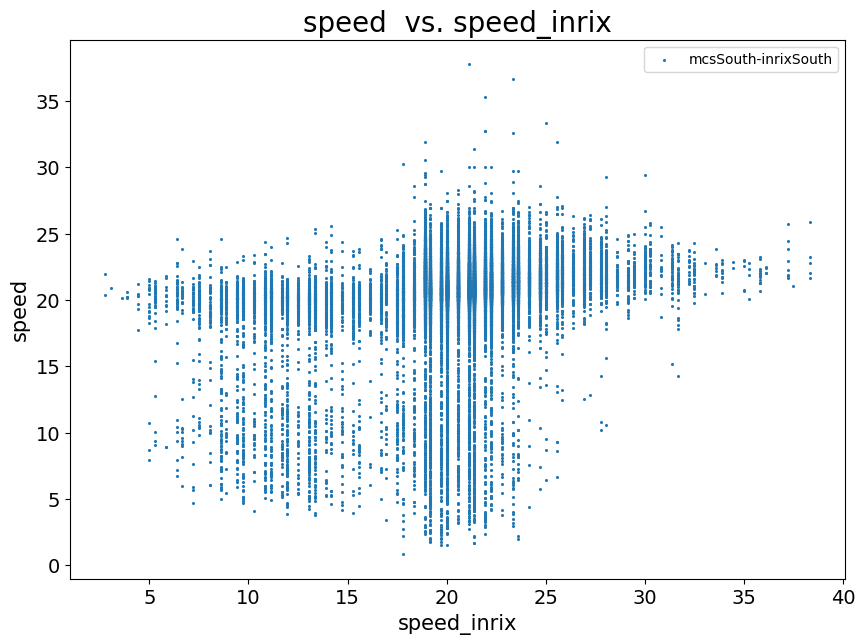

In [66]:
# draw plot of Speed_mcs vs. Speed_inrix after timestep matching
combinedCorr1 = combinedSouth.iloc[:38519][['speed_inrix', 'speed']].copy()
print(combinedCorr1.corr())

plt.figure(figsize=(10,7))
plotScatter(combinedCorr1, combinedCorr1, 'speed_inrix', 'speed', 'mcsSouth-inrixSouth')

Low correlation between mcs speed and inrix speed probably because of the time lag in speed. It should be higher because the pattern of 2 speeds' behaviors are similar.

             speed_inrix   Density
speed_inrix     1.000000 -0.384672
Density        -0.384672  1.000000


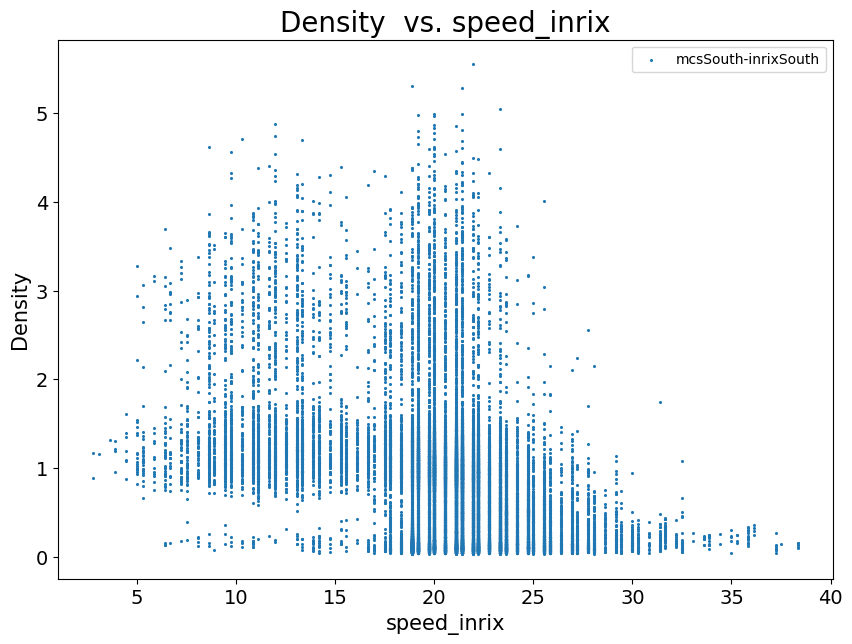

In [67]:
# draw flow_mcs vs. Speed_inrix after time step matched
combinedCorr2 = combinedSouth.iloc[:38519][['speed_inrix', 'Density']].copy()
print(combinedCorr2.corr())

plt.figure(figsize=(10,7))
plotScatter(combinedCorr2, combinedCorr2, 'speed_inrix', 'Density', 'mcsSouth-inrixSouth')

The relation between flow and (raw)speed_inrix is very non-linear and does not follow the traffic flow theory.

### 7.3 Using (raw) inrix_speed as feature to predict mcs_density in 9 days range

In [68]:
# pick up 9 days' data from combined dataframe (1st OCT to 9th OCT)
combinedSouth9days = combinedSouth[:12839] 
combinedSouth9days.iloc[-3:]

fk_id                 date  ...  Epoch_inrix  travel_time_secs
12836   1162  2018-10-09 23:56:00  ...       777357             57.18
12837   1162  2018-10-09 23:57:00  ...       777417             57.18
12838   1162  2018-10-09 23:58:00  ...       777476             59.70

[3 rows x 14 columns]

In [69]:
# prepare the feature and label columns from combinedSouth's 9days data
X_epoch = combinedSouth9days['Epoch_mcs'].values.reshape(-1, 1)
X_speed = combinedSouth9days['speed_inrix'].values
Y_label = combinedSouth9days['Density'].values.reshape(-1, 1)

# turn speed_inrix into polynomial features: 1, s, s^2, s^3, ...
X_speed_poly = makePoly(20, X_speed)
X_speed_poly, scaler_speed_9 = normalize(X_speed_poly)
X_speed_epoch = np.append(X_speed_poly, X_epoch, axis=1)
dfRawFeatures_speed = pd.DataFrame(X_speed_epoch)
print(dfRawFeatures_speed.head(5))
X_features = X_speed_epoch

# split training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=0)

# build and train the polynomial regression model
regressor = model(X_train[:, :21], Y_train)

# Evaluate Performance of training set
Y_predict_train = regressor.predict(X_train[:, :21])
print("Root Mean Square Error: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score: ", r2_score(Y_train, Y_predict_train))

# Evaluate Performance of testing set
Y_predict_test = regressor.predict(X_test[:, :21])
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score: ", r2_score(Y_test, Y_predict_test))

    0         1         2         3   ...        18        19        20     21
0  1.0  1.384316  1.630729  1.764848  ...  0.047828  0.023663  0.006200    0.0
1  1.0  1.384316  1.630729  1.764848  ...  0.047828  0.023663  0.006200   60.0
2  1.0  1.666956  2.035766  2.284210  ...  0.187950  0.135486  0.094892  120.0
3  1.0  1.666956  2.035766  2.284210  ...  0.187950  0.135486  0.094892  180.0
4  1.0  1.666956  2.035766  2.284210  ...  0.187950  0.135486  0.094892  240.0

[5 rows x 22 columns]
Root Mean Square Error:  0.71298181093498
R2 Score:  0.13857335410425153
Root Mean Square Error:  0.7166367205626166
R2 Score:  0.15173713094614305


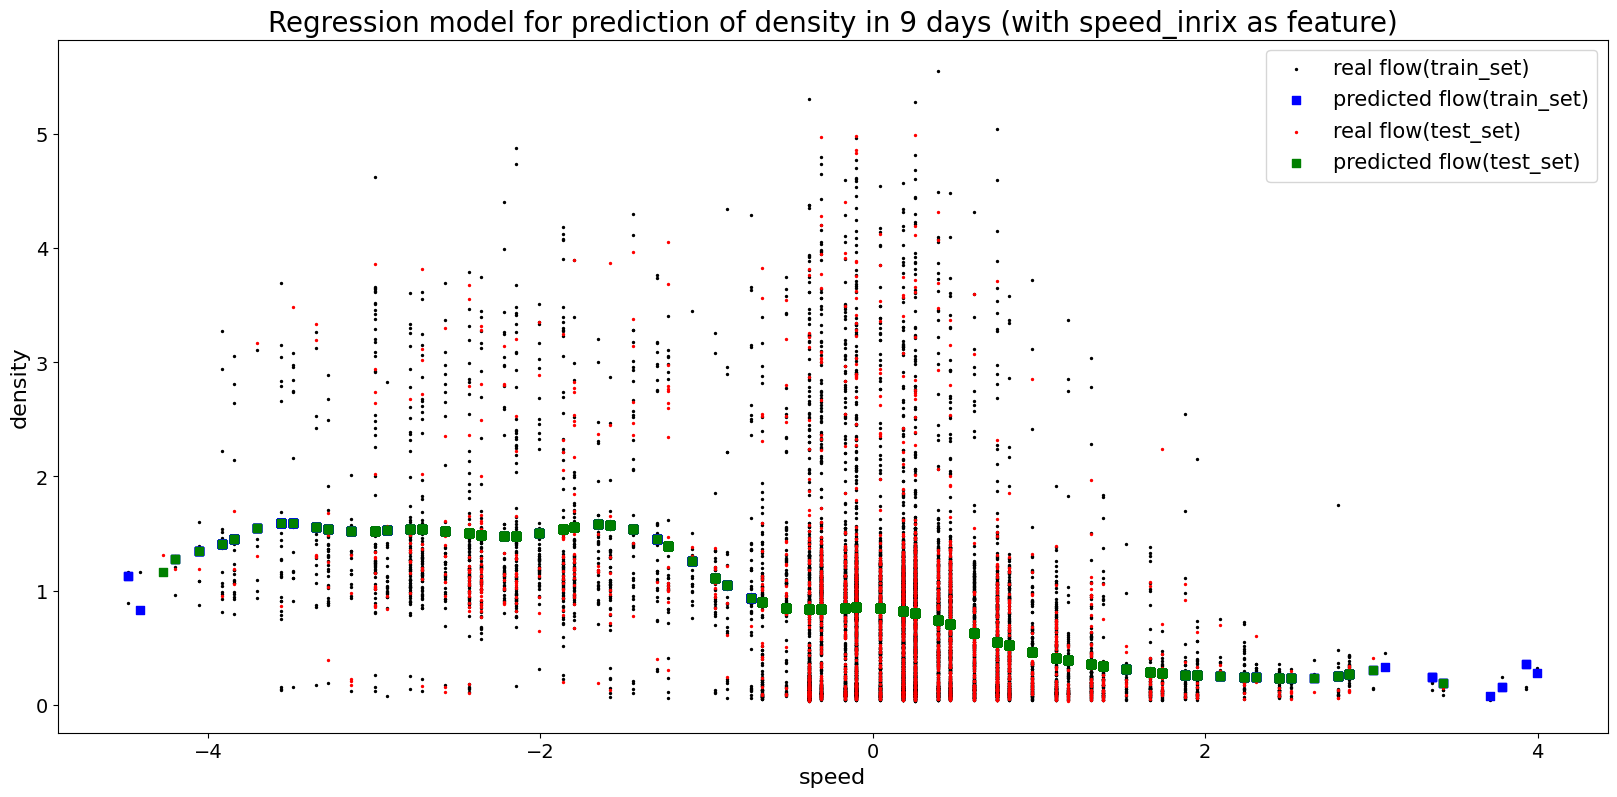

In [70]:
# Plot real and predicted flow from X_train, X_test
plt.figure(figsize=(20, 9))
plotResult(X_train[:, 1], Y_train[:, 0], Y_predict_train[:, 0], 
           X_test[:, 1], Y_test[:, 0], Y_predict_test[:, 0], '9 days (with speed_inrix as feature)', 'speed')

In [71]:
# Use all data to train and predict the flow
Y_predict = regressor.predict(X_features[:,:21])
print("Root Mean Square Error: ", mean_squared_error(Y_label, Y_predict, squared=False))
print("R2 Score: ", r2_score(Y_label, Y_predict))

Root Mean Square Error:  0.7137143636664742
R2 Score:  0.14131972630055956


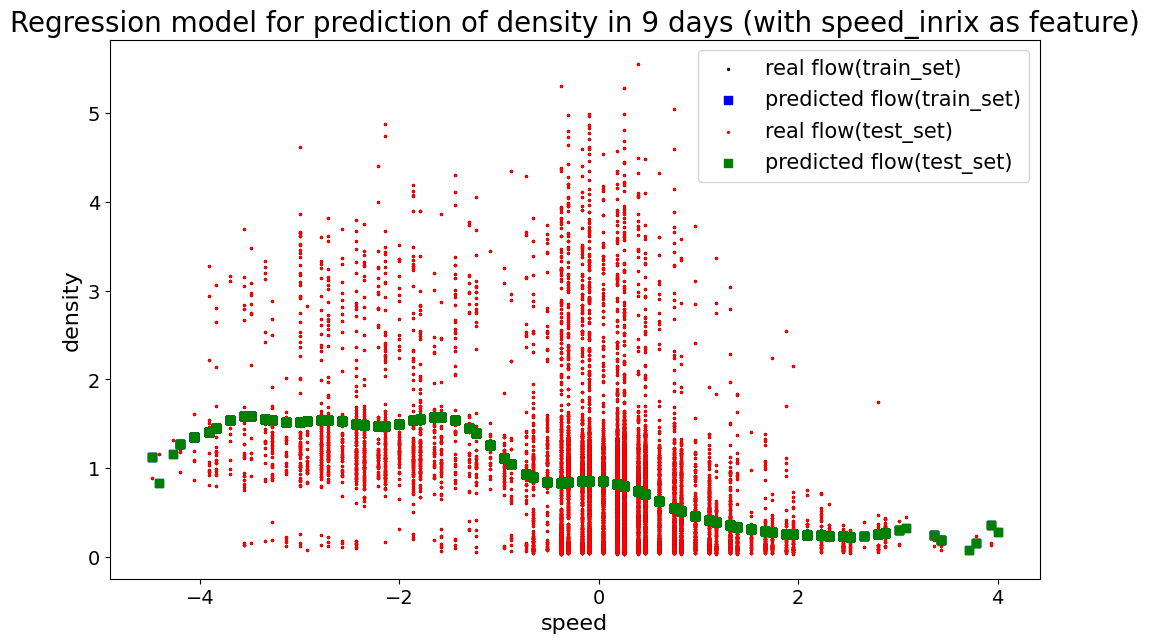

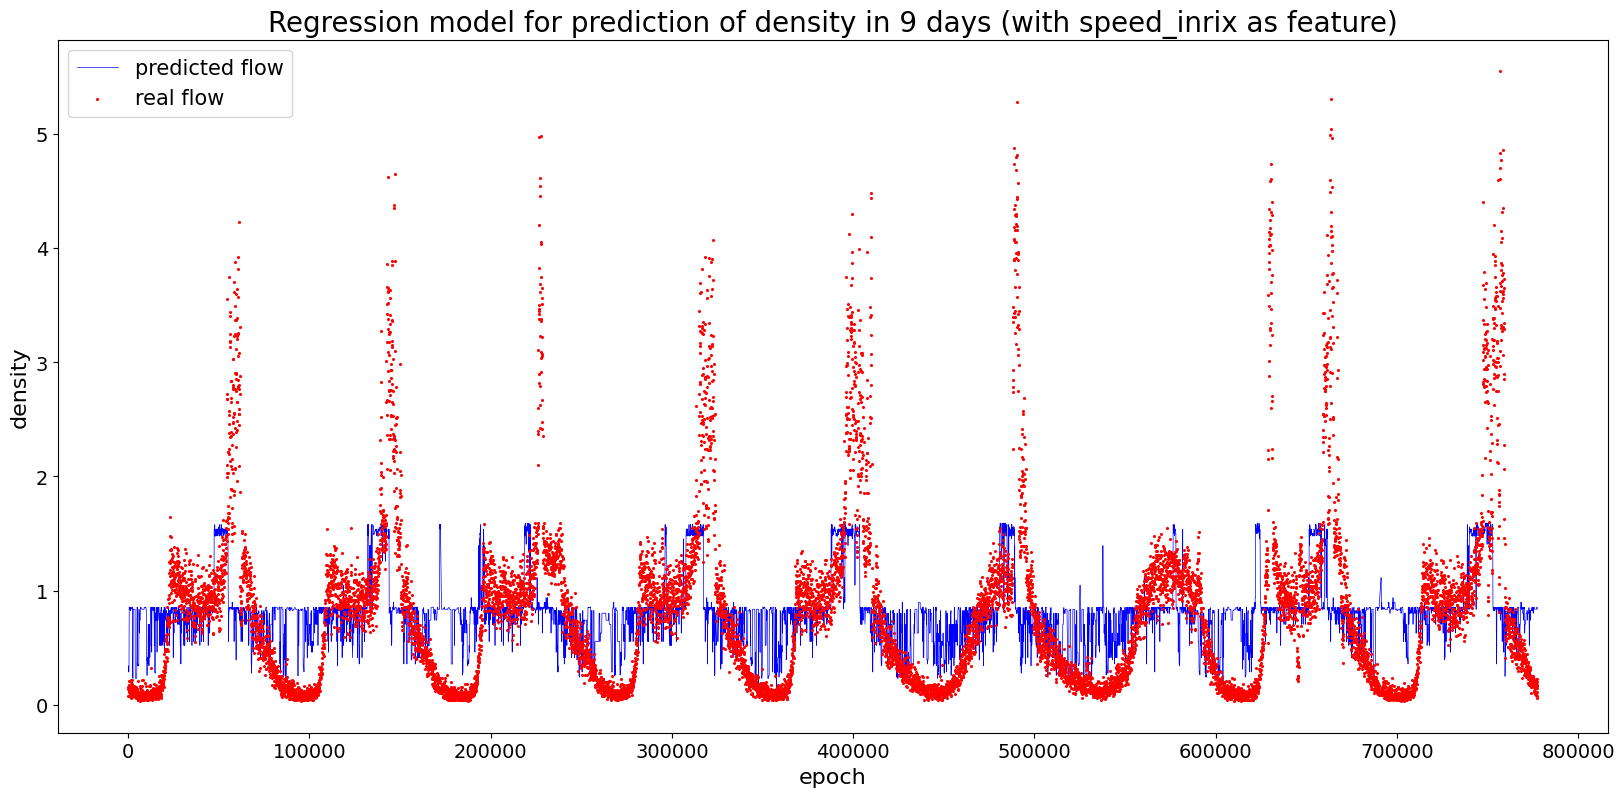

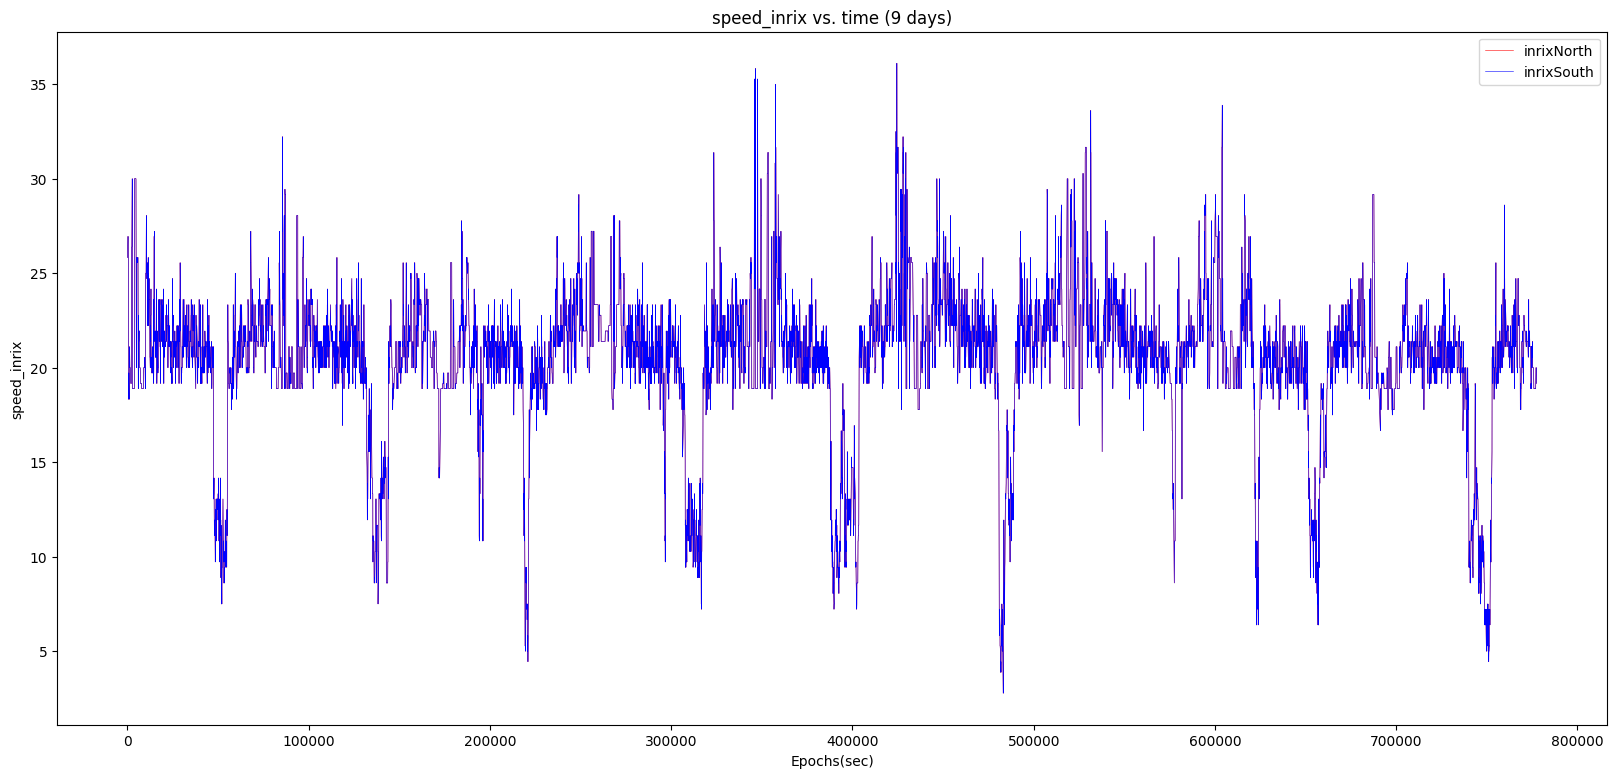

In [72]:
# Plot real and predicted flow from X_features
plt.figure(figsize=(12, 7))
plotResult(X_features[:, 1], Y_label[:, 0], Y_predict[:, 0], 
           X_features[:, 1], Y_label[:, 0], Y_predict[:, 0], '9 days (with speed_inrix as feature)', 'speed')

plt.figure(figsize=(20, 9))
plotResult(X_features[:, -1], Y_label[:, 0], Y_predict[:, 0], 
           None, None, None, '9 days (with speed_inrix as feature)', 'epoch')

plt.figure(figsize=(20, 9))
plotAttr(9, combinedSouth9days, combinedSouth9days,'speed_inrix', 'inrix')

Summary: The accuracy (R2 = 0.2) is really low when we directly use inrix speed to predict  mcs flow. This is probably because the relation between inrix speed and mcs flow does not meet the traffic flow theory (fundemental Diagram) due to the time lag between inrix speed and mcs speed. Therefore, in order to achieve higher accuracy by using inrix speed as feature, we need either shift the inrix speed to eliminate the effect from time-lag, or train a neural network which can learn to mitigate the effect of timelag by itself.

### 7.4 Shifting the time-lag between inrix speed and mcs speed


#### 7.4.1 Decide how many time steps we should shift to match 2 speeds

In [0]:
# function to plot 2 attributes (vs. Epochs) from 2 different senesors in a same diagram
def plotAttr3(days, dataFrame, attribute1, attribute2, location):
  plt.plot(dataFrame['Epoch_mcs'], dataFrame[attribute1], 'r', linewidth = 0.8, label = 'mcs_' + location)
  plt.plot(dataFrame['Epoch_mcs'], dataFrame[attribute2], 'b', linewidth = 0.8, label = 'inrix_' + location)
  plt.xlabel('Epochs(sec)', fontsize= 14)
  plt.xticks(fontsize=14)
  plt.ylabel(attribute1, fontsize=14)
  plt.yticks(fontsize=14)
  plt.title(attribute1 + ' vs. time (' + str(days) + ' day)', fontsize = 14)
  plt.legend()
  plt.show()

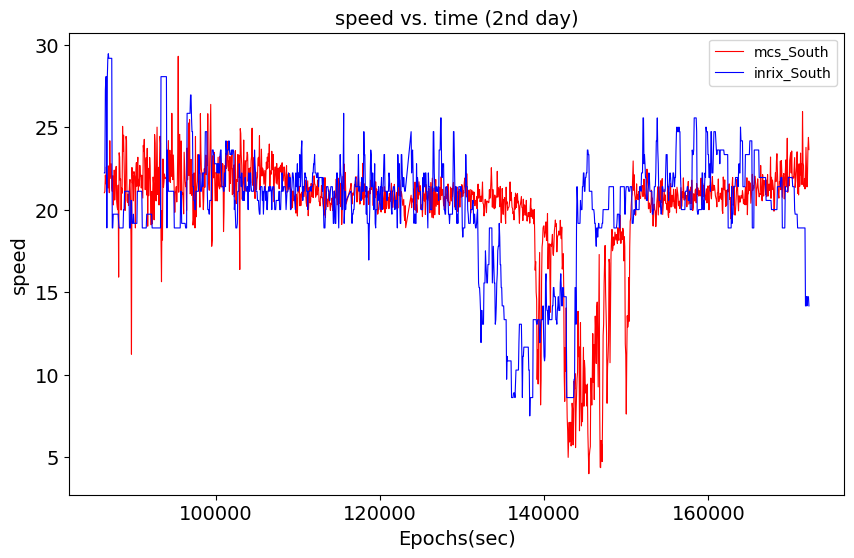

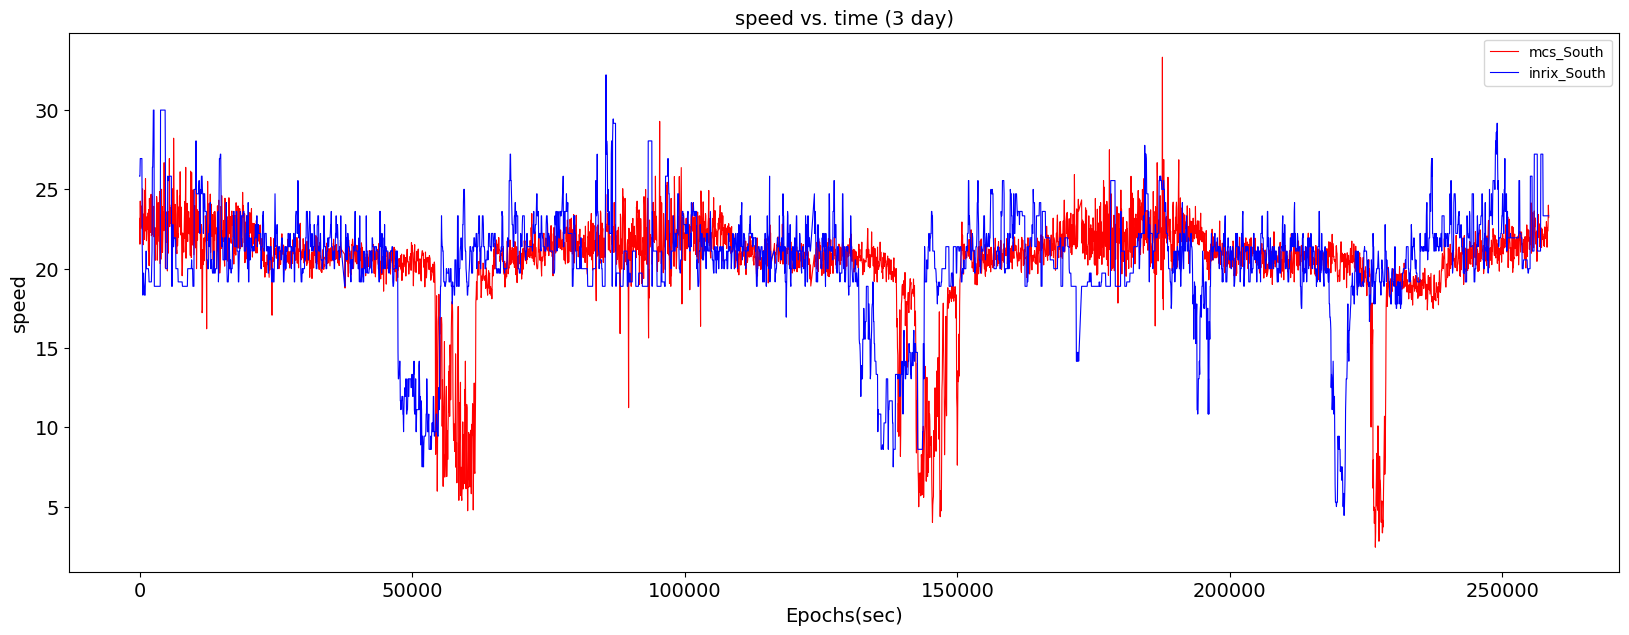

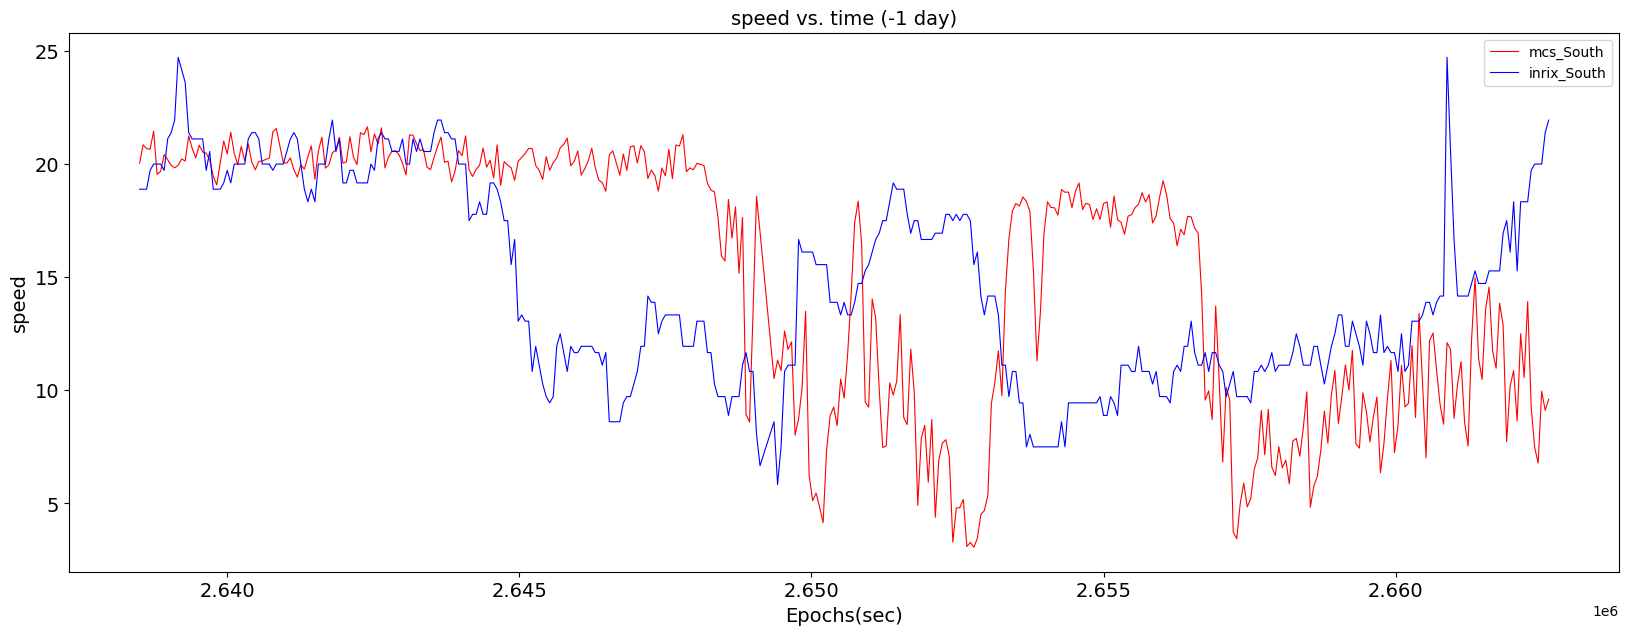

In [74]:
combinedSouthT = combinedSouth.iloc[1424:2833] 
plt.figure(figsize=(10, 6))
plotAttr3('2nd', combinedSouthT, 'speed', 'speed_inrix', 'South')

combinedSouth3days = combinedSouth.iloc[:4260] # 4260 for 3 days
plt.figure(figsize=(20, 7))
plotAttr3(3, combinedSouth3days, 'speed', 'speed_inrix', 'South')

combinedSouthLast1days = combinedSouth.iloc[-400:]
plt.figure(figsize=(20, 7))
plotAttr3(-1, combinedSouthLast1days, 'speed', 'speed_inrix', 'South')

We should shift inrix by approximate 114 min to eliminate the time-lag.

#### 7.4.2 Shifting the Inrix by 114 mins (time-lag)

In [75]:
# Shift Epoch_inrix by adding 114 mins in order to eliminate the time-gap  
inrixSouth_shifted = inrixSouth.copy()
print(inrixSouth_shifted)
inrixSouth_shifted['Epoch_inrix'] = inrixSouth_shifted.Epoch_inrix + (114 * 60)
print(inrixSouth_shifted)

        segmentid         timestamputc  ...  Epoch_inrix  travel_time_secs
0      1071883675  2018-10-01 00:00:12  ...            0             44.28
1      1071883675  2018-10-01 00:01:10  ...           58             44.28
2      1071883675  2018-10-01 00:02:08  ...          116             42.90
3      1071883675  2018-10-01 00:03:09  ...          177             42.90
4      1071883675  2018-10-01 00:04:10  ...          238             42.90
...           ...                  ...  ...          ...               ...
44270  1071883675  2018-10-31 18:33:08  ...      2662376             56.40
44271  1071883675  2018-10-31 18:34:10  ...      2662438             57.18
44272  1071883675  2018-10-31 18:35:10  ...      2662498             56.40
44273  1071883675  2018-10-31 18:36:09  ...      2662557             52.80
44274  1071883675  2018-10-31 18:37:09  ...      2662617             52.14

[44275 rows x 6 columns]
        segmentid         timestamputc  ...  Epoch_inrix  travel_time_secs

Shift 110 mins: Corr Coefficient = 0.674 <br>
Shift 112 mins: Corr Coefficient = 0. <br>
Shift 114 mins: Corr Coefficient = 0.69 <br>
Shift 116 mins: Corr Coefficient = 0. <br>
Shift 118 mins: Corr Coefficient = 0.690 <br>
Shift 120 mins: Corr Coefficient = 0.684 <br>


In [76]:
# match the shifted inrix with mcs dataframe and combined them
combinedSouth_shifted = matchTimeStep(mcsSouth, inrixSouth_shifted)

Empty DataFrame
Columns: [fk_id, date, speed, speed_std_dev, flow, used_lanes, Epoch_mcs, Density]
Index: []
Empty DataFrame
Columns: [segmentid, timestamputc, speed, average, Epoch_inrix, travel_time_secs]
Index: []
missing inrix 1
missing inrix 2
missing inrix 3
missing inrix 4
missing inrix 5
missing inrix 6
missing inrix 7
missing inrix 8
missing inrix 9
missing inrix 10
missing inrix 11
missing inrix 12
missing inrix 13
missing inrix 14
missing inrix 15
missing inrix 16
missing inrix 17
missing inrix 18
missing inrix 19
missing inrix 20
missing inrix 21
missing inrix 22
missing inrix 23
missing inrix 24
missing inrix 25
missing inrix 26
missing inrix 27
missing inrix 28
missing inrix 29
missing inrix 30
missing inrix 31
missing inrix 32
missing inrix 33
missing inrix 34
missing inrix 35
missing inrix 36
missing inrix 37
missing inrix 38
missing inrix 39
missing inrix 40
missing inrix 41
missing inrix 42
missing inrix 43
missing inrix 44
missing inrix 45
missing inrix 46
missing in

In [77]:
print(combinedSouth_shifted[['date', 'speed', 'timestamputc', 'speed_inrix']])

                      date    speed         timestamputc  speed_inrix
0      2018-10-01 01:54:00  20.9483  2018-10-01 00:00:12    25.833333
1      2018-10-01 01:55:00  24.9584  2018-10-01 00:01:10    25.833333
2      2018-10-01 01:56:00  21.4381  2018-10-01 00:02:08    26.944444
3      2018-10-01 01:57:00  22.2112  2018-10-01 00:03:09    26.944444
4      2018-10-01 01:58:00  21.9863  2018-10-01 00:04:10    26.944444
...                    ...      ...                  ...          ...
43838  2018-10-31 20:27:00  21.5131  2018-10-31 18:33:08    20.000000
43839  2018-10-31 20:28:00  21.2487  2018-10-31 18:34:10    20.000000
43840  2018-10-31 20:29:00  21.0718  2018-10-31 18:35:10    20.000000
43841  2018-10-31 20:30:00  21.3425  2018-10-31 18:36:09    21.388889
43842  2018-10-31 20:31:00  22.0947  2018-10-31 18:37:09    21.944444

[43843 rows x 4 columns]


In [78]:
# Check the datatype after combining, cast the datatypes to the original types
print(combinedSouth_shifted.info())
print(mcsSouth.info())
print(inrixSouth.info())
combinedSouth_shifted = combinedSouth_shifted.astype({'fk_id':'int64', 'flow':'int64', 'segmentid':'int64', 'Epoch_inrix':'int64'})
combinedSouth_shifted.info()
combinedSouth_shifted.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43843 entries, 0 to 43842
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fk_id             43843 non-null  object 
 1   date              43843 non-null  object 
 2   speed             43843 non-null  float64
 3   speed_std_dev     43843 non-null  float64
 4   flow              43843 non-null  object 
 5   used_lanes        43843 non-null  object 
 6   Epoch_mcs         43843 non-null  float64
 7   Density           43843 non-null  float64
 8   segmentid         43843 non-null  object 
 9   timestamputc      43843 non-null  object 
 10  speed_inrix       43843 non-null  float64
 11  average           43843 non-null  float64
 12  Epoch_inrix       43843 non-null  object 
 13  travel_time_secs  43843 non-null  float64
dtypes: float64(7), object(7)
memory usage: 4.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44275 entries, 0 to 44274
Data c

fk_id                 date  ...  Epoch_inrix  travel_time_secs
0   1162  2018-10-01 01:54:00  ...         6840             44.28
1   1162  2018-10-01 01:55:00  ...         6898             44.28
2   1162  2018-10-01 01:56:00  ...         6956             42.90

[3 rows x 14 columns]

In [79]:
combinedSouth_shifted.iloc[2700:2750]

fk_id                 date  ...  Epoch_inrix  travel_time_secs
2700   1162  2018-10-02 23:31:00  ...       171058             53.46
2701   1162  2018-10-02 23:32:00  ...       171117             53.46
2702   1162  2018-10-02 23:33:00  ...       171178             53.46
2703   1162  2018-10-02 23:34:00  ...       171236             53.46
2704   1162  2018-10-02 23:35:00  ...       171300             52.80
2705   1162  2018-10-02 23:36:00  ...       171356             49.02
2706   1162  2018-10-02 23:37:00  ...       171421             49.02
2707   1162  2018-10-02 23:38:00  ...       171476             49.02
2708   1162  2018-10-02 23:39:00  ...       171542             49.02
2709   1162  2018-10-02 23:40:00  ...       171597             49.02
2710   1162  2018-10-02 23:41:00  ...       171657             49.02
2711   1162  2018-10-02 23:42:00  ...       171717             49.02
2712   1162  2018-10-02 23:43:00  ...       171777             49.02
2713   1162  2018-10-02 23:44:00  ...       171837             49.02
2714   1162  2018-10-02 23:45:00  ...       171896             47.34
2715   1162  2018-10-02 23:46:00  ...       171956             47.34
2716   1162  2018-10-02 23:47:00  ...       172020             47.34
2717   1162  2018-10-02 23:48:00  ...       172076             47.34
2718   1162  2018-10-02 23:49:00  ...       172139             47.34
2719   1162  2018-10-02 23:50:00  ...       172196             60.54
2720   1162  2018-10-02 23:51:00  ...       172258             60.54
2721   1162  2018-10-03 00:00:00  ...       172796             48.42
2722   1162  2018-10-03 00:01:00  ...       172858             48.42
2723   1162  2018-10-03 00:02:00  ...       172917             48.42
2724   1162  2018-10-03 00:03:00  ...       172979             48.42
2725   1162  2018-10-03 00:04:00  ...       173038             52.14
2726   1162  2018-10-03 00:05:00  ...       173098             52.14
2727   1162  2018-10-03 00:06:00  ...       173157             52.14
2728   1162  2018-10-03 00:07:00  ...       173218             52.14
2729   1162  2018-10-03 00:08:00  ...       173277             52.14
2730   1162  2018-10-03 00:09:00  ...       173340             52.14
2731   1162  2018-10-03 00:10:00  ...       173397             52.14
2732   1162  2018-10-03 00:11:00  ...       173456             52.14
2733   1162  2018-10-03 00:12:00  ...       173517             52.14
2734   1162  2018-10-03 00:13:00  ...       173578             52.14
2735   1162  2018-10-03 00:14:00  ...       173638             52.14
2736   1162  2018-10-03 00:15:00  ...       173697             52.14
2737   1162  2018-10-03 00:16:00  ...       173756             52.14
2738   1162  2018-10-03 00:17:00  ...       173818             52.14
2739   1162  2018-10-03 00:18:00  ...       173876             55.68
2740   1162  2018-10-03 00:19:00  ...       173939             55.68
2741   1162  2018-10-03 00:20:00  ...       173996             55.68
2742   1162  2018-10-03 00:21:00  ...       174057             55.68
2743   1162  2018-10-03 00:22:00  ...       174117             55.68
2744   1162  2018-10-03 00:23:00  ...       174177             55.68
2745   1162  2018-10-03 00:24:00  ...       174237             55.68
2746   1162  2018-10-03 00:25:00  ...       174298             55.68
2747   1162  2018-10-03 00:26:00  ...       174356             55.68
2748   1162  2018-10-03 00:27:00  ...       174416             55.68
2749   1162  2018-10-03 00:28:00  ...       174476             55.68

[50 rows x 14 columns]

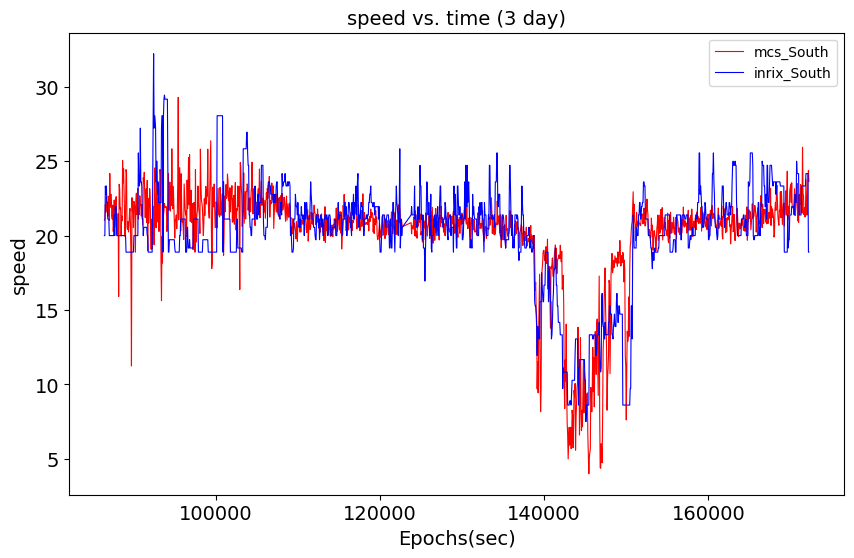

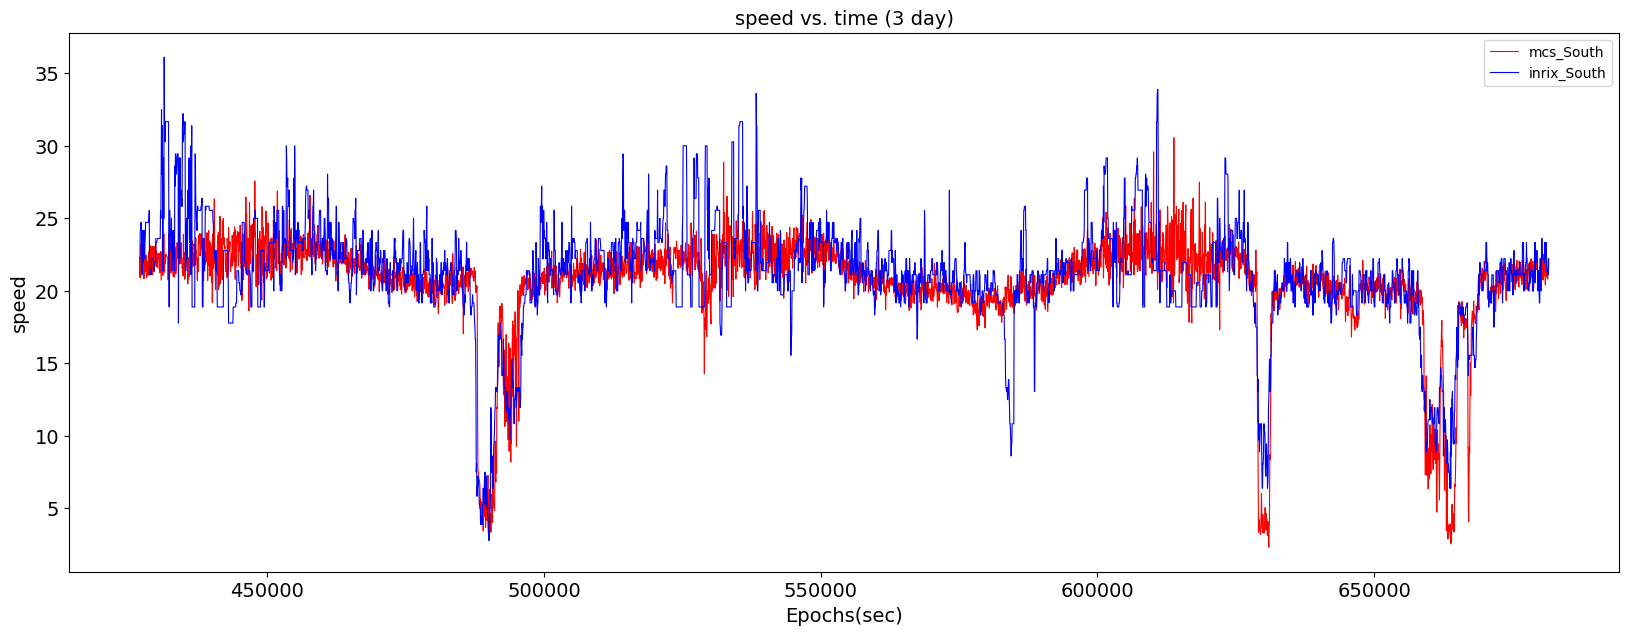

In [80]:
combinedSouthT_shifted = combinedSouth_shifted.iloc[1311:2721] # 4148 for 3 days
plt.figure(figsize=(10, 6))
plotAttr3(3, combinedSouthT_shifted, 'speed', 'speed_inrix', 'South')

plt.figure(figsize=(20, 7))
combinedSouth3days_shifted = combinedSouth_shifted.iloc[2721 + 4200 :4148 + 7000]
plotAttr3(3, combinedSouth3days_shifted, 'speed', 'speed_inrix', 'South')

Speed_inrix and speed_mcs now matching each other after shifting

### 7.4.3 Analyse correlation between mcsSouth and inrixSouth after timestep matching (after shifting)

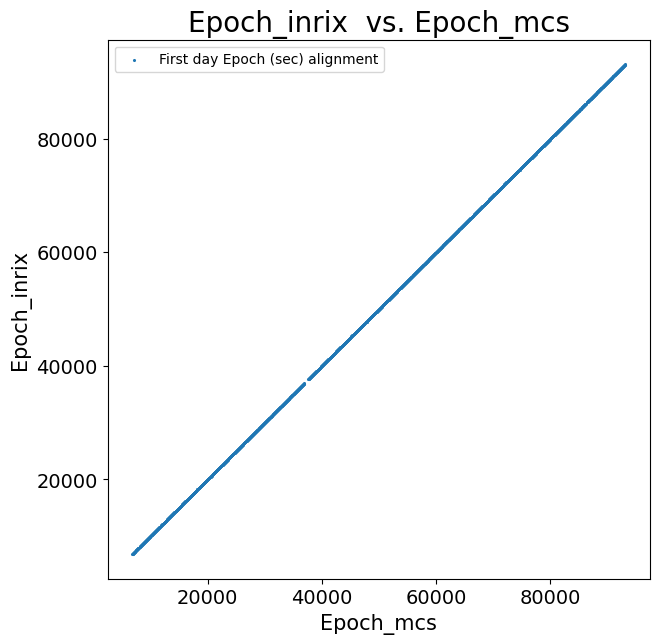

In [81]:
# draw plot of epoch_mcs vs. epoch_inrix after shifting
plt.figure(figsize = (7, 7))
combinedSouth1day_shifted = combinedSouth_shifted.iloc[:1424]
plotScatter(combinedSouth1day_shifted, combinedSouth1day_shifted, 'Epoch_mcs', 'Epoch_inrix','First day Epoch (sec) alignment')

In [82]:
combinedSouth_shifted[38406: 38408]

fk_id                 date  ...  Epoch_inrix  travel_time_secs
38406   1162  2018-10-27 23:49:00  ...      2332138             49.02
38407   1162  2018-10-28 00:00:00  ...      2332798             51.48

[2 rows x 14 columns]

             speed_inrix     speed
speed_inrix     1.000000  0.720475
speed           0.720475  1.000000


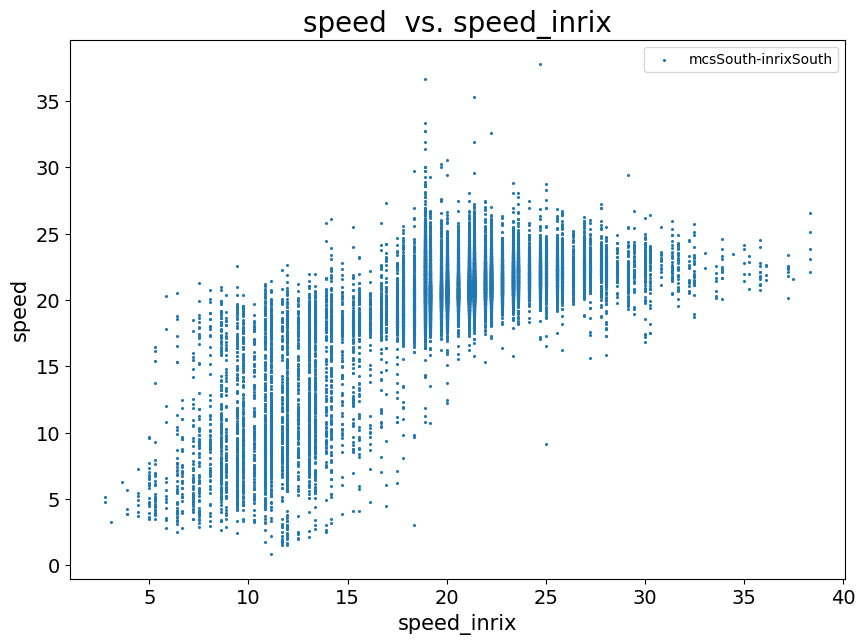

In [83]:
# draw plot of Speed_mcs vs. Speed_inrix after timestep matching
combinedCorr1 = combinedSouth_shifted.iloc[:38407][['speed_inrix', 'speed']].copy() # until 27th
print(combinedCorr1.corr())

plt.figure(figsize=(10,7))
plotScatter(combinedCorr1, combinedCorr1, 'speed_inrix', 'speed', 'mcsSouth-inrixSouth')

Correlation between two speeds is higer after shifting.

             speed_inrix   Density
speed_inrix     1.000000 -0.691853
Density        -0.691853  1.000000


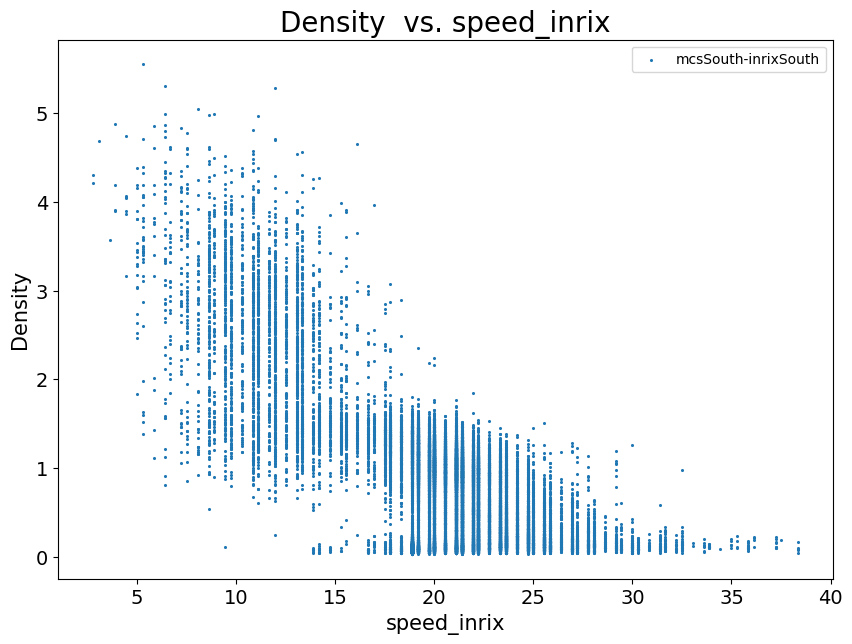

In [84]:
# draw flow_mcs vs. Speed_inrix after time step matched
combinedCorr2 = combinedSouth_shifted.iloc[:38407][['speed_inrix', 'Density']].copy() # until 27th Oct
print(combinedCorr2.corr())

plt.figure(figsize=(10,7))
plotScatter(combinedCorr2, combinedCorr2, 'speed_inrix', 'Density', 'mcsSouth-inrixSouth')

Shifting doesn’t improve the characterization of flow-speed(inrix) relation much.

### 7.4.4 Using (shifted) inrix_speed as feature to predict mcs_density in 9 days range

In [85]:
# pick up 9 days' data from combined dataframe (1st OCT to 9th OCT)
combinedSouth9days_shifted = combinedSouth_shifted[:12727] 
combinedSouth9days_shifted.iloc[-3:]

fk_id                 date  ...  Epoch_inrix  travel_time_secs
12724   1162  2018-10-09 23:56:00  ...       777357             50.22
12725   1162  2018-10-09 23:57:00  ...       777416             50.82
12726   1162  2018-10-09 23:58:00  ...       777476             50.82

[3 rows x 14 columns]

In [86]:
# prepare the feature and label columns from combinedSouth's 9days data
X_epoch = combinedSouth9days_shifted['Epoch_mcs'].values.reshape(-1, 1)
X_speed = combinedSouth9days_shifted['speed_inrix'].values
Y_label = combinedSouth9days_shifted['Density'].values.reshape(-1, 1)

# turn speed_inrix into polynomial features: 1, s, s^2, s^3, ...
X_speed_poly = makePoly(20, X_speed)
X_speed_poly, scaler_speed_9 = normalize(X_speed_poly)
X_speed_epoch = np.append(X_speed_poly, X_epoch, axis=1)
dfRawFeatures_speed = pd.DataFrame(X_speed_epoch)
print(dfRawFeatures_speed.head(5))
X_features = X_speed_epoch

# split training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=0)

# build and train the polynomial regression model
regressor = model(X_train[:, :21], Y_train)

# Evaluate Performance of training set
Y_predict_train = regressor.predict(X_train[:, :21])
print("Root Mean Square Error: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score: ", r2_score(Y_train, Y_predict_train))

# Evaluate Performance of testing set
Y_predict_test = regressor.predict(X_test[:, :21])
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score: ", r2_score(Y_test, Y_predict_test))

    0        1         2         3   ...        18        19        20      21
0  1.0  1.38086  1.627019  1.762624  ...  0.048651  0.024420  0.006907  6840.0
1  1.0  1.38086  1.627019  1.762624  ...  0.048651  0.024420  0.006907  6900.0
2  1.0  1.66224  2.030623  2.280927  ...  0.188711  0.136115  0.095444  6960.0
3  1.0  1.66224  2.030623  2.280927  ...  0.188711  0.136115  0.095444  7020.0
4  1.0  1.66224  2.030623  2.280927  ...  0.188711  0.136115  0.095444  7080.0

[5 rows x 22 columns]
Root Mean Square Error:  0.464224482350486
R2 Score:  0.6312112886721659
Root Mean Square Error:  0.47214560764357416
R2 Score:  0.6461999554572209


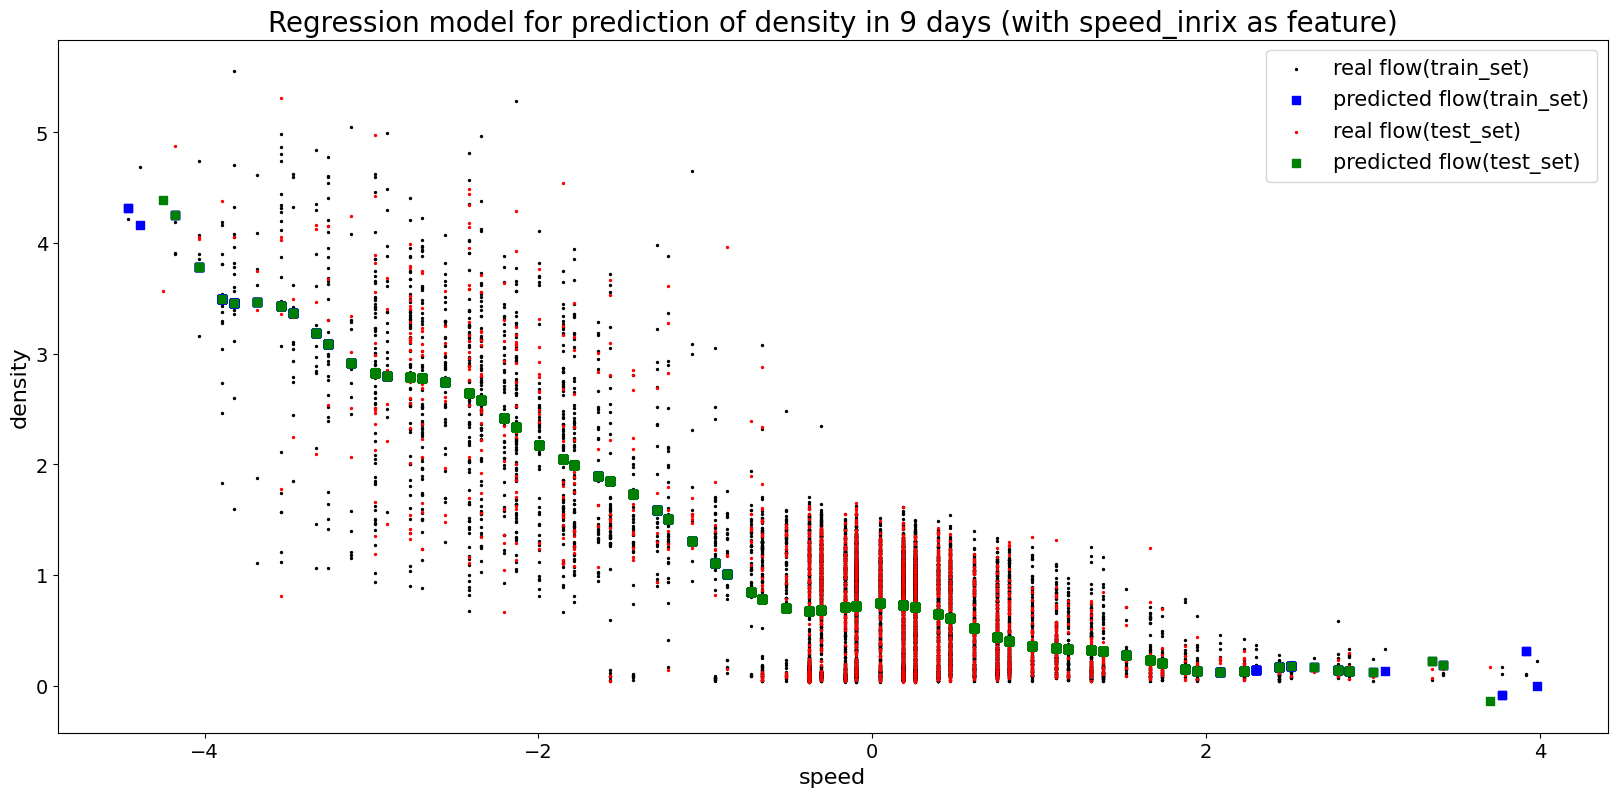

In [87]:
# Plot real and predicted flow from X_train, X_test
plt.figure(figsize=(20, 9))
plotResult(X_train[:, 1], Y_train[:, 0], Y_predict_train[:, 0], 
           X_test[:, 1], Y_test[:, 0], Y_predict_test[:, 0], '9 days (with speed_inrix as feature)', 'speed')

In [88]:
  # Use all data to train and predict the flow
regressor = model(X_features[:, :21], Y_label)
Y_predict = regressor.predict(X_features[:,:21])
print("Root Mean Square Error: ", mean_squared_error(Y_label, Y_predict, squared=False))
print("R2 Score: ", r2_score(Y_label, Y_predict))

Root Mean Square Error:  0.46572084987516255
R2 Score:  0.6345500874929828


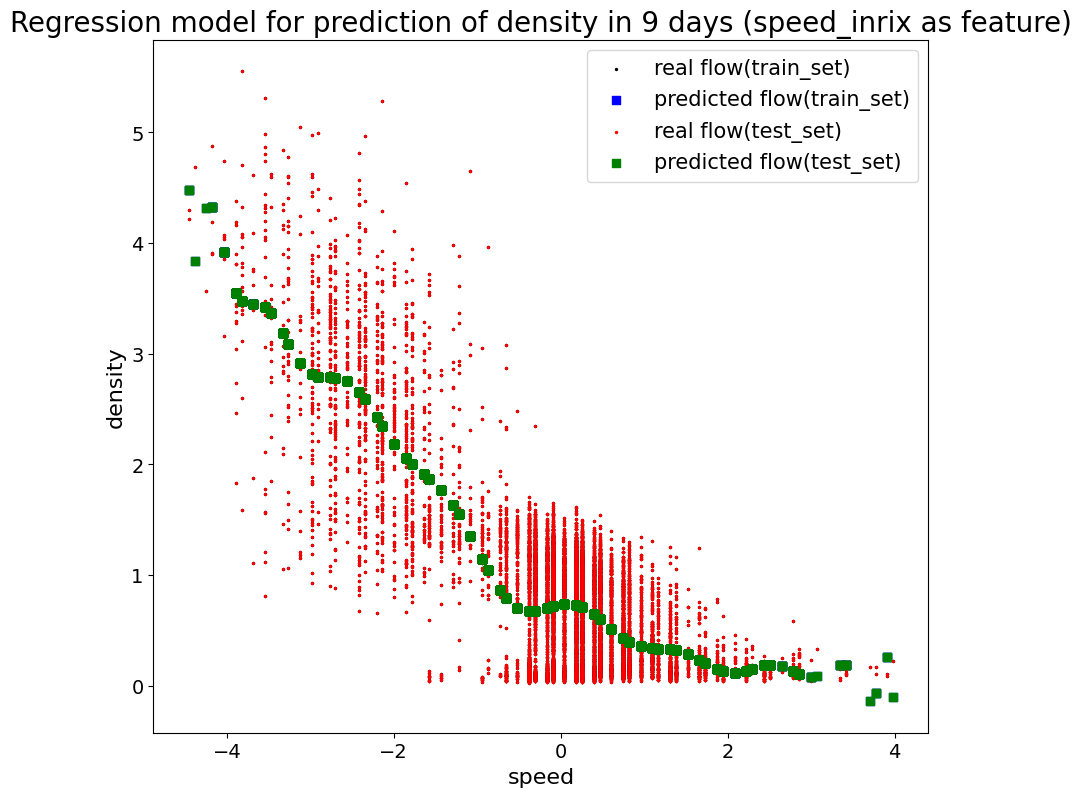

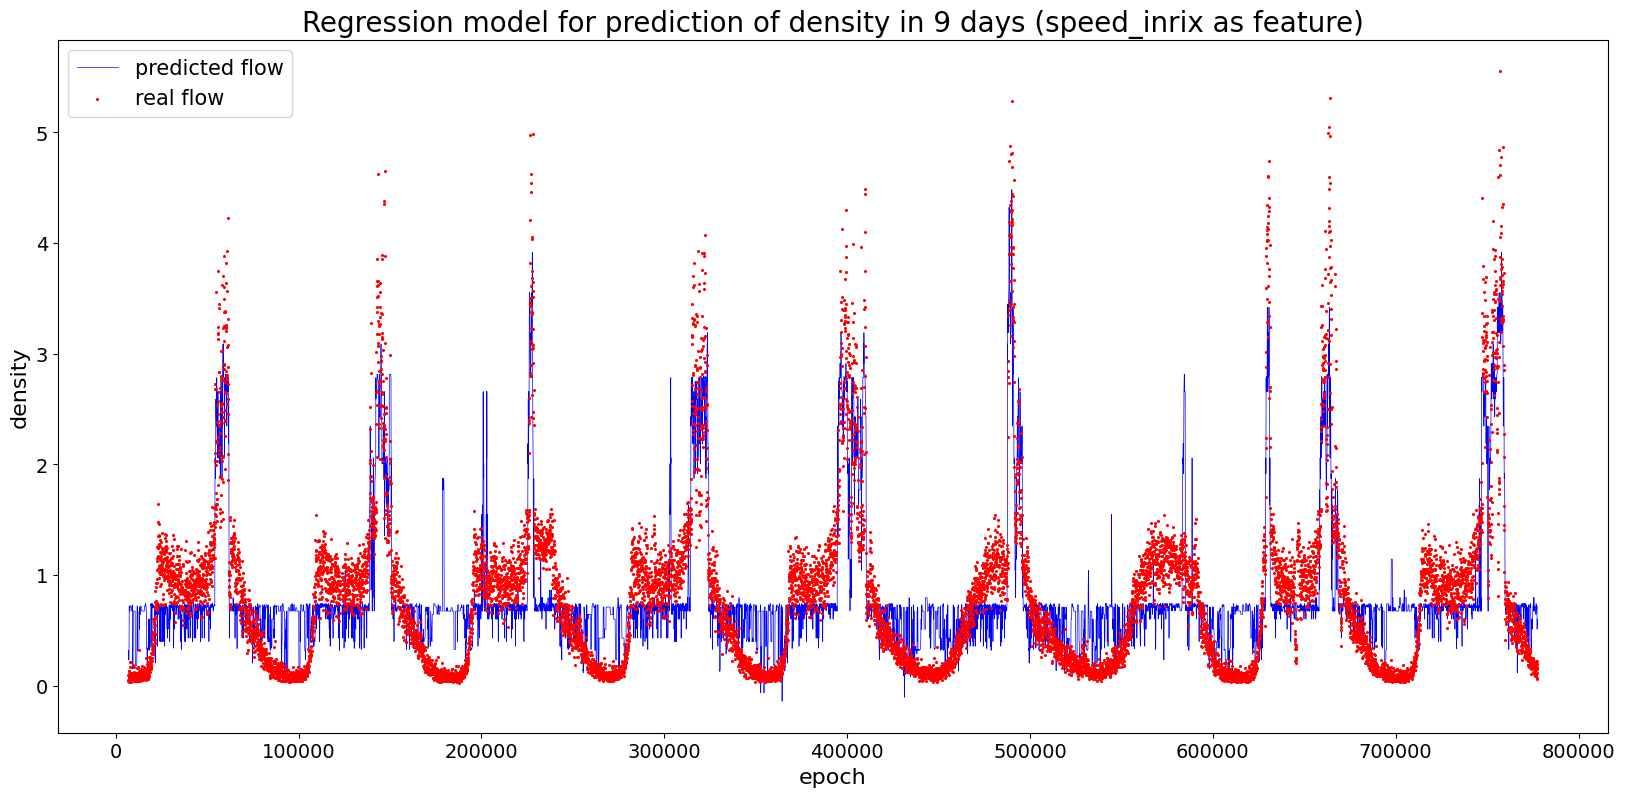

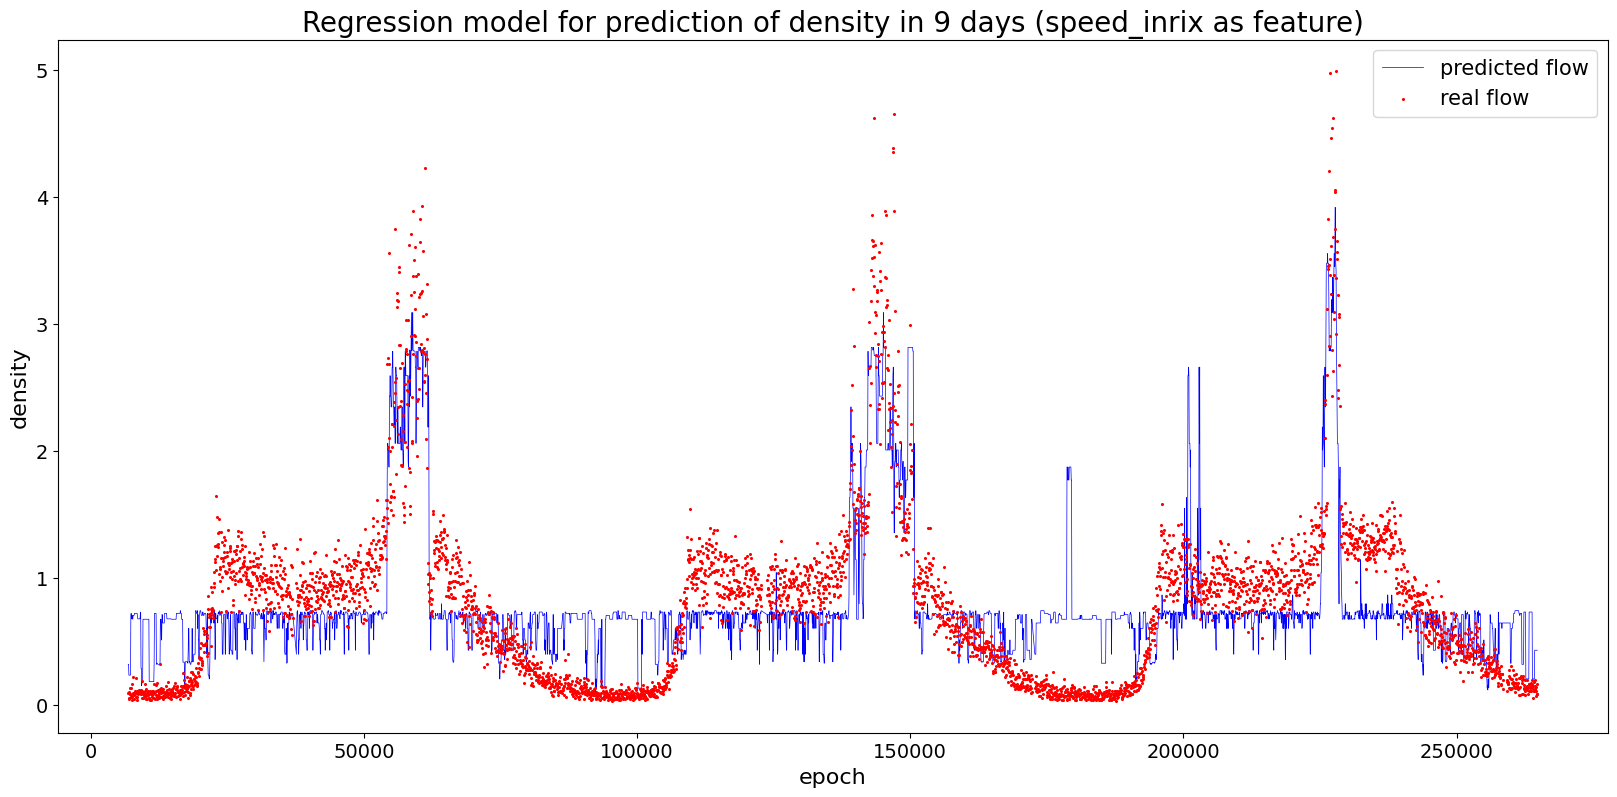

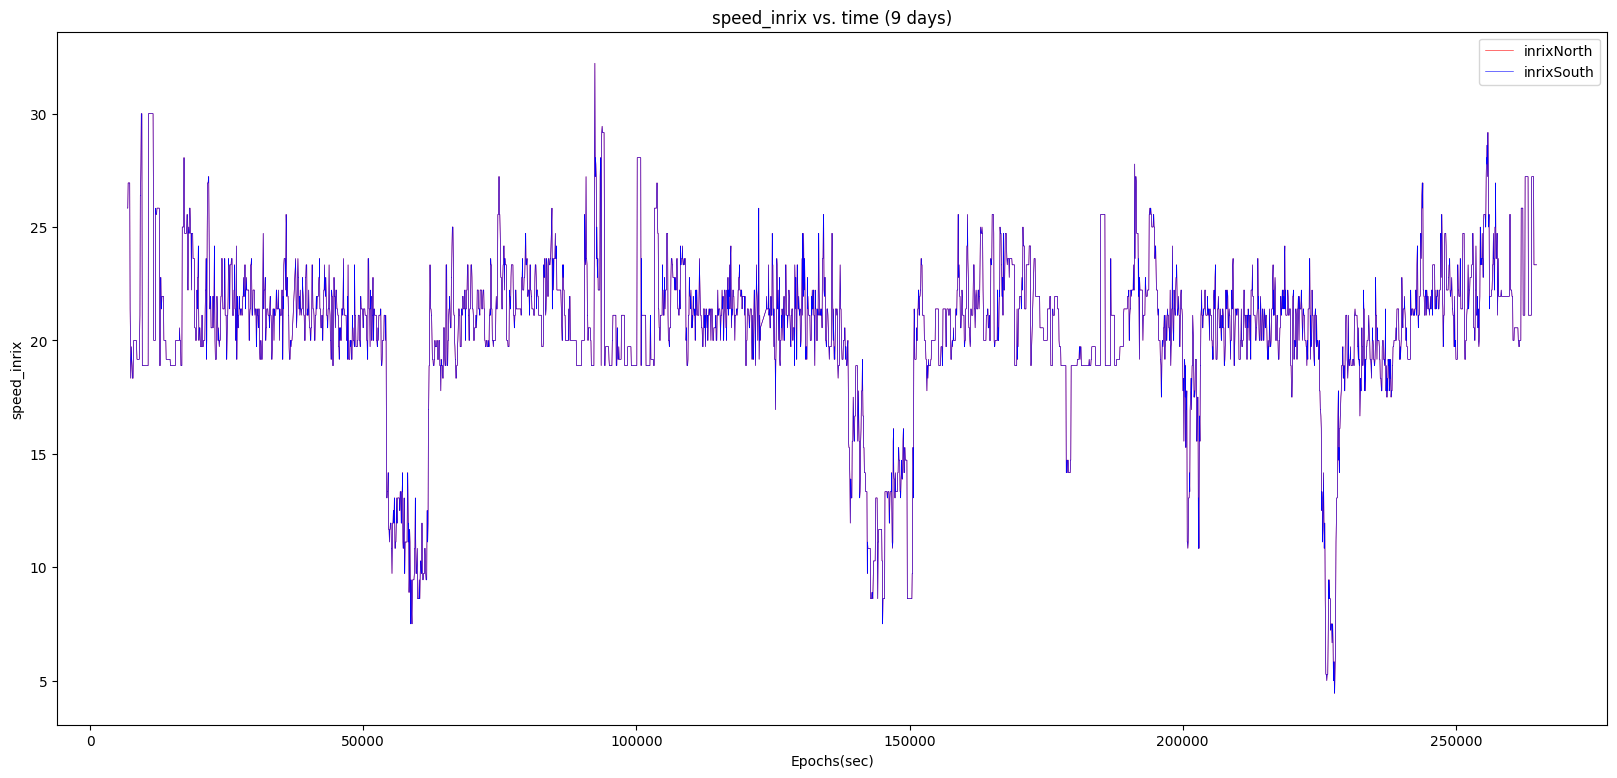

In [89]:
# Plot real and predicted flow from X_features
plt.figure(figsize=(10, 9))
plotResult(X_features[:, 1], Y_label[:, 0], Y_predict[:, 0], 
           X_features[:, 1], Y_label[:, 0], Y_predict[:, 0], '9 days (speed_inrix as feature)', 'speed')

plt.figure(figsize=(20, 9))
plotResult(X_features[:, -1], Y_label[:, 0], Y_predict[:, 0], 
           None, None, None, '9 days (speed_inrix as feature)', 'epoch')

plt.figure(figsize=(20, 9))
plotResult(X_features[:round(len(X_features)/3), -1], Y_label[:round(len(X_features)/3), 0], Y_predict[:round(len(X_features)/3), 0], 
           None, None, None, '9 days (speed_inrix as feature)', 'epoch')

plt.figure(figsize=(20, 9))
plotAttr(9, combinedSouth9days_shifted.iloc[:round(len(combinedSouth9days_shifted)/3)], combinedSouth9days_shifted.iloc[:round(len(combinedSouth9days_shifted)/3)],'speed_inrix', 'inrix')

## 8. Including "Travel Time" as feature in regression model

Use travel time in InrixSouth as an new feature to predict the flow

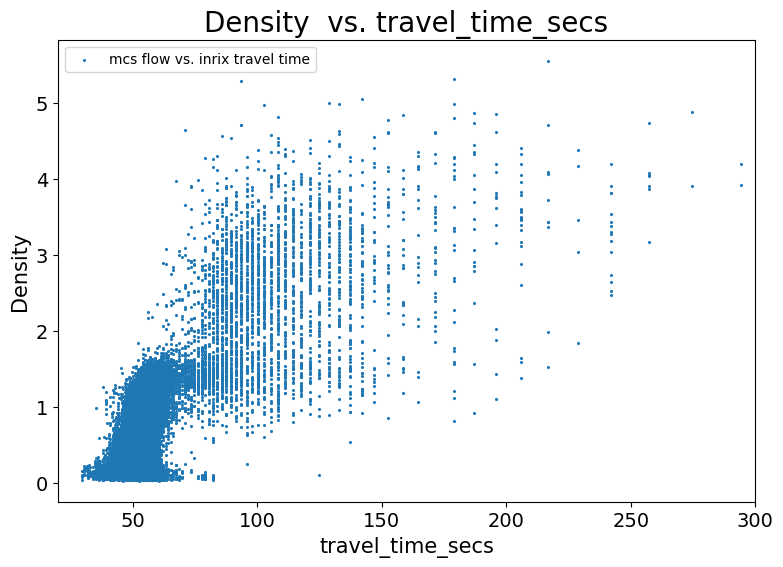

In [90]:
plt.figure(figsize=(9, 6))
plt.xlim(left= 20.0, right = 300.0)
# plt.ylim(top = 2000)
plotScatter(combinedSouth_shifted.iloc[:38407], combinedSouth_shifted.iloc[:38407], 'travel_time_secs', 'Density', 'mcs flow vs. inrix travel time')

In [91]:
combinedSouth9days_shifted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12727 entries, 0 to 12726
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fk_id             12727 non-null  int64  
 1   date              12727 non-null  object 
 2   speed             12727 non-null  float64
 3   speed_std_dev     12727 non-null  float64
 4   flow              12727 non-null  int64  
 5   used_lanes        12727 non-null  object 
 6   Epoch_mcs         12727 non-null  float64
 7   Density           12727 non-null  float64
 8   segmentid         12727 non-null  int64  
 9   timestamputc      12727 non-null  object 
 10  speed_inrix       12727 non-null  float64
 11  average           12727 non-null  float64
 12  Epoch_inrix       12727 non-null  int64  
 13  travel_time_secs  12727 non-null  float64
dtypes: float64(7), int64(4), object(3)
memory usage: 1.4+ MB


### 8.1 Use travel time alone to predict the flow

In [92]:
# prepare the feature and label columns from combinedSouth's 9days data
X_travel_time = combinedSouth9days_shifted['travel_time_secs'].values
X_epoch = combinedSouth9days_shifted['Epoch_mcs'].values.reshape(-1, 1)
Y_label = combinedSouth9days_shifted['Density'].values.reshape(-1, 1)
#X_speed = combinedSouth9days_shifted['speed_inrix'].values

# turn speed_inrix, travel_time into polynomial features: 1, s, s^2, s^3, ...
X_travel_time_poly = makePoly(15, X_travel_time)
# X_speed_poly = makePoly(20, X_speed)
X_travel_time_poly, scaler_travel_time_9 = normalize(X_travel_time_poly)
# X_speed_poly, scaler_speed_9 = normalize(X_speed_poly)

# Drop the intercept bias in travel_time features, then append it to speed to form feature arrays
dfRawFeatures_travel = pd.DataFrame(X_travel_time_poly)
print(dfRawFeatures_travel.head(10))
dfRawFeatures_travel.describe()
# X_travel_time_poly = np.delete(X_travel_time_poly, 0, 1)
# X_speed_travel = np.append(X_speed_poly, X_travel_time_poly, axis=1)
X_features = X_travel_time_poly

# split training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=0)

# build and train the polynomial regression model
regressor = model(X_train, Y_train)

# Evaluate Performance of training set
Y_predict_train = regressor.predict(X_train)
print("Root Mean Square Error: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score: ", r2_score(Y_train, Y_predict_train))

# Evaluate Performance of testing set
Y_predict_test = regressor.predict(X_test)
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score: ", r2_score(Y_test, Y_predict_test))
dfRawFeatures_speed.describe()

    0         1         2         3   ...        12        13        14        15
0  1.0 -0.703822 -0.390659 -0.177069  ... -0.011574 -0.011203 -0.010912 -0.010675
1  1.0 -0.703822 -0.390659 -0.177069  ... -0.011574 -0.011203 -0.010912 -0.010675
2  1.0 -0.766371 -0.413007 -0.182286  ... -0.011574 -0.011203 -0.010912 -0.010675
3  1.0 -0.766371 -0.413007 -0.182286  ... -0.011574 -0.011203 -0.010912 -0.010675
4  1.0 -0.766371 -0.413007 -0.182286  ... -0.011574 -0.011203 -0.010912 -0.010675
5  1.0 -0.766371 -0.413007 -0.182286  ... -0.011574 -0.011203 -0.010912 -0.010675
6  1.0 -0.766371 -0.413007 -0.182286  ... -0.011574 -0.011203 -0.010912 -0.010675
7  1.0 -0.766371 -0.413007 -0.182286  ... -0.011574 -0.011203 -0.010912 -0.010675
8  1.0 -0.317654 -0.237018 -0.137028  ... -0.011574 -0.011203 -0.010912 -0.010675
9  1.0 -0.154484 -0.163994 -0.115668  ... -0.011574 -0.011203 -0.010912 -0.010675

[10 rows x 16 columns]
Root Mean Square Error:  0.4692269072655037
R2 Score:  0.6232204231351122


0             1   ...            20             21
count  12727.0  1.272700e+04  ...  1.272700e+04   12727.000000
mean       1.0  1.063505e-13  ... -8.613126e-16  392764.502239
std        0.0  1.000039e+00  ...  1.000039e+00  222387.715718
min        1.0 -4.457770e+00  ... -6.008946e-02    6840.000000
25%        1.0 -3.074185e-01  ... -5.991831e-02  200550.000000
50%        1.0  1.849961e-01  ... -5.890734e-02  393360.000000
75%        1.0  4.663758e-01  ... -5.679192e-02  585030.000000
max        1.0  3.983623e+00  ...  5.429708e+01  777480.000000

[8 rows x 22 columns]

travel time order: R2 <br>
5: 0.225 <br>
7: 0.226  <br>
10:0.227 <br>
13: 0.23 <br>
15: 0.237 <br>
16: over-fitting

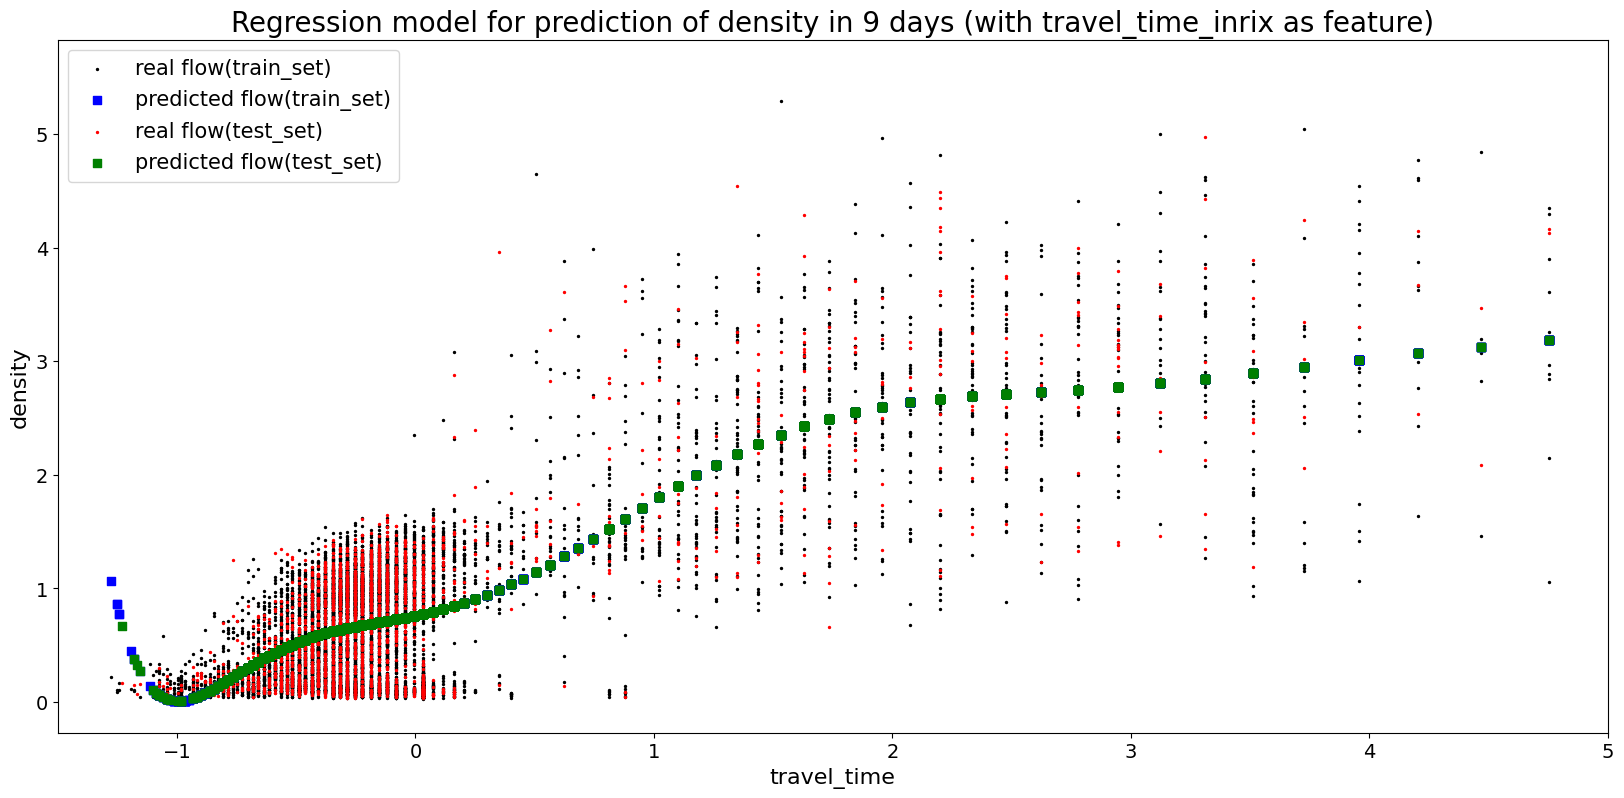

In [93]:
# Plot real and predicted flow from X_train, X_test w.r.t. travel_time
plt.figure(figsize=(20, 9))
plt.xlim(left= -1.5, right = 5.0)
plotResult(X_train[:, 1], Y_train[:, 0], Y_predict_train[:, 0], 
           X_test[:, 1], Y_test[:, 0], Y_predict_test[:, 0], '9 days (with travel_time_inrix as feature)', 'travel_time')

In [94]:
# Use all data to train and predict the flow
regressor = model(X_features, Y_label)
Y_predict = regressor.predict(X_features)
print("Root Mean Square Error: ", mean_squared_error(Y_label, Y_predict, squared=False))
print("R2 Score: ", r2_score(Y_label, Y_predict))

Root Mean Square Error:  0.47101465411299004
R2 Score:  0.626194800768116


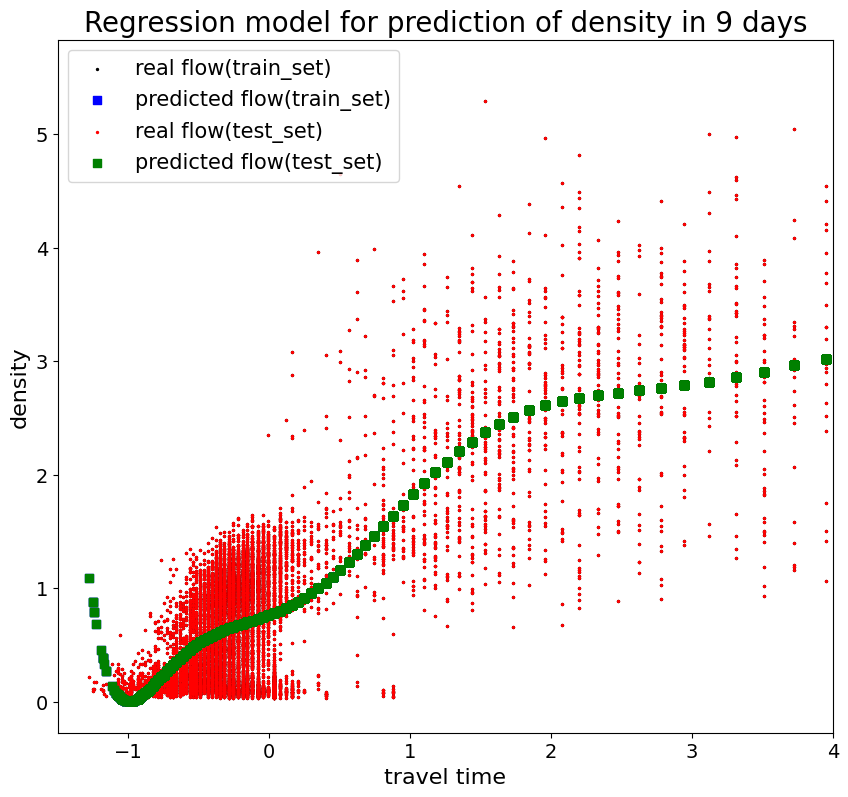

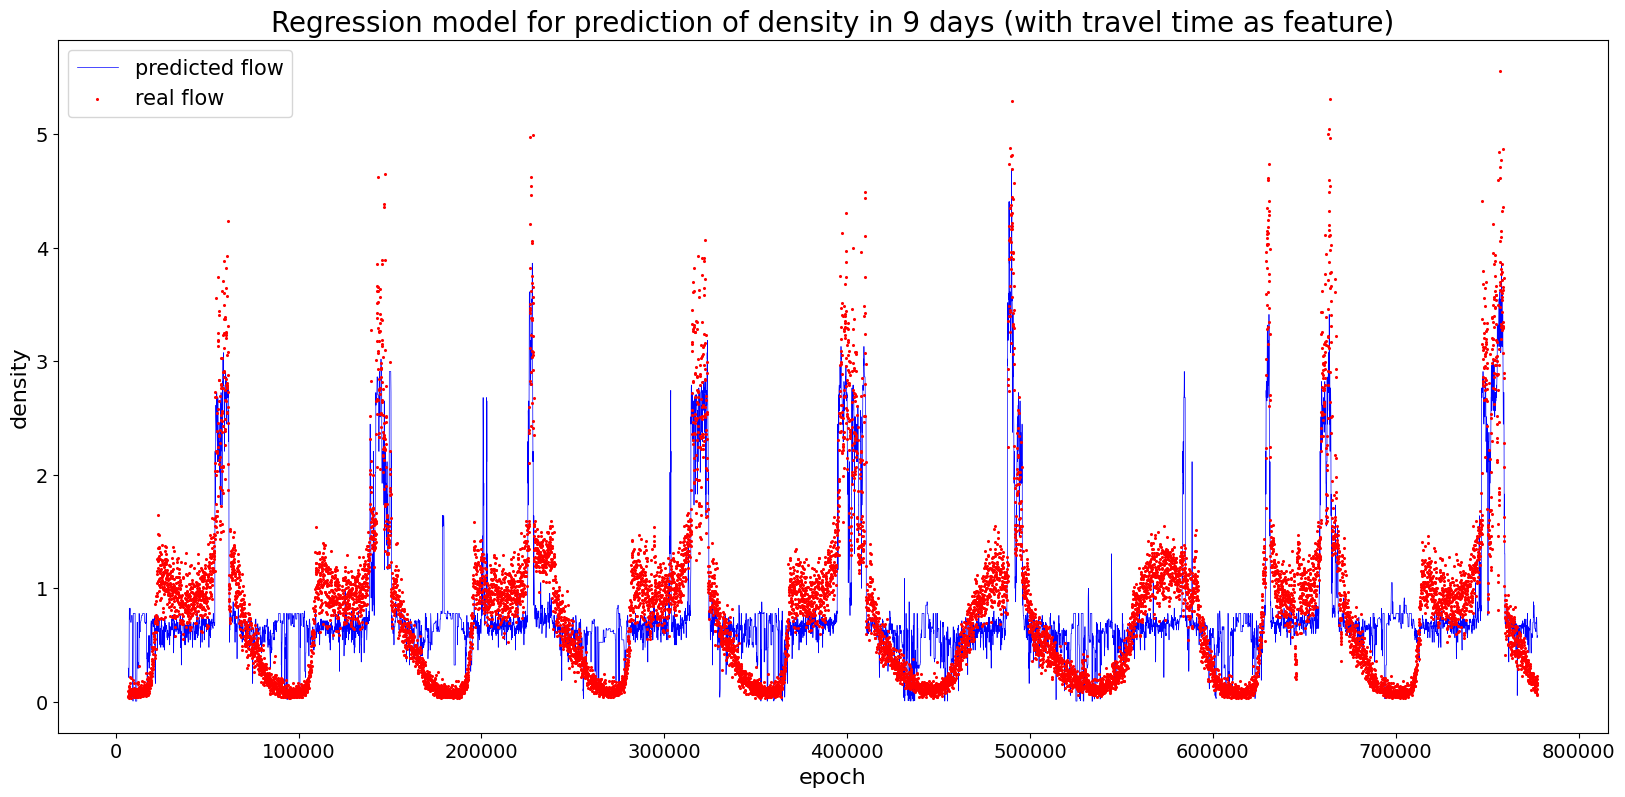

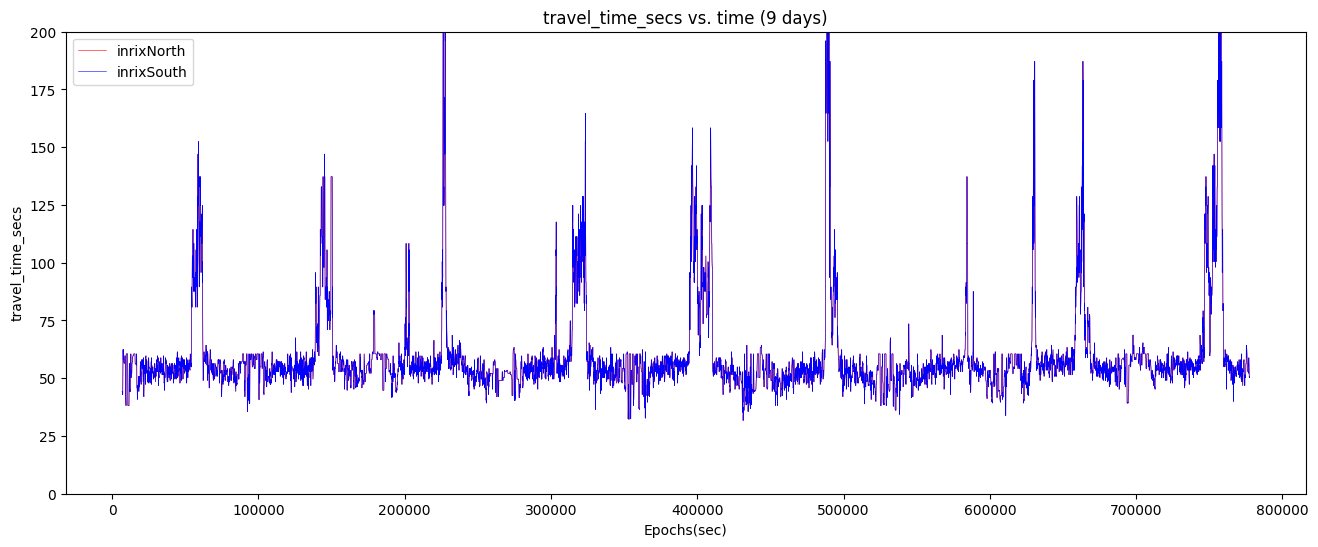

In [95]:
# Plot real and predicted density from X_features
plt.figure(figsize=(10, 9))
plt.xlim(left = -1.5, right = 4)
# plt.ylim(bottom = 0, top = 2000)
plotResult(X_features[:, 1], Y_label[:, 0], Y_predict[:, 0], 
           X_features[:, 1], Y_label[:, 0], Y_predict[:, 0], '9 days', 'travel time')

plt.figure(figsize=(20, 9))
plotResult(X_epoch[:, 0], Y_label[:, 0], Y_predict[:, 0], 
           None, None, None, '9 days (with travel time as feature)', 'epoch')

#plt.figure(figsize=(20, 9))
#plotAttr(9, combinedSouth9days_shifted.iloc[:round(len(combinedSouth9days_shifted)/3)], 
         #combinedSouth9days_shifted.iloc[:round(len(combinedSouth9days_shifted)/3)],'travel_time_secs', 'inrix')
plt.figure(figsize=(16, 6))
plt.ylim(top= 200)
plotAttr(9, combinedSouth9days_shifted, combinedSouth9days_shifted,'travel_time_secs', 'inrix')

### 8.2 Use 'Speed' and 'Travel Time" to in polynomial regression model

In [96]:
# prepare the feature and label columns from combinedSouth's 9days data
X_travel_time = combinedSouth9days_shifted['travel_time_secs'].values
X_epoch = combinedSouth9days_shifted['Epoch_mcs'].values.reshape(-1, 1)
Y_label = combinedSouth9days_shifted['Density'].values.reshape(-1, 1)
X_speed = combinedSouth9days_shifted['speed_inrix'].values

# turn speed_inrix, travel_time into polynomial features: 1, s, s^2, s^3, ...
X_speed_poly = makePoly(15, X_speed)
X_travel_time_poly = makePoly(10, X_travel_time)
X_speed_poly, scaler_speed_9 = normalize(X_speed_poly)
X_travel_time_poly, scaler_travel_time_9 = normalize(X_travel_time_poly)

# Drop the intercept bias in travel_time features, then append it to speed to form feature arrays
X_travel_time_poly = np.delete(X_travel_time_poly, 0, 1)
X_speed_travel = np.append(X_speed_poly, X_travel_time_poly, axis=1)
dfRawFeatures_speed_travel = pd.DataFrame(X_speed_travel)
X_features = X_speed_travel

# split training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_label, test_size=0.2, random_state=0)

# build and train the polynomial regression model
regressor = model(X_train, Y_train)

# Evaluate Performance of training set
Y_predict_train = regressor.predict(X_train)
print("Root Mean Square Error: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score: ", r2_score(Y_train, Y_predict_train))

# Evaluate Performance of testing set
Y_predict_test = regressor.predict(X_test)
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score: ", r2_score(Y_test, Y_predict_test))

dfRawFeatures_speed_travel.describe()

Root Mean Square Error:  0.4648757984202214
R2 Score:  0.6301757271090431
Root Mean Square Error:  0.474503814737938
R2 Score:  0.6426569070055153


0             1   ...            24            25
count  12727.0  1.272700e+04  ...  1.272700e+04  1.272700e+04
mean       1.0  1.063505e-13  ... -9.276209e-16  4.970755e-16
std        0.0  1.000039e+00  ...  1.000039e+00  1.000039e+00
min        1.0 -4.457770e+00  ... -1.385874e-02 -1.277953e-02
25%        1.0 -3.074185e-01  ... -1.385844e-02 -1.277950e-02
50%        1.0  1.849961e-01  ... -1.385820e-02 -1.277946e-02
75%        1.0  4.663758e-01  ... -1.385773e-02 -1.277940e-02
max        1.0  3.983623e+00  ...  1.048044e+02  1.063067e+02

[8 rows x 26 columns]

(S, T): R2 <br>
(15, 10): 0.256 <br>
(20, 10): overfitting <br>
(15,15): overfitting <br>
(10, 15): overfitting <br>
==> No much improvement by using 2 features in the same time



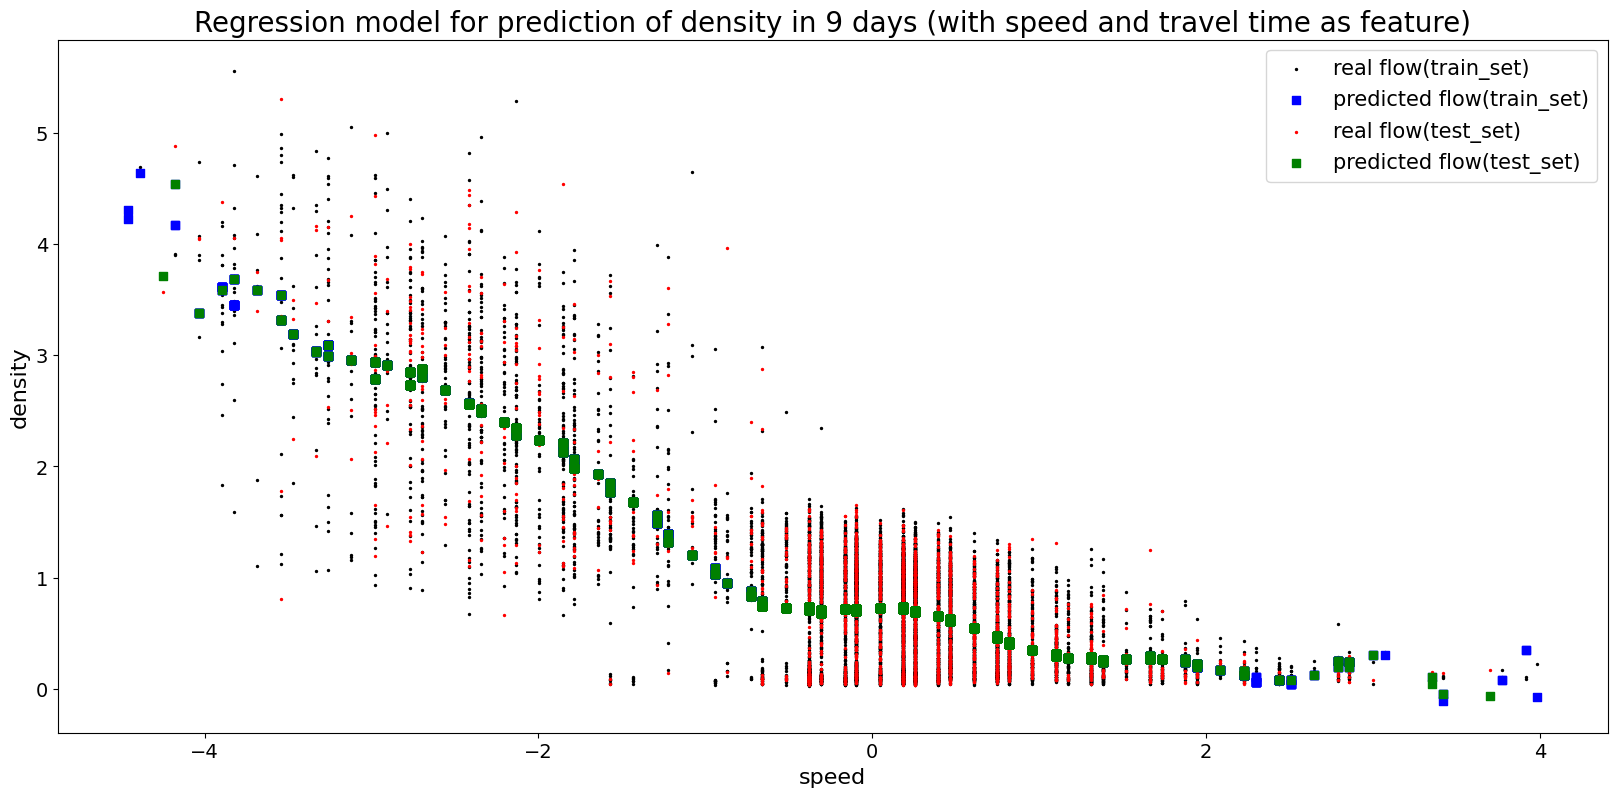

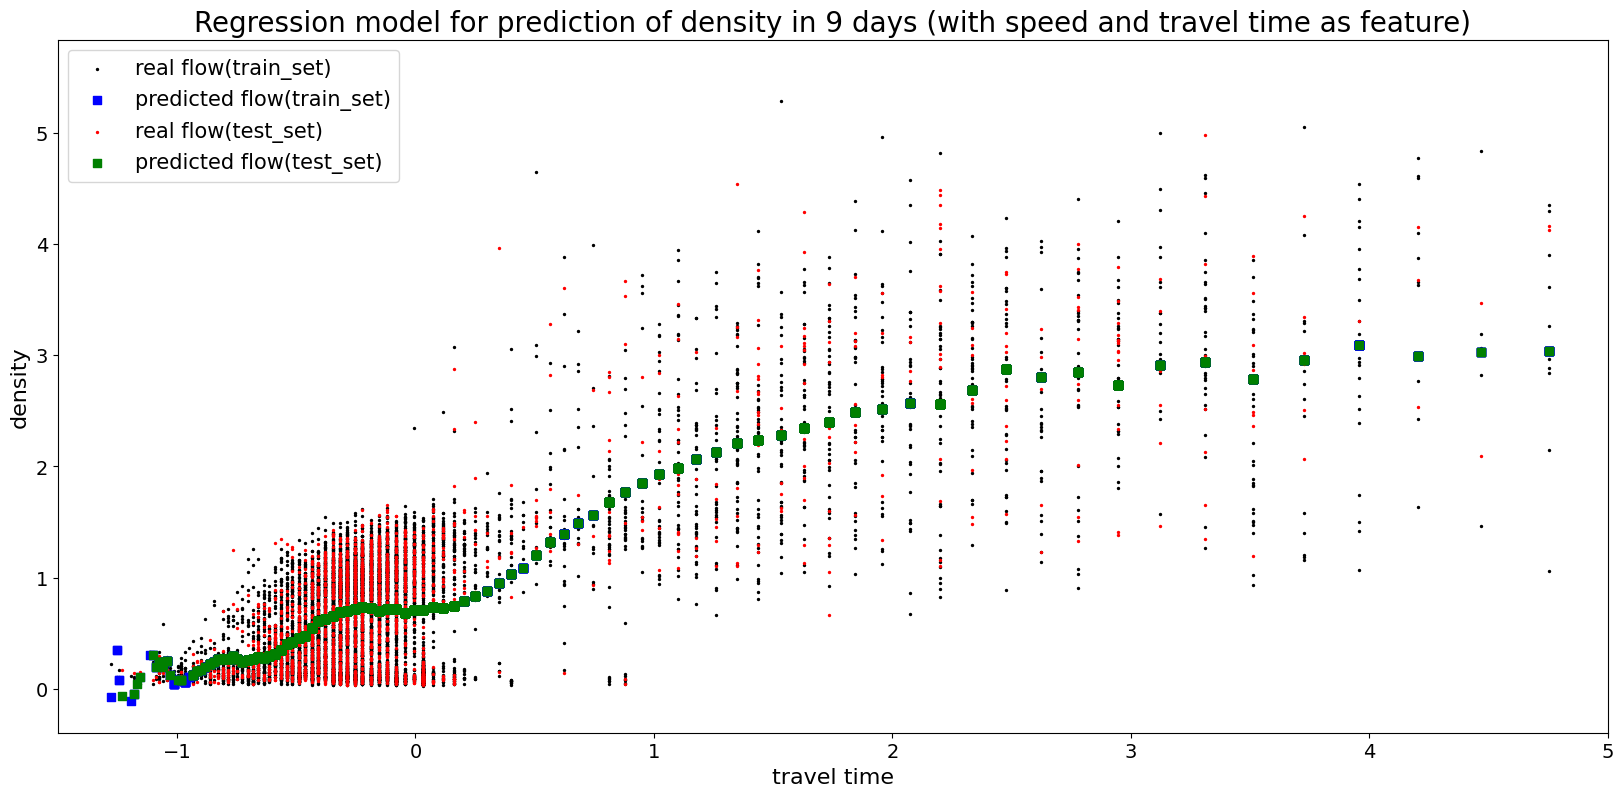

In [97]:
# Plot real and predicted flow from X_train, X_test to 'speed' and 'travel' feature
plt.figure(figsize=(20, 9))
# plt.ylim(top = 2000)
plotResult(X_train[:, 1], Y_train[:, 0], Y_predict_train[:, 0], 
           X_test[:, 1], Y_test[:, 0], Y_predict_test[:, 0], '9 days (with speed and travel time as feature)', 'speed')

# Plot real and predicted flow from X_train, X_test to 'speed' and 'travel' feature
plt.figure(figsize=(20, 9))
# plt.ylim(top = 2000)
plt.xlim(left = -1.5, right = 5.0)
plotResult(X_train[:,16], Y_train[:, 0], Y_predict_train[:, 0], 
           X_test[:, 16], Y_test[:, 0], Y_predict_test[:, 0], '9 days (with speed and travel time as feature)', 'travel time')

In [98]:
# Use all data to train and predict the flow
regressor = model(X_features, Y_label)
Y_predict = regressor.predict(X_features)
print("Root Mean Square Error: ", mean_squared_error(Y_label, Y_predict, squared=False))
print("R2 Score: ", r2_score(Y_label, Y_predict))

Root Mean Square Error:  0.4666733020244196
R2 Score:  0.6330537856644258


## 9. Decision Tree Regression

### 9.0 Import decision tree library

In [0]:
from sklearn.tree import DecisionTreeRegressor

### 9.1 Use Inrix speed and travel time as features

In [100]:
# prepare the features [speed, travel_time] and label[flow]
X = combinedSouth9days_shifted[['speed_inrix', 'travel_time_secs']].values
X_epoch = combinedSouth9days_shifted['Epoch_mcs']
Y_label = combinedSouth9days_shifted['Density'].values
print(type(X))
print(X.shape)
print(X)
print(Y.shape)

# split the train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_label, test_size=0.2, random_state=0)


<class 'numpy.ndarray'>
(12727, 2)
[[25.83333333 44.28      ]
 [25.83333333 44.28      ]
 [26.94444444 42.9       ]
 ...
 [22.77777778 50.22      ]
 [22.22222222 50.82      ]
 [22.22222222 50.82      ]]
(1424, 1)


In [0]:
def quickSplitTuning(model, x_train, y_train, x_test, y_test, split):
  trainR2Array = []
  testR2Array = []
  for i in split:
    estimator = model(max_depth = i, random_state = 0)
    estimator.fit(x_train, y_train)

    trainR2Array.append(estimator.score(x_train, y_train))
    testR2Array.append(estimator.score(x_test, y_test))

  result = pd.DataFrame({'split': split, 'Train_R2': trainR2Array, 'Test_R2': testR2Array})
  return result


In [102]:
# temporarily tune the max_depth (hyperparameters) 
split = list(range(2, 30))
print(split)
result = quickSplitTuning(DecisionTreeRegressor, X_train, Y_train, X_test, Y_test, split)
print(result)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
    split  Train_R2   Test_R2
0       2  0.595591  0.589871
1       3  0.627864  0.630953
2       4  0.653023  0.660054
3       5  0.660956  0.662595
4       6  0.663608  0.661835
5       7  0.664756  0.660860
6       8  0.665213  0.660288
7       9  0.665899  0.660502
8      10  0.665916  0.660481
9      11  0.665924  0.660474
10     12  0.665924  0.660475
11     13  0.665925  0.660477
12     14  0.665925  0.660477
13     15  0.665925  0.660477
14     16  0.665925  0.660477
15     17  0.665925  0.660477
16     18  0.665925  0.660477
17     19  0.665925  0.660477
18     20  0.665925  0.660477
19     21  0.665925  0.660477
20     22  0.665925  0.660477
21     23  0.665925  0.660477
22     24  0.665925  0.660477
23     25  0.665925  0.660477
24     26  0.665925  0.660477
25     27  0.665925  0.660477
26     28  0.665925  0.660477
27     29  0.665925  0.660477


Best max_depth: 5

In [103]:
# train the model with train dataset and check the accuracy
DTRegressor = DecisionTreeRegressor(max_depth = 5, random_state=0)
DTRegressor.fit(X_train, Y_train)

# Evaluate Performance of training set
Y_predict_train = DTRegressor.predict(X_train)
print("Root Mean Square Error: ", mean_squared_error(Y_train, Y_predict_train, squared=False))
print("R2 Score: ", DTRegressor.score(X_train, Y_train))

# Evaluate Performance of testing set
Y_predict_test = DTRegressor.predict(X_test)
print("Root Mean Square Error: ", mean_squared_error(Y_test, Y_predict_test, squared=False))
print("R2 Score: ", r2_score(Y_test, Y_predict_test))


Root Mean Square Error:  0.44511014897242246
R2 Score:  0.6609556347215235
Root Mean Square Error:  0.4610763475342157
R2 Score:  0.6625948835395523


Short Conclusion:
slightly improve the accuracy to 0.64 by using decision tree to predict Mcs flow by using Inrix.

In [104]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(10181, 2)
(2546, 2)
(10181,)


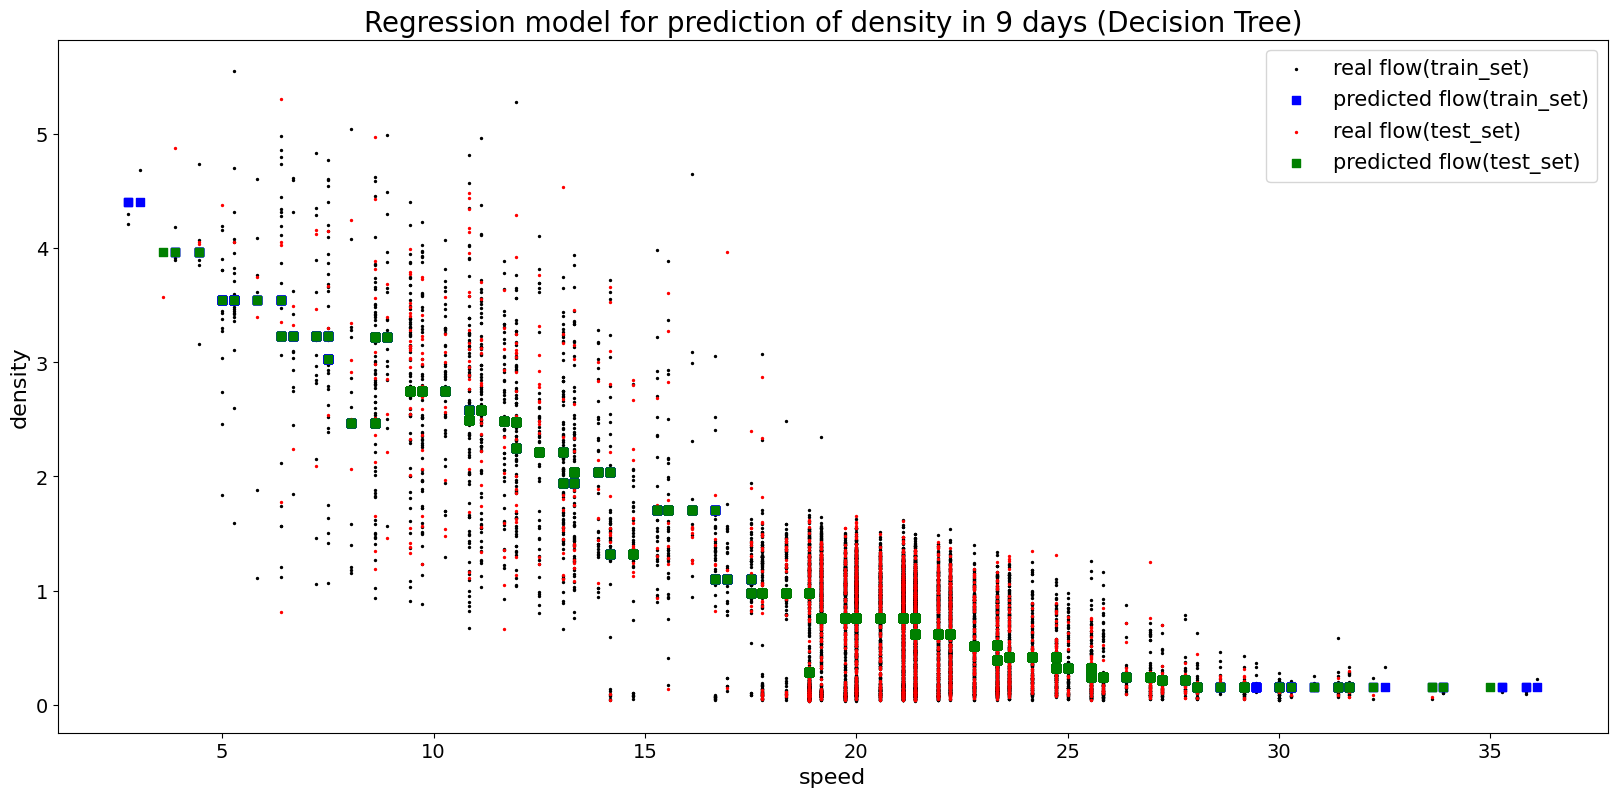

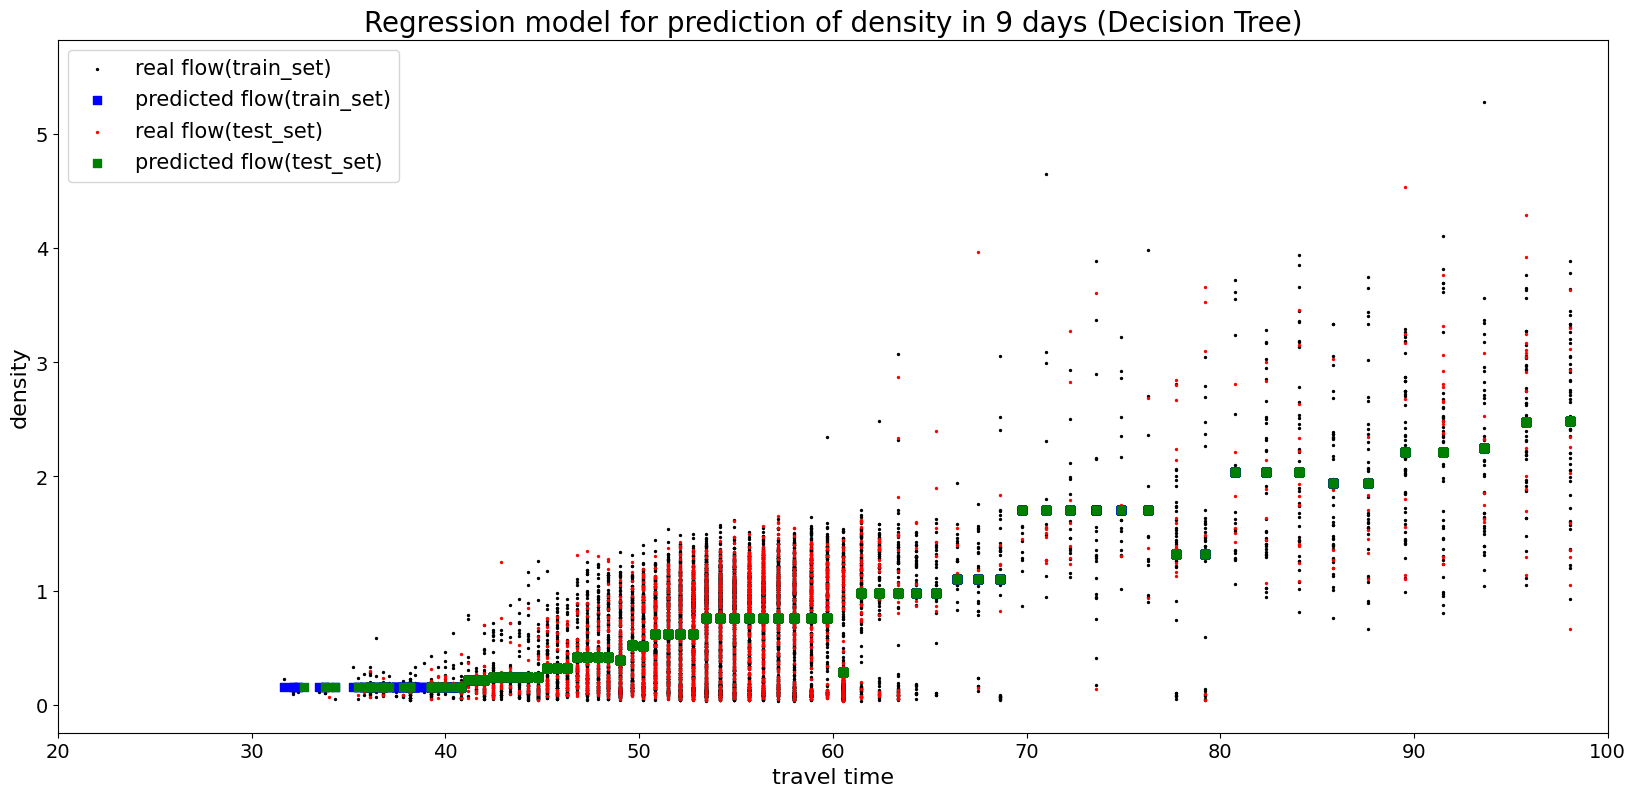

In [105]:
# Plot real and predicted flow from X_train, X_test to 'speed' and 'travel' feature
plt.figure(figsize=(20, 9))
# plt.ylim(top = 2000)
plotResult(X_train[:, 0], Y_train, Y_predict_train, X_test[:, 0], Y_test, Y_predict_test, '9 days (Decision Tree)', 'speed')

# Plot real and predicted flow from X_train, X_test to 'speed' and 'travel' feature
plt.figure(figsize=(20, 9))
# plt.ylim(top = 2000)
plt.xlim(left = 20, right = 100)
plotResult(X_train[:,1], Y_train, Y_predict_train, 
           X_test[:, 1], Y_test, Y_predict_test, '9 days (Decision Tree)', 'travel time')

In [106]:
# Use all data to train and predict the flow
DTRegressor.fit(X, Y_label)
Y_predict = DTRegressor.predict(X)
print("Root Mean Square Error: ", mean_squared_error(Y_label, Y_predict, squared=False))
print("R2 Score: ", r2_score(Y_label, Y_predict))

Root Mean Square Error:  0.4480848350949853
R2 Score:  0.6617038996474565


In [107]:
# check the structure of the decision tree
print(DTRegressor.get_depth())
print(DTRegressor.get_n_leaves())

5
31


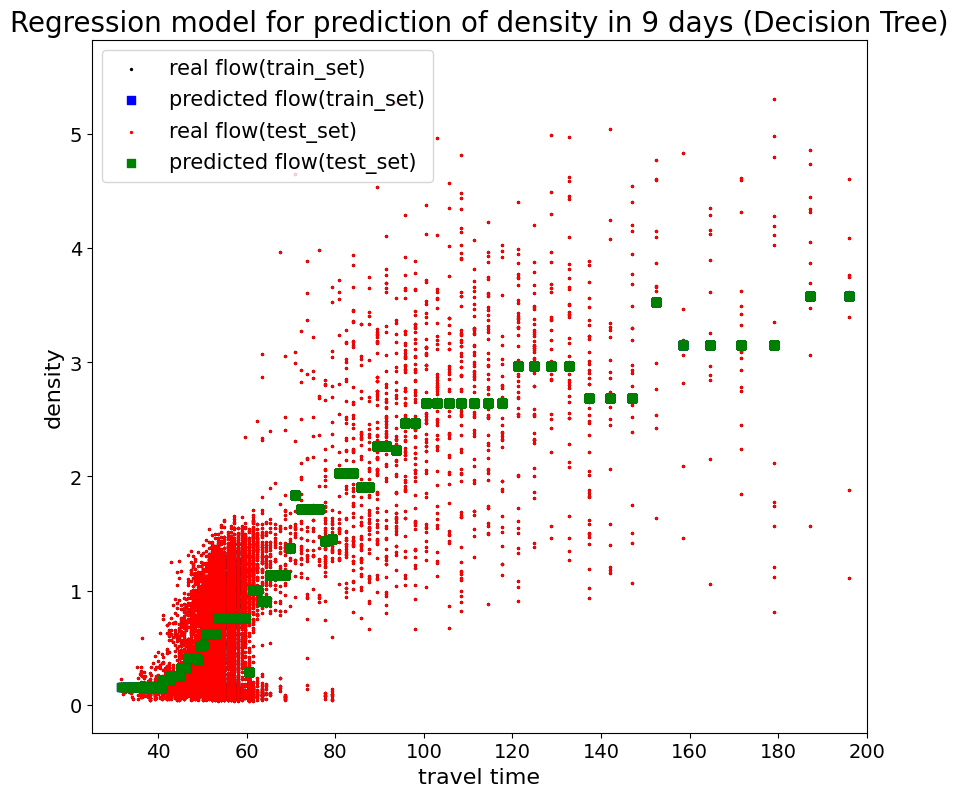

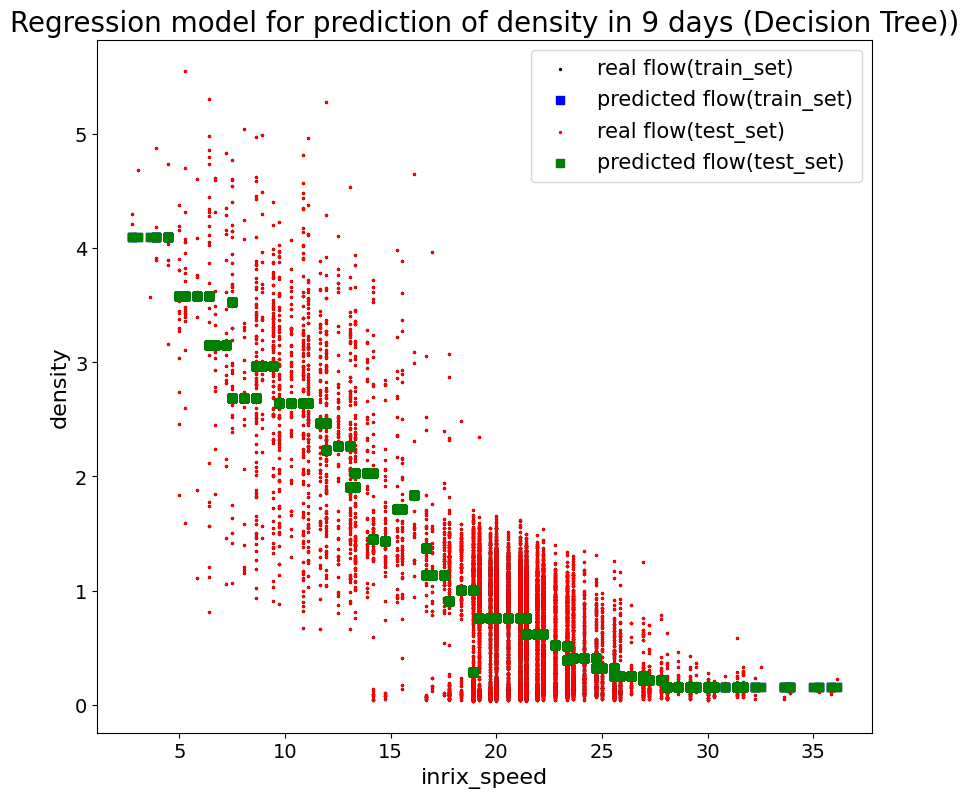

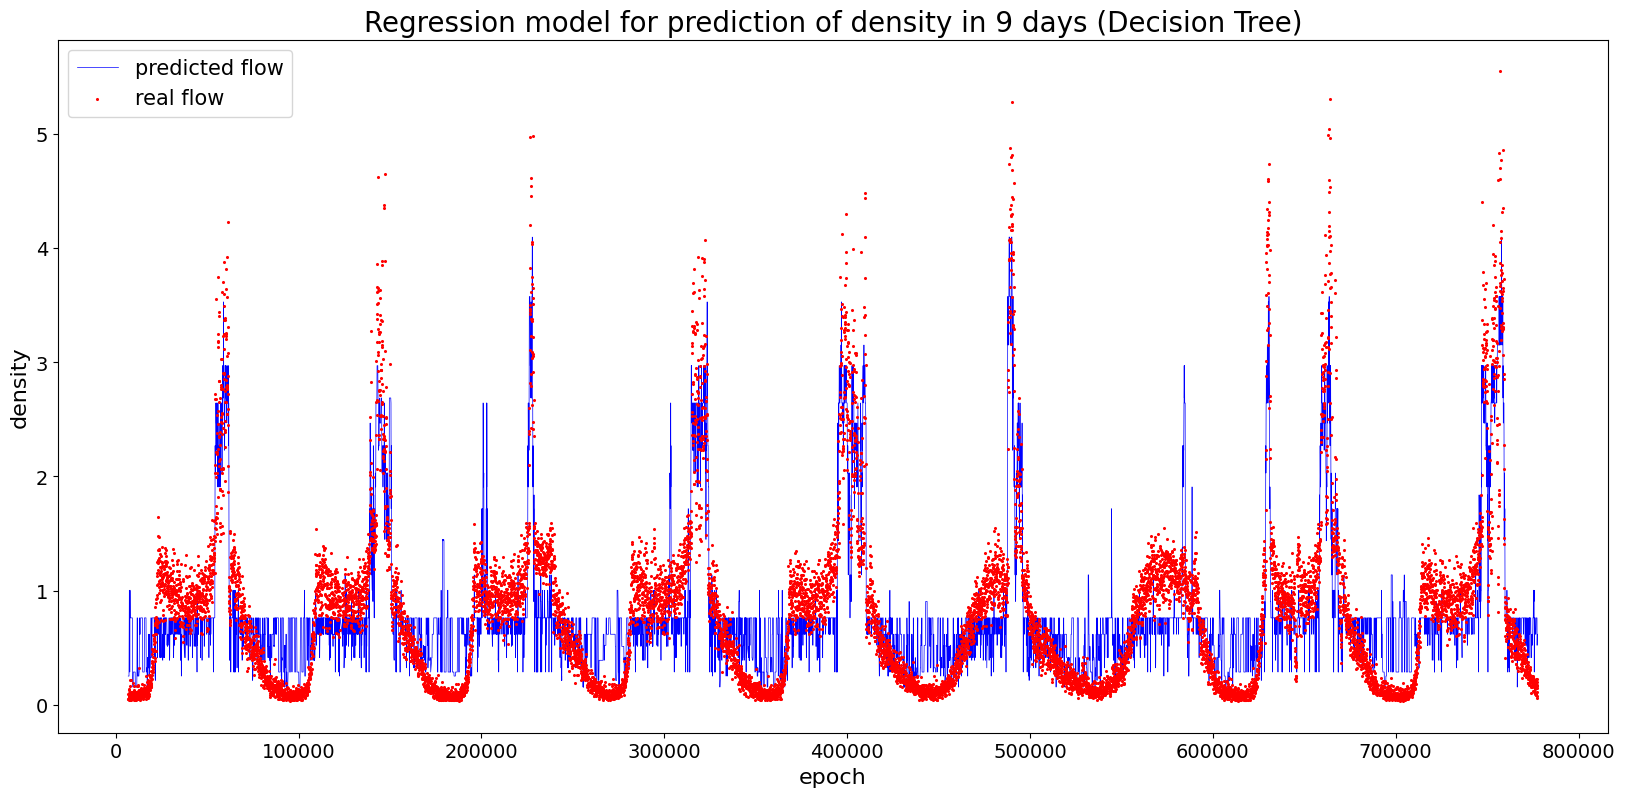

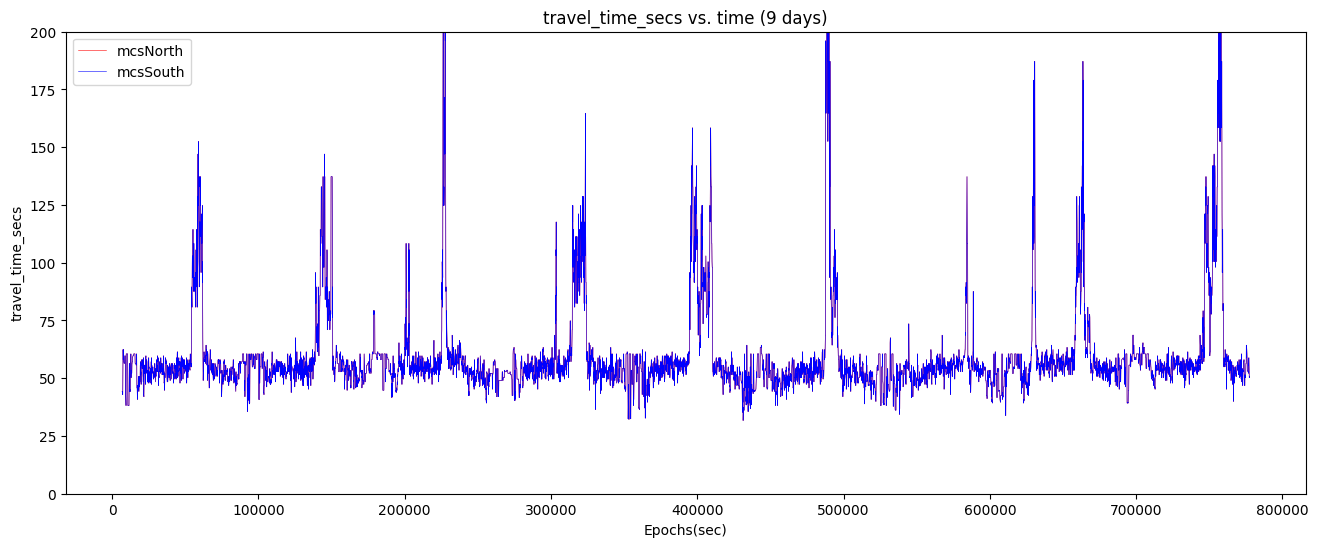

In [108]:
# Plot real and predicted flow vs. travel time(a feature)
plt.figure(figsize=(10, 9))
plt.xlim(left = 25, right = 200)
'''plt.ylim(bottom = 0, top = 2000)'''
plotResult(X[:, 1], Y_label, Y_predict, 
           X[:, 1], Y_label, Y_predict, '9 days (Decision Tree)', 'travel time')

# Plot real and predicted flow vs. speed (a feature)
plt.figure(figsize=(10, 9))
'''plt.xlim(left = -1.5, right = 4)
plt.ylim(bottom = 0, top = 2000)'''
plotResult(X[:, 0], Y_label, Y_predict, 
           X[:, 0], Y_label, Y_predict, '9 days (Decision Tree))', 'inrix_speed')

# plot flow vs. epoch in 9 days range
plt.figure(figsize=(20, 9))
plotResult(X_epoch, Y_label, Y_predict, 
           None, None, None, '9 days (Decision Tree)', 'epoch')


# plot travel_time vs. epoch in 9 syas range
plt.figure(figsize=(16, 6))
plt.ylim(top= 200)
plotAttr(9, combinedSouth9days_shifted, combinedSouth9days_shifted,'travel_time_secs', 'mcs')